.



# I. Importing the required libraries

In [1]:

## Python
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical



## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

Using TensorFlow backend.


# II. Reading the data

In [2]:
# Data Directory

dir_list = os.listdir('C://Users//pranav//Desktop//SER//xdata//')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [3]:
# Create DataFrame for Data intel

data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('C://Users//pranav//Desktop//SER//xdata//' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'C://Users//pranav//Desktop//SER//xdata//' + i + '//' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [4]:
print (len(data_df))
data_df.head()

2452


path source actor gender  \
0  C://Users//pranav//Desktop//SER//xdata//Actor_...      1     1   male   
1  C://Users//pranav//Desktop//SER//xdata//Actor_...      1     1   male   
2  C://Users//pranav//Desktop//SER//xdata//Actor_...      1     1   male   
3  C://Users//pranav//Desktop//SER//xdata//Actor_...      1     1   male   
4  C://Users//pranav//Desktop//SER//xdata//Actor_...      1     1   male   

  intensity statement repetition emotion  
0         0         0          0       1  
1         0         0          1       1  
2         0         1          0       1  
3         0         1          1       1  
4         0         0          0       2

# III. Plotting the audio file's waveform and its spectrogram

In [5]:
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

C://Users//pranav//Desktop//SER//xdata//Actor_10//03-02-04-02-01-02-10.wav


(22050, array([-3.4990700e-04, -2.1845367e-04,  5.5546162e-04, ...,
        -9.7345328e-06, -3.8411690e-05,  0.0000000e+00], dtype=float32))

In [6]:
len(samples), sample_rate

(112568, 22050)

In [7]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)


In [8]:
sample_rate/ len(samples)

0.19588160045483619

Text(0.5,0,'Seconds')

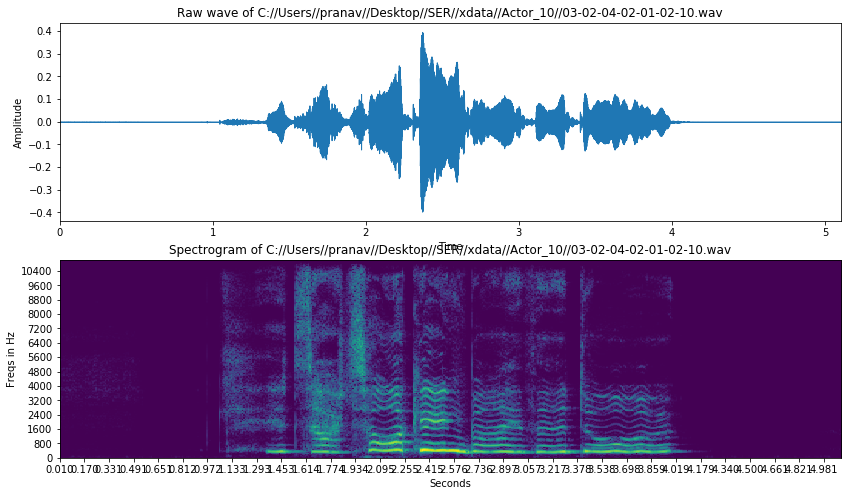

In [9]:
# Plotting Wave Form and Spectrogram

freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [10]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [11]:
# Trim the silence voice

aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([-0.00037444, -0.00035654, -0.0005744 , ..., -0.0013954 ,
        -0.00090462, -0.00053319], dtype=float32), array([29184, 88576]))

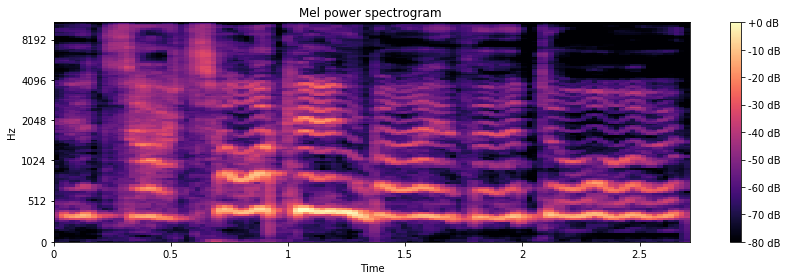

In [12]:
# Plotting Mel Power Spectrogram

S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

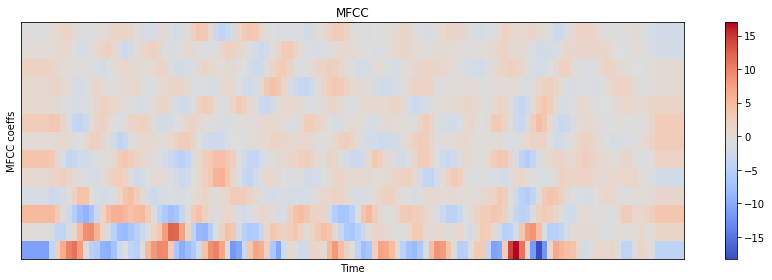

In [13]:
# Plotting MFCC

mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it

delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [14]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [15]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [16]:
# Silence trimmed Sound by manuel trimming
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

# IV. Defining the truth label

In [17]:
# 2 class: Positive & Negative

# Positive: Calm, Happy
# Negative: Angry, Fearful, Sad

label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

2452

In [18]:
#3 class: Positive, Neutral & Negative

# Positive:  Happy
# Negative: Angry, Fearful, Sad
# Neutral: Calm, Neutral

label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

2452

In [19]:
# 5 class: angry, calm, sad, happy & fearful
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

2452

In [20]:
# All class

label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

2452

In [21]:
# Selecting the label set we want by commenting the unwanteds.

data_df['label'] = label2_list
# data_df['label'] = label3_list
# data_df['label'] = label5_list
# data_df['label'] = label8_list
data_df.head()

path source actor gender  \
0  C://Users//pranav//Desktop//SER//xdata//Actor_...      1     1   male   
1  C://Users//pranav//Desktop//SER//xdata//Actor_...      1     1   male   
2  C://Users//pranav//Desktop//SER//xdata//Actor_...      1     1   male   
3  C://Users//pranav//Desktop//SER//xdata//Actor_...      1     1   male   
4  C://Users//pranav//Desktop//SER//xdata//Actor_...      1     1   male   

  intensity statement repetition emotion          label  
0         0         0          0       1      male_none  
1         0         0          1       1      male_none  
2         0         1          0       1      male_none  
3         0         1          1       1      male_none  
4         0         0          0       2  male_positive

In [22]:
print (data_df.label.value_counts().keys())

Index(['male_negative', 'female_negative', 'male_positive', 'female_positive',
       'male_none', 'female_none'],
      dtype='object')


In [23]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

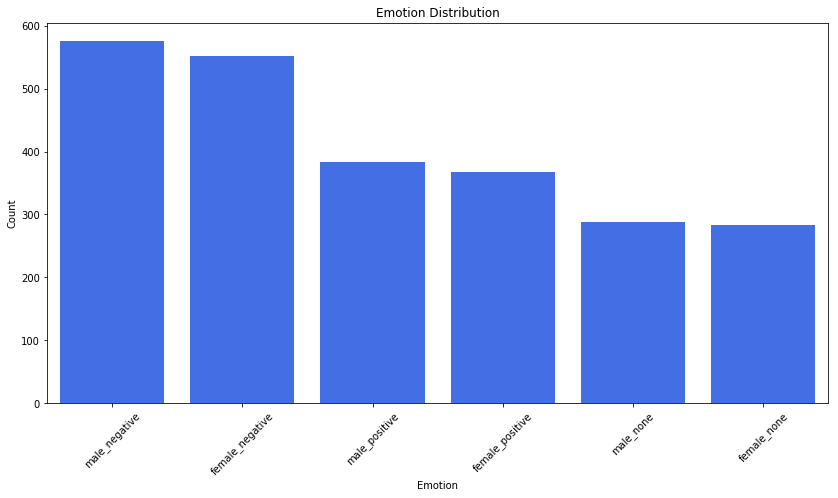

In [24]:
a = data_df.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

# V. Data Splitting

In [25]:
# Female Data Set

## Uncomment all below to use Female set 

# data2_df = data_df.copy()
# data2_df = data2_df[data2_df.label != "male_none"]
# data2_df = data2_df[data2_df.label != "female_none"]
# data2_df = data2_df[data2_df.label != "male_happy"]
# data2_df = data2_df[data2_df.label != "male_angry"]
# data2_df = data2_df[data2_df.label != "male_sad"]
# data2_df = data2_df[data2_df.label != "male_fearful"]
# data2_df = data2_df[data2_df.label != "male_calm"]
# data2_df = data2_df[data2_df.label != "male_positive"]
# data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

# tmp1 = data2_df[data2_df.actor == 22]
# tmp2 = data2_df[data2_df.actor == 24]
# data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
# data2_df = data2_df[data2_df.actor != 22]
# data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
# print (len(data2_df))
# data2_df.head()

In [26]:
# Male Data Set

## Uncomment all below to use Male set 

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

800


path source actor gender  \
0  C://Users//pranav//Desktop//SER//xdata//Actor_...      1     1   male   
1  C://Users//pranav//Desktop//SER//xdata//Actor_...      1     1   male   
2  C://Users//pranav//Desktop//SER//xdata//Actor_...      1     1   male   
3  C://Users//pranav//Desktop//SER//xdata//Actor_...      1     1   male   
4  C://Users//pranav//Desktop//SER//xdata//Actor_...      1     1   male   

  intensity statement repetition emotion          label  
0         0         0          0       2  male_positive  
1         0         0          1       2  male_positive  
2         0         1          0       2  male_positive  
3         0         1          1       2  male_positive  
4         1         0          0       2  male_positive

In [27]:
print (len(data3_df))
data3_df.head()

160


path source actor gender  \
0  C://Users//pranav//Desktop//SER//xdata//Actor_...      1    21   male   
1  C://Users//pranav//Desktop//SER//xdata//Actor_...      1    21   male   
2  C://Users//pranav//Desktop//SER//xdata//Actor_...      1    21   male   
3  C://Users//pranav//Desktop//SER//xdata//Actor_...      1    21   male   
4  C://Users//pranav//Desktop//SER//xdata//Actor_...      1    21   male   

  intensity statement repetition emotion          label  
0         0         0          0       2  male_positive  
1         0         0          1       2  male_positive  
2         0         1          0       2  male_positive  
3         0         1          1       2  male_positive  
4         1         0          0       2  male_positive

# VI. Getting the features of audio files using librosa

In [28]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [01:28<00:00,  9.44it/s]


In [29]:
data.head()

feature
0  [-70.2677641610773, -70.2677641610773, -70.267...
1  [-67.55739512198222, -67.55739512198222, -67.5...
2  [-69.67328949566406, -69.69331084873151, -69.6...
3  [-69.05139995492158, -69.05139995492158, -69.0...
4  [-73.8413701111492, -73.8413701111492, -73.841...

In [30]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [31]:
df3.head()

0          1          2          3          4          5    \
0 -70.267764 -70.267764 -70.267764 -70.267764 -70.267764 -70.267764   
1 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395   
2 -69.673289 -69.693311 -69.693311 -69.693311 -69.693311 -69.693311   
3 -69.051400 -69.051400 -69.051400 -69.051400 -69.051400 -68.754863   
4 -73.841370 -73.841370 -73.841370 -73.719655 -73.841370 -73.841370   

         6          7          8          9    ...        249        250  \
0 -70.267764 -70.267764 -70.267764 -70.267764  ... -70.267764 -70.267764   
1 -65.239801 -65.536197 -67.557395 -67.557395  ... -67.557395 -67.557395   
2 -69.693311 -69.620774 -69.693311 -68.906572  ... -69.693311 -69.693311   
3 -69.051400 -69.051400 -69.051400 -68.359101  ... -65.446950 -68.552088   
4 -73.841370 -73.303635 -72.806811 -73.841370  ... -73.841370 -73.841370   

         251        252        253        254        255        256  \
0 -69.957707 -68.377602 -69.862569 -70.267764 -70.122135 -68.554960   
1 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395   
2 -69.693311 -69.693311 -69.693311 -69.383522 -69.693311 -69.693311   
3 -69.051400 -69.051400 -69.051400 -68.688614 -69.051400        NaN   
4 -73.841370 -73.841370 -73.841370 -73.841370 -73.841370 -73.841370   

         257        258  
0 -70.206530 -70.267764  
1 -67.126574 -67.557395  
2 -69.693311 -69.693311  
3        NaN        NaN  
4 -73.841370 -73.841370  

[5 rows x 259 columns]

In [32]:
newdf = pd.concat([df3,labels], axis=1)

In [33]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

800

In [34]:
rnewdf.head(10)

0          1          2          3          4          5  \
0 -70.267764 -70.267764 -70.267764 -70.267764 -70.267764 -70.267764   
1 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395   
2 -69.673289 -69.693311 -69.693311 -69.693311 -69.693311 -69.693311   
3 -69.051400 -69.051400 -69.051400 -69.051400 -69.051400 -68.754863   
4 -73.841370 -73.841370 -73.841370 -73.719655 -73.841370 -73.841370   
5 -69.243253 -69.243253 -69.243253 -69.243253 -68.901972 -67.982999   
6 -73.254968 -73.254968 -73.254968 -73.254968 -68.774422 -69.380388   
7 -70.746514 -70.746514 -70.025286 -69.131263 -70.746514 -70.746514   
8 -63.311078 -63.072484 -63.412433 -63.796762 -63.581991 -58.921211   
9 -60.369038 -60.083715 -60.978925 -60.952456 -60.982486 -60.983948   

           6          7          8          9  ...        250        251  \
0 -70.267764 -70.267764 -70.267764 -70.267764  ... -70.267764 -69.957707   
1 -65.239801 -65.536197 -67.557395 -67.557395  ... -67.557395 -67.557395   
2 -69.693311 -69.620774 -69.693311 -68.906572  ... -69.693311 -69.693311   
3 -69.051400 -69.051400 -69.051400 -68.359101  ... -68.552088 -69.051400   
4 -73.841370 -73.303635 -72.806811 -73.841370  ... -73.841370 -73.841370   
5 -68.089201 -67.897329 -65.258010 -67.170980  ... -57.185978 -61.188731   
6 -73.254968 -73.254968 -73.254968 -73.254968  ... -50.884085 -55.666730   
7 -70.746514 -70.746514 -70.746514 -70.746514  ... -70.746514 -70.746514   
8 -57.955046 -61.224968 -63.782931 -63.796762  ... -63.740612 -62.410257   
9 -60.981255 -60.981255 -60.981255 -60.249618  ... -60.981255 -60.981255   

         252        253        254        255        256        257  \
0 -68.377602 -69.862569 -70.267764 -70.122135 -68.554960 -70.206530   
1 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395 -67.126574   
2 -69.693311 -69.693311 -69.383522 -69.693311 -69.693311 -69.693311   
3 -69.051400 -69.051400 -68.688614 -69.051400        NaN        NaN   
4 -73.841370 -73.841370 -73.841370 -73.841370 -73.841370 -73.841370   
5 -67.108389 -67.508122 -66.245553 -68.733048 -69.243253 -69.243253   
6 -54.600013 -53.439110 -56.300120 -57.458272 -58.767075 -59.836503   
7 -70.079249 -69.590462 -69.202740 -70.159467 -70.445363 -68.199043   
8 -62.489080 -62.494456 -62.632636 -62.824277        NaN        NaN   
9 -60.981255 -60.981255 -60.981255 -60.981255        NaN        NaN   

         258          label  
0 -70.267764  male_positive  
1 -67.557395  male_positive  
2 -69.693311  male_positive  
3        NaN  male_positive  
4 -73.841370  male_positive  
5 -69.243253  male_positive  
6 -58.409867  male_positive  
7 -67.414208  male_positive  
8        NaN  male_positive  
9        NaN  male_positive  

[10 rows x 260 columns]

In [35]:
rnewdf.isnull().sum().sum()

2284

In [36]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

0          1          2          3          4          5  \
0 -70.267764 -70.267764 -70.267764 -70.267764 -70.267764 -70.267764   
1 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395   
2 -69.673289 -69.693311 -69.693311 -69.693311 -69.693311 -69.693311   
3 -69.051400 -69.051400 -69.051400 -69.051400 -69.051400 -68.754863   
4 -73.841370 -73.841370 -73.841370 -73.719655 -73.841370 -73.841370   

           6          7          8          9  ...        250        251  \
0 -70.267764 -70.267764 -70.267764 -70.267764  ... -70.267764 -69.957707   
1 -65.239801 -65.536197 -67.557395 -67.557395  ... -67.557395 -67.557395   
2 -69.693311 -69.620774 -69.693311 -68.906572  ... -69.693311 -69.693311   
3 -69.051400 -69.051400 -69.051400 -68.359101  ... -68.552088 -69.051400   
4 -73.841370 -73.303635 -72.806811 -73.841370  ... -73.841370 -73.841370   

         252        253        254        255        256        257  \
0 -68.377602 -69.862569 -70.267764 -70.122135 -68.554960 -70.206530   
1 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395 -67.126574   
2 -69.693311 -69.693311 -69.383522 -69.693311 -69.693311 -69.693311   
3 -69.051400 -69.051400 -68.688614 -69.051400   0.000000   0.000000   
4 -73.841370 -73.841370 -73.841370 -73.841370 -73.841370 -73.841370   

         258          label  
0 -70.267764  male_positive  
1 -67.557395  male_positive  
2 -69.693311  male_positive  
3   0.000000  male_positive  
4 -73.841370  male_positive  

[5 rows x 260 columns]

# VII. Data Augmentation

In [37]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # we can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # we can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data




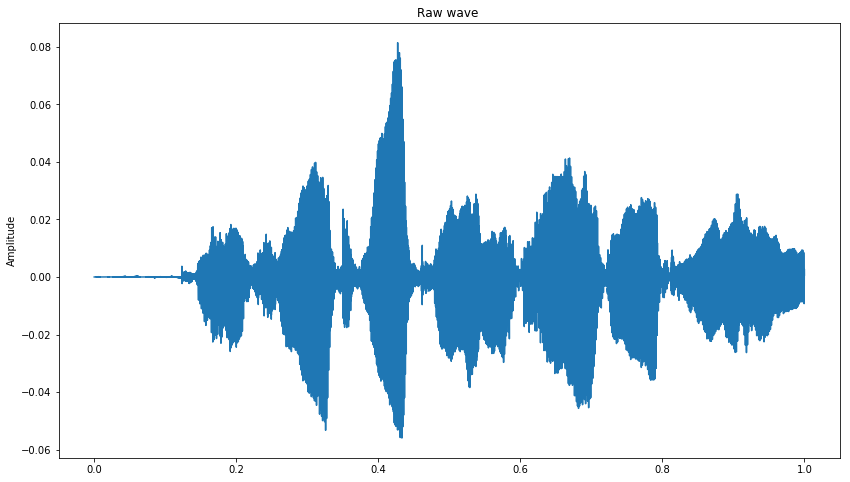

In [38]:
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

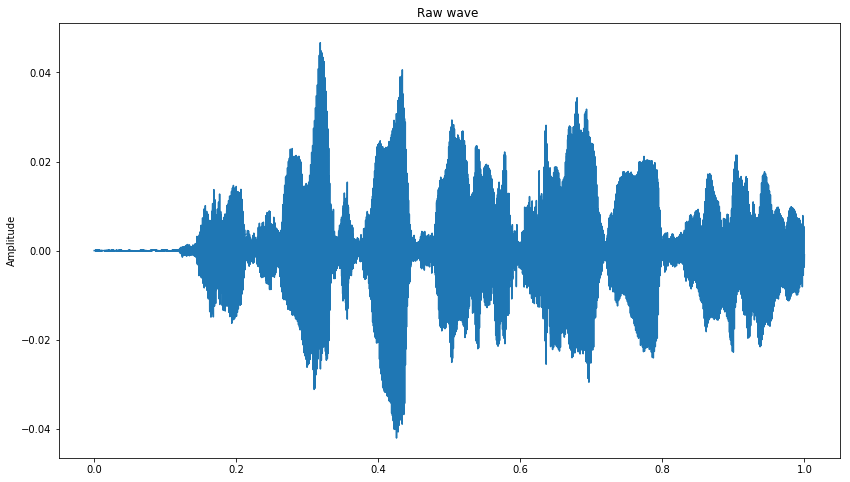

In [39]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [40]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]
        

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [01:38<00:00,  8.15it/s]


In [41]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]
        

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [08:31<00:00,  1.62it/s]


In [42]:
len(syn_data1), len(syn_data2) 

(800, 800)

In [43]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [44]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

800

In [45]:
syndf1.head()

0          1          2          3          4          5  \
0 -61.920078 -61.220244 -62.322067 -61.775916 -61.688969 -62.836432   
1 -57.721158 -55.123507 -53.067941 -55.741827 -55.857400 -54.822464   
2 -62.466070 -60.134119 -61.538021 -62.081440 -63.256823 -61.795986   
3 -68.897608 -68.868628 -67.272517 -67.746347 -67.904868 -67.022255   
4 -68.851856 -67.490619 -67.247325 -65.555171 -65.570013 -65.738487   

           6          7          8          9  ...        250        251  \
0 -63.249473 -62.082875 -61.559745 -60.062484  ... -58.546197 -59.756362   
1 -55.950613 -55.404070 -55.087911 -54.761412  ... -55.526578 -54.617210   
2 -61.136131 -62.355826 -60.940998 -61.795114  ... -59.865914 -60.895722   
3 -67.692426 -68.523103 -68.916927 -68.374147  ... -67.723046 -68.452296   
4 -68.317115 -65.936454 -63.993811 -63.210834  ... -66.262867 -67.594036   

         252        253        254        255        256        257  \
0 -61.582480 -63.090677 -62.545212 -60.698196 -61.276552 -61.643796   
1 -53.443551 -53.961489 -55.936443 -54.172586 -53.780559 -54.723865   
2 -63.057329 -63.385037 -62.313020 -63.811394 -63.316964 -63.927784   
3 -68.393548 -68.852309 -66.618496 -68.038759   0.000000   0.000000   
4 -66.693545 -63.941336 -63.940434 -64.489803 -66.292679 -66.753332   

         258          label  
0 -62.177281  male_positive  
1 -58.740636  male_positive  
2 -65.115043  male_positive  
3   0.000000  male_positive  
4 -66.503960  male_positive  

[5 rows x 260 columns]

In [46]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

800

In [47]:
syndf2.head()

0          1          2          3          4          5  \
0 -72.535069 -72.535069 -72.535069 -72.535069 -72.535069 -72.535069   
1 -71.578808 -71.480058 -71.306878 -71.578808 -71.578808 -70.161384   
2 -71.605278 -71.565580 -72.316263 -72.316263 -72.316263 -72.316263   
3 -70.956062 -70.956062 -70.956062 -70.956062 -70.956062 -70.948397   
4 -74.258629 -74.258629 -74.258629 -74.258629 -74.258629 -74.258629   

           6          7          8          9  ...        250        251  \
0 -72.535069 -72.535069 -72.535069 -72.535069  ... -72.535069 -72.535069   
1 -69.542567 -71.237882 -71.578808 -71.578808  ... -71.578808 -71.578808   
2 -72.316263 -72.316263 -72.233252 -71.146702  ... -72.316263 -72.316263   
3 -70.956062 -70.956062 -70.956062 -70.956062  ... -69.063367 -70.956062   
4 -74.258629 -74.258629 -73.737727 -74.258629  ... -74.258629 -74.258629   

         252        253        254        255        256        257  \
0 -72.326269 -71.119123 -72.326959 -72.533425 -71.933339 -71.507684   
1 -71.578808 -71.578808 -71.578808 -71.578808 -71.525054 -71.578808   
2 -72.316263 -72.316263 -72.211099 -72.316263 -72.316263 -72.316263   
3 -70.956062 -70.956062 -70.956062 -70.956062   0.000000   0.000000   
4 -74.258629 -74.258629 -74.258629 -74.258629 -74.258629 -74.258629   

         258          label  
0 -72.535069  male_positive  
1 -71.578808  male_positive  
2 -72.316263  male_positive  
3   0.000000  male_positive  
4 -74.258629  male_positive  

[5 rows x 260 columns]

In [48]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

0          1          2          3          4          5  \
0 -70.267764 -70.267764 -70.267764 -70.267764 -70.267764 -70.267764   
1 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395   
2 -69.673289 -69.693311 -69.693311 -69.693311 -69.693311 -69.693311   
3 -69.051400 -69.051400 -69.051400 -69.051400 -69.051400 -68.754863   
4 -73.841370 -73.841370 -73.841370 -73.719655 -73.841370 -73.841370   

           6          7          8          9  ...        250        251  \
0 -70.267764 -70.267764 -70.267764 -70.267764  ... -70.267764 -69.957707   
1 -65.239801 -65.536197 -67.557395 -67.557395  ... -67.557395 -67.557395   
2 -69.693311 -69.620774 -69.693311 -68.906572  ... -69.693311 -69.693311   
3 -69.051400 -69.051400 -69.051400 -68.359101  ... -68.552088 -69.051400   
4 -73.841370 -73.303635 -72.806811 -73.841370  ... -73.841370 -73.841370   

         252        253        254        255        256        257  \
0 -68.377602 -69.862569 -70.267764 -70.122135 -68.554960 -70.206530   
1 -67.557395 -67.557395 -67.557395 -67.557395 -67.557395 -67.126574   
2 -69.693311 -69.693311 -69.383522 -69.693311 -69.693311 -69.693311   
3 -69.051400 -69.051400 -68.688614 -69.051400   0.000000   0.000000   
4 -73.841370 -73.841370 -73.841370 -73.841370 -73.841370 -73.841370   

         258          label  
0 -70.267764  male_positive  
1 -67.557395  male_positive  
2 -69.693311  male_positive  
3   0.000000  male_positive  
4 -73.841370  male_positive  

[5 rows x 260 columns]

In [49]:
#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [50]:
y_train.value_counts()

male_negative    1152
male_positive     768
Name: label, dtype: int64

In [51]:
y_test.value_counts()

male_negative    288
male_positive    192
Name: label, dtype: int64

In [52]:
X_train.isna().sum().sum()

0

In [53]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [54]:
y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [55]:
X_train.shape

(1920, 259)

# VIII. Changing dimension for CNN model

In [56]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [57]:
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr



In [58]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())


# Edit according to target class no.
model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)


Instructions for updating:
Colocations handled automatically by placer.


In [59]:
# Original Model

# model = Sequential()
# model.add(Conv1D(256, 5,padding='same', input_shape=(X_train.shape[1],1)))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.1))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(5))
# model.add(Activation('softmax'))
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [60]:
# Plotting Model Summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 259, 256)          2304      
_________________________________________________________________
activation_1 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 259, 256)          524544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 259, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 259, 256)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 259, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 256)          

In [61]:
# Compile my model

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

# IX. Removed the whole training part for avoiding unnecessary long epochs list

In [63]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# set the model name accordingly.
mcp_save = ModelCheckpoint('C://Users//pranav//Desktop//SER//saved_models//Emotion_Voice_Detection_Model.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Train on 1920 samples, validate on 480 samples
Epoch 1/700
1920/1920 [==============================] - ETA: 1:06 - loss: 0.6422 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1:04 - loss: 0.6326 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:03 - loss: 0.6491 - accuracy: 0.6458 - fscore: 0.645 - ETA: 1:04 - loss: 0.6452 - accuracy: 0.6719 - fscore: 0.671 - ETA: 1:03 - loss: 0.6432 - accuracy: 0.6625 - fscore: 0.662 - ETA: 1:03 - loss: 0.6540 - accuracy: 0.6458 - fscore: 0.645 - ETA: 1:03 - loss: 0.6550 - accuracy: 0.6429 - fscore: 0.642 - ETA: 1:02 - loss: 0.6521 - accuracy: 0.6328 - fscore: 0.632 - ETA: 1:02 - loss: 0.6560 - accuracy: 0.6181 - fscore: 0.618 - ETA: 1:02 - loss: 0.6456 - accuracy: 0.6375 - fscore: 0.637 - ETA: 1:02 - loss: 0.6481 - accuracy: 0.6364 - fscore: 0.636 - ETA: 1:01 - loss: 0.6501 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1:00 - loss: 0.6504 - accuracy: 0.6250 - fscore: 0.625 - ETA: 59s - loss: 0.6466 - accuracy: 0.6384 - fscore: 0.638 - ETA: 58s - loss: 0.6455 - acc

1920/1920 [==============================] - ETA: 1:00 - loss: 0.6103 - accuracy: 0.6875 - fscore: 0.687 - ETA: 59s - loss: 0.6615 - accuracy: 0.5938 - fscore: 0.593 - ETA: 1:00 - loss: 0.6542 - accuracy: 0.6042 - fscore: 0.604 - ETA: 59s - loss: 0.6376 - accuracy: 0.6094 - fscore: 0.609 - ETA: 59s - loss: 0.6423 - accuracy: 0.6000 - fscore: 0.60 - ETA: 59s - loss: 0.6250 - accuracy: 0.6250 - fscore: 0.62 - ETA: 59s - loss: 0.6453 - accuracy: 0.6071 - fscore: 0.60 - ETA: 59s - loss: 0.6379 - accuracy: 0.6172 - fscore: 0.61 - ETA: 1:02 - loss: 0.6318 - accuracy: 0.6181 - fscore: 0.618 - ETA: 1:06 - loss: 0.6210 - accuracy: 0.6313 - fscore: 0.631 - ETA: 1:10 - loss: 0.6152 - accuracy: 0.6477 - fscore: 0.647 - ETA: 1:13 - loss: 0.6119 - accuracy: 0.6458 - fscore: 0.645 - ETA: 1:16 - loss: 0.6123 - accuracy: 0.6490 - fscore: 0.649 - ETA: 1:17 - loss: 0.6191 - accuracy: 0.6429 - fscore: 0.642 - ETA: 1:20 - loss: 0.6220 - accuracy: 0.6333 - fscore: 0.633 - ETA: 1:21 - loss: 0.6177 - accuracy

1920/1920 [==============================] - ETA: 2:37 - loss: 0.6601 - accuracy: 0.5625 - fscore: 0.562 - ETA: 2:21 - loss: 0.5855 - accuracy: 0.6562 - fscore: 0.656 - ETA: 2:13 - loss: 0.6300 - accuracy: 0.6458 - fscore: 0.645 - ETA: 2:07 - loss: 0.6007 - accuracy: 0.6875 - fscore: 0.687 - ETA: 2:08 - loss: 0.6171 - accuracy: 0.6875 - fscore: 0.687 - ETA: 2:09 - loss: 0.6261 - accuracy: 0.6562 - fscore: 0.656 - ETA: 2:08 - loss: 0.6170 - accuracy: 0.6607 - fscore: 0.660 - ETA: 2:06 - loss: 0.6104 - accuracy: 0.6719 - fscore: 0.671 - ETA: 2:02 - loss: 0.5998 - accuracy: 0.6806 - fscore: 0.680 - ETA: 2:00 - loss: 0.5966 - accuracy: 0.6812 - fscore: 0.681 - ETA: 1:57 - loss: 0.5959 - accuracy: 0.6761 - fscore: 0.676 - ETA: 1:55 - loss: 0.5893 - accuracy: 0.6719 - fscore: 0.671 - ETA: 1:53 - loss: 0.5887 - accuracy: 0.6683 - fscore: 0.668 - ETA: 1:50 - loss: 0.5932 - accuracy: 0.6562 - fscore: 0.656 - ETA: 1:49 - loss: 0.5907 - accuracy: 0.6625 - fscore: 0.662 - ETA: 1:47 - loss: 0.6059 

1920/1920 [==============================] - ETA: 1:47 - loss: 0.6657 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:45 - loss: 0.5861 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:44 - loss: 0.5305 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:43 - loss: 0.5152 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:43 - loss: 0.5049 - accuracy: 0.8250 - fscore: 0.825 - ETA: 1:44 - loss: 0.5307 - accuracy: 0.7604 - fscore: 0.760 - ETA: 1:45 - loss: 0.5286 - accuracy: 0.7679 - fscore: 0.767 - ETA: 1:44 - loss: 0.5467 - accuracy: 0.7344 - fscore: 0.734 - ETA: 1:43 - loss: 0.5633 - accuracy: 0.7083 - fscore: 0.708 - ETA: 1:42 - loss: 0.5695 - accuracy: 0.7000 - fscore: 0.700 - ETA: 1:41 - loss: 0.5813 - accuracy: 0.6818 - fscore: 0.681 - ETA: 1:43 - loss: 0.5861 - accuracy: 0.6667 - fscore: 0.666 - ETA: 1:42 - loss: 0.5912 - accuracy: 0.6731 - fscore: 0.673 - ETA: 1:42 - loss: 0.5907 - accuracy: 0.6652 - fscore: 0.665 - ETA: 1:41 - loss: 0.5995 - accuracy: 0.6542 - fscore: 0.654 - ETA: 1:41 - loss: 0.5979 

1920/1920 [==============================] - ETA: 1:52 - loss: 0.7059 - accuracy: 0.5625 - fscore: 0.562 - ETA: 1:50 - loss: 0.5968 - accuracy: 0.6562 - fscore: 0.656 - ETA: 1:47 - loss: 0.5948 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1:44 - loss: 0.6055 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1:43 - loss: 0.5897 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1:46 - loss: 0.5937 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1:47 - loss: 0.5840 - accuracy: 0.6518 - fscore: 0.651 - ETA: 1:48 - loss: 0.5815 - accuracy: 0.6641 - fscore: 0.664 - ETA: 1:49 - loss: 0.5829 - accuracy: 0.6806 - fscore: 0.680 - ETA: 1:49 - loss: 0.5951 - accuracy: 0.6687 - fscore: 0.668 - ETA: 1:49 - loss: 0.5870 - accuracy: 0.6818 - fscore: 0.681 - ETA: 1:49 - loss: 0.5831 - accuracy: 0.6823 - fscore: 0.682 - ETA: 1:48 - loss: 0.5939 - accuracy: 0.6731 - fscore: 0.673 - ETA: 1:48 - loss: 0.5908 - accuracy: 0.6741 - fscore: 0.674 - ETA: 1:47 - loss: 0.5895 - accuracy: 0.6750 - fscore: 0.675 - ETA: 1:46 - loss: 0.5836 

1920/1920 [==============================] - ETA: 1:58 - loss: 0.5864 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:56 - loss: 0.6249 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1:57 - loss: 0.5806 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:54 - loss: 0.6152 - accuracy: 0.6562 - fscore: 0.656 - ETA: 1:55 - loss: 0.6468 - accuracy: 0.6375 - fscore: 0.637 - ETA: 1:57 - loss: 0.6237 - accuracy: 0.6562 - fscore: 0.656 - ETA: 1:57 - loss: 0.6140 - accuracy: 0.6696 - fscore: 0.669 - ETA: 1:55 - loss: 0.6045 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:57 - loss: 0.6018 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:55 - loss: 0.6014 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:56 - loss: 0.6039 - accuracy: 0.6761 - fscore: 0.676 - ETA: 2:00 - loss: 0.6046 - accuracy: 0.6823 - fscore: 0.682 - ETA: 2:03 - loss: 0.6103 - accuracy: 0.6731 - fscore: 0.673 - ETA: 2:04 - loss: 0.6152 - accuracy: 0.6652 - fscore: 0.665 - ETA: 2:04 - loss: 0.6180 - accuracy: 0.6500 - fscore: 0.650 - ETA: 2:01 - loss: 0.6170 

1920/1920 [==============================] - ETA: 1:42 - loss: 0.6767 - accuracy: 0.5625 - fscore: 0.562 - ETA: 1:43 - loss: 0.6631 - accuracy: 0.5938 - fscore: 0.593 - ETA: 1:42 - loss: 0.6513 - accuracy: 0.6042 - fscore: 0.604 - ETA: 1:42 - loss: 0.6698 - accuracy: 0.6094 - fscore: 0.609 - ETA: 1:41 - loss: 0.6597 - accuracy: 0.6375 - fscore: 0.637 - ETA: 1:40 - loss: 0.6318 - accuracy: 0.6667 - fscore: 0.666 - ETA: 1:39 - loss: 0.6164 - accuracy: 0.6786 - fscore: 0.678 - ETA: 1:38 - loss: 0.6117 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:37 - loss: 0.6229 - accuracy: 0.6806 - fscore: 0.680 - ETA: 1:36 - loss: 0.6175 - accuracy: 0.6812 - fscore: 0.681 - ETA: 1:35 - loss: 0.6178 - accuracy: 0.6818 - fscore: 0.681 - ETA: 1:34 - loss: 0.6110 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:35 - loss: 0.6082 - accuracy: 0.6971 - fscore: 0.697 - ETA: 1:35 - loss: 0.6031 - accuracy: 0.6920 - fscore: 0.692 - ETA: 1:35 - loss: 0.6038 - accuracy: 0.6792 - fscore: 0.679 - ETA: 1:35 - loss: 0.6035 

1920/1920 [==============================] - ETA: 1:41 - loss: 0.5639 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:41 - loss: 0.5485 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1:40 - loss: 0.5745 - accuracy: 0.7292 - fscore: 0.729 - ETA: 1:40 - loss: 0.5905 - accuracy: 0.6719 - fscore: 0.671 - ETA: 1:40 - loss: 0.5823 - accuracy: 0.6625 - fscore: 0.662 - ETA: 1:38 - loss: 0.5615 - accuracy: 0.6979 - fscore: 0.697 - ETA: 1:38 - loss: 0.5786 - accuracy: 0.6964 - fscore: 0.696 - ETA: 1:37 - loss: 0.5803 - accuracy: 0.6719 - fscore: 0.671 - ETA: 1:37 - loss: 0.5942 - accuracy: 0.6528 - fscore: 0.652 - ETA: 1:36 - loss: 0.5807 - accuracy: 0.6625 - fscore: 0.662 - ETA: 1:35 - loss: 0.5746 - accuracy: 0.6818 - fscore: 0.681 - ETA: 1:34 - loss: 0.5835 - accuracy: 0.6667 - fscore: 0.666 - ETA: 1:34 - loss: 0.5788 - accuracy: 0.6731 - fscore: 0.673 - ETA: 1:33 - loss: 0.5745 - accuracy: 0.6786 - fscore: 0.678 - ETA: 1:32 - loss: 0.5835 - accuracy: 0.6792 - fscore: 0.679 - ETA: 1:32 - loss: 0.5852 

1920/1920 [==============================] - ETA: 1:42 - loss: 0.4972 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:41 - loss: 0.5357 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1:41 - loss: 0.5560 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:48 - loss: 0.5442 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:50 - loss: 0.5506 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2:05 - loss: 0.5661 - accuracy: 0.7292 - fscore: 0.729 - ETA: 2:07 - loss: 0.5588 - accuracy: 0.7232 - fscore: 0.723 - ETA: 2:06 - loss: 0.5595 - accuracy: 0.7266 - fscore: 0.726 - ETA: 2:03 - loss: 0.5559 - accuracy: 0.7292 - fscore: 0.729 - ETA: 2:03 - loss: 0.5686 - accuracy: 0.7000 - fscore: 0.700 - ETA: 1:59 - loss: 0.5699 - accuracy: 0.6989 - fscore: 0.698 - ETA: 1:56 - loss: 0.5653 - accuracy: 0.6927 - fscore: 0.692 - ETA: 1:54 - loss: 0.5630 - accuracy: 0.6971 - fscore: 0.697 - ETA: 1:52 - loss: 0.5593 - accuracy: 0.7098 - fscore: 0.709 - ETA: 1:51 - loss: 0.5699 - accuracy: 0.6917 - fscore: 0.691 - ETA: 1:51 - loss: 0.5657 

1920/1920 [==============================] - ETA: 1:47 - loss: 0.5839 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:46 - loss: 0.6273 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:45 - loss: 0.5826 - accuracy: 0.7292 - fscore: 0.729 - ETA: 1:43 - loss: 0.6128 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:42 - loss: 0.5777 - accuracy: 0.7250 - fscore: 0.725 - ETA: 1:41 - loss: 0.5709 - accuracy: 0.7292 - fscore: 0.729 - ETA: 1:40 - loss: 0.5773 - accuracy: 0.7232 - fscore: 0.723 - ETA: 1:41 - loss: 0.5842 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1:42 - loss: 0.5858 - accuracy: 0.7153 - fscore: 0.715 - ETA: 1:42 - loss: 0.5795 - accuracy: 0.7312 - fscore: 0.731 - ETA: 1:41 - loss: 0.5786 - accuracy: 0.7216 - fscore: 0.721 - ETA: 1:40 - loss: 0.5852 - accuracy: 0.7135 - fscore: 0.713 - ETA: 1:39 - loss: 0.5820 - accuracy: 0.7115 - fscore: 0.711 - ETA: 1:37 - loss: 0.5948 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:36 - loss: 0.5899 - accuracy: 0.6917 - fscore: 0.691 - ETA: 1:35 - loss: 0.5893 

1920/1920 [==============================] - ETA: 1:45 - loss: 0.7757 - accuracy: 0.5000 - fscore: 0.500 - ETA: 1:46 - loss: 0.6735 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1:45 - loss: 0.6775 - accuracy: 0.5625 - fscore: 0.562 - ETA: 1:43 - loss: 0.6666 - accuracy: 0.5781 - fscore: 0.578 - ETA: 1:42 - loss: 0.6436 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1:40 - loss: 0.6130 - accuracy: 0.6667 - fscore: 0.666 - ETA: 1:40 - loss: 0.6012 - accuracy: 0.6696 - fscore: 0.669 - ETA: 1:39 - loss: 0.5953 - accuracy: 0.6797 - fscore: 0.679 - ETA: 1:38 - loss: 0.5865 - accuracy: 0.6944 - fscore: 0.694 - ETA: 1:38 - loss: 0.5844 - accuracy: 0.7063 - fscore: 0.706 - ETA: 1:37 - loss: 0.5764 - accuracy: 0.7216 - fscore: 0.721 - ETA: 1:36 - loss: 0.5682 - accuracy: 0.7292 - fscore: 0.729 - ETA: 1:35 - loss: 0.5679 - accuracy: 0.7308 - fscore: 0.730 - ETA: 1:34 - loss: 0.5610 - accuracy: 0.7366 - fscore: 0.736 - ETA: 1:33 - loss: 0.5719 - accuracy: 0.7250 - fscore: 0.725 - ETA: 1:32 - loss: 0.5717 

1920/1920 [==============================] - ETA: 1:48 - loss: 0.7182 - accuracy: 0.5000 - fscore: 0.500 - ETA: 1:47 - loss: 0.6327 - accuracy: 0.5312 - fscore: 0.531 - ETA: 1:45 - loss: 0.6201 - accuracy: 0.6042 - fscore: 0.604 - ETA: 1:44 - loss: 0.5779 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:42 - loss: 0.5691 - accuracy: 0.7000 - fscore: 0.700 - ETA: 1:42 - loss: 0.5610 - accuracy: 0.7083 - fscore: 0.708 - ETA: 1:41 - loss: 0.5626 - accuracy: 0.6964 - fscore: 0.696 - ETA: 1:40 - loss: 0.5721 - accuracy: 0.6797 - fscore: 0.679 - ETA: 1:40 - loss: 0.5789 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:40 - loss: 0.5705 - accuracy: 0.7000 - fscore: 0.700 - ETA: 1:39 - loss: 0.5805 - accuracy: 0.6989 - fscore: 0.698 - ETA: 1:38 - loss: 0.5747 - accuracy: 0.7083 - fscore: 0.708 - ETA: 1:37 - loss: 0.5776 - accuracy: 0.6971 - fscore: 0.697 - ETA: 1:36 - loss: 0.5734 - accuracy: 0.7054 - fscore: 0.705 - ETA: 1:35 - loss: 0.5809 - accuracy: 0.7000 - fscore: 0.700 - ETA: 1:34 - loss: 0.5789 

1920/1920 [==============================] - ETA: 1:57 - loss: 0.5145 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:51 - loss: 0.5532 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:48 - loss: 0.5938 - accuracy: 0.6667 - fscore: 0.666 - ETA: 1:45 - loss: 0.5983 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1:44 - loss: 0.5838 - accuracy: 0.6500 - fscore: 0.650 - ETA: 1:43 - loss: 0.5692 - accuracy: 0.6771 - fscore: 0.677 - ETA: 1:42 - loss: 0.5732 - accuracy: 0.6696 - fscore: 0.669 - ETA: 1:40 - loss: 0.5706 - accuracy: 0.6719 - fscore: 0.671 - ETA: 1:40 - loss: 0.5900 - accuracy: 0.6528 - fscore: 0.652 - ETA: 1:38 - loss: 0.5765 - accuracy: 0.6625 - fscore: 0.662 - ETA: 1:37 - loss: 0.5731 - accuracy: 0.6648 - fscore: 0.664 - ETA: 1:36 - loss: 0.5617 - accuracy: 0.6823 - fscore: 0.682 - ETA: 1:35 - loss: 0.5573 - accuracy: 0.6971 - fscore: 0.697 - ETA: 1:34 - loss: 0.5545 - accuracy: 0.6964 - fscore: 0.696 - ETA: 1:33 - loss: 0.5483 - accuracy: 0.7042 - fscore: 0.704 - ETA: 1:32 - loss: 0.5468 

1920/1920 [==============================] - ETA: 1:45 - loss: 0.6285 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:45 - loss: 0.5627 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:45 - loss: 0.5293 - accuracy: 0.7708 - fscore: 0.770 - ETA: 1:43 - loss: 0.5141 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1:43 - loss: 0.5278 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:42 - loss: 0.5551 - accuracy: 0.7083 - fscore: 0.708 - ETA: 1:41 - loss: 0.5738 - accuracy: 0.6964 - fscore: 0.696 - ETA: 1:40 - loss: 0.5606 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1:40 - loss: 0.5503 - accuracy: 0.7153 - fscore: 0.715 - ETA: 1:39 - loss: 0.5540 - accuracy: 0.7125 - fscore: 0.712 - ETA: 1:38 - loss: 0.5536 - accuracy: 0.7045 - fscore: 0.704 - ETA: 1:37 - loss: 0.5490 - accuracy: 0.7083 - fscore: 0.708 - ETA: 1:36 - loss: 0.5476 - accuracy: 0.7163 - fscore: 0.716 - ETA: 1:35 - loss: 0.5417 - accuracy: 0.7143 - fscore: 0.714 - ETA: 1:34 - loss: 0.5468 - accuracy: 0.7125 - fscore: 0.712 - ETA: 1:33 - loss: 0.5471 

1920/1920 [==============================] - ETA: 2:12 - loss: 0.6331 - accuracy: 0.6250 - fscore: 0.625 - ETA: 2:08 - loss: 0.5862 - accuracy: 0.6875 - fscore: 0.687 - ETA: 2:01 - loss: 0.5700 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:58 - loss: 0.5633 - accuracy: 0.7031 - fscore: 0.703 - ETA: 1:57 - loss: 0.5640 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:55 - loss: 0.5618 - accuracy: 0.6771 - fscore: 0.677 - ETA: 1:52 - loss: 0.5608 - accuracy: 0.6786 - fscore: 0.678 - ETA: 1:51 - loss: 0.5372 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1:54 - loss: 0.5413 - accuracy: 0.7153 - fscore: 0.715 - ETA: 1:55 - loss: 0.5635 - accuracy: 0.6812 - fscore: 0.681 - ETA: 1:56 - loss: 0.5658 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:55 - loss: 0.5629 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:53 - loss: 0.5618 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:51 - loss: 0.5606 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:50 - loss: 0.5592 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:49 - loss: 0.5478 

1920/1920 [==============================] - ETA: 1:44 - loss: 0.5490 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2:02 - loss: 0.5897 - accuracy: 0.7188 - fscore: 0.718 - ETA: 2:03 - loss: 0.5687 - accuracy: 0.7292 - fscore: 0.729 - ETA: 1:57 - loss: 0.5535 - accuracy: 0.7344 - fscore: 0.734 - ETA: 1:54 - loss: 0.5854 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:51 - loss: 0.5739 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:52 - loss: 0.5740 - accuracy: 0.6964 - fscore: 0.696 - ETA: 1:51 - loss: 0.5807 - accuracy: 0.6953 - fscore: 0.695 - ETA: 1:49 - loss: 0.5714 - accuracy: 0.7014 - fscore: 0.701 - ETA: 1:47 - loss: 0.5669 - accuracy: 0.7063 - fscore: 0.706 - ETA: 1:46 - loss: 0.5574 - accuracy: 0.7102 - fscore: 0.710 - ETA: 1:45 - loss: 0.5601 - accuracy: 0.7135 - fscore: 0.713 - ETA: 1:43 - loss: 0.5578 - accuracy: 0.7212 - fscore: 0.721 - ETA: 1:42 - loss: 0.5566 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1:41 - loss: 0.5589 - accuracy: 0.7167 - fscore: 0.716 - ETA: 1:40 - loss: 0.5585 

1920/1920 [==============================] - ETA: 1:58 - loss: 0.5007 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2:00 - loss: 0.5270 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1:58 - loss: 0.5371 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:55 - loss: 0.5369 - accuracy: 0.7344 - fscore: 0.734 - ETA: 1:54 - loss: 0.5553 - accuracy: 0.7125 - fscore: 0.712 - ETA: 1:52 - loss: 0.5440 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1:50 - loss: 0.5511 - accuracy: 0.7143 - fscore: 0.714 - ETA: 1:49 - loss: 0.5493 - accuracy: 0.7109 - fscore: 0.710 - ETA: 1:50 - loss: 0.5404 - accuracy: 0.7292 - fscore: 0.729 - ETA: 1:49 - loss: 0.5363 - accuracy: 0.7312 - fscore: 0.731 - ETA: 1:48 - loss: 0.5440 - accuracy: 0.7102 - fscore: 0.710 - ETA: 1:46 - loss: 0.5364 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1:45 - loss: 0.5399 - accuracy: 0.7212 - fscore: 0.721 - ETA: 1:45 - loss: 0.5415 - accuracy: 0.7232 - fscore: 0.723 - ETA: 1:44 - loss: 0.5435 - accuracy: 0.7167 - fscore: 0.716 - ETA: 1:43 - loss: 0.5413 

1920/1920 [==============================] - ETA: 2:46 - loss: 0.5967 - accuracy: 0.5625 - fscore: 0.562 - ETA: 2:48 - loss: 0.5896 - accuracy: 0.5625 - fscore: 0.562 - ETA: 2:45 - loss: 0.6147 - accuracy: 0.6458 - fscore: 0.645 - ETA: 2:32 - loss: 0.5839 - accuracy: 0.6562 - fscore: 0.656 - ETA: 2:21 - loss: 0.5616 - accuracy: 0.6875 - fscore: 0.687 - ETA: 2:18 - loss: 0.5661 - accuracy: 0.6771 - fscore: 0.677 - ETA: 2:14 - loss: 0.5700 - accuracy: 0.6875 - fscore: 0.687 - ETA: 2:09 - loss: 0.5767 - accuracy: 0.6719 - fscore: 0.671 - ETA: 2:05 - loss: 0.5681 - accuracy: 0.6736 - fscore: 0.673 - ETA: 2:02 - loss: 0.5639 - accuracy: 0.6750 - fscore: 0.675 - ETA: 2:00 - loss: 0.5517 - accuracy: 0.7045 - fscore: 0.704 - ETA: 1:57 - loss: 0.5528 - accuracy: 0.7083 - fscore: 0.708 - ETA: 1:54 - loss: 0.5438 - accuracy: 0.7115 - fscore: 0.711 - ETA: 1:53 - loss: 0.5429 - accuracy: 0.7054 - fscore: 0.705 - ETA: 1:52 - loss: 0.5363 - accuracy: 0.7167 - fscore: 0.716 - ETA: 1:51 - loss: 0.5287 

1920/1920 [==============================] - ETA: 1:51 - loss: 0.6336 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:48 - loss: 0.5481 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:47 - loss: 0.5221 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:45 - loss: 0.5194 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1:45 - loss: 0.5088 - accuracy: 0.7875 - fscore: 0.787 - ETA: 1:45 - loss: 0.5201 - accuracy: 0.7708 - fscore: 0.770 - ETA: 1:45 - loss: 0.5141 - accuracy: 0.7857 - fscore: 0.785 - ETA: 1:47 - loss: 0.5038 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1:46 - loss: 0.5028 - accuracy: 0.7847 - fscore: 0.784 - ETA: 1:45 - loss: 0.5064 - accuracy: 0.7875 - fscore: 0.787 - ETA: 1:44 - loss: 0.5028 - accuracy: 0.7898 - fscore: 0.789 - ETA: 1:43 - loss: 0.4934 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1:42 - loss: 0.4956 - accuracy: 0.7933 - fscore: 0.793 - ETA: 1:41 - loss: 0.4946 - accuracy: 0.7946 - fscore: 0.794 - ETA: 1:43 - loss: 0.4943 - accuracy: 0.7917 - fscore: 0.791 - ETA: 1:44 - loss: 0.5065 

1920/1920 [==============================] - ETA: 2:04 - loss: 0.5049 - accuracy: 0.8125 - fscore: 0.812 - ETA: 2:03 - loss: 0.5235 - accuracy: 0.7812 - fscore: 0.781 - ETA: 2:04 - loss: 0.5251 - accuracy: 0.7708 - fscore: 0.770 - ETA: 2:02 - loss: 0.5499 - accuracy: 0.7344 - fscore: 0.734 - ETA: 2:02 - loss: 0.5468 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2:02 - loss: 0.5315 - accuracy: 0.7708 - fscore: 0.770 - ETA: 2:00 - loss: 0.5259 - accuracy: 0.7679 - fscore: 0.767 - ETA: 1:59 - loss: 0.5114 - accuracy: 0.7891 - fscore: 0.789 - ETA: 1:58 - loss: 0.5086 - accuracy: 0.7986 - fscore: 0.798 - ETA: 2:02 - loss: 0.5128 - accuracy: 0.7875 - fscore: 0.787 - ETA: 2:05 - loss: 0.5105 - accuracy: 0.7955 - fscore: 0.795 - ETA: 2:05 - loss: 0.5201 - accuracy: 0.7812 - fscore: 0.781 - ETA: 2:03 - loss: 0.5240 - accuracy: 0.7740 - fscore: 0.774 - ETA: 2:03 - loss: 0.5272 - accuracy: 0.7589 - fscore: 0.758 - ETA: 2:02 - loss: 0.5403 - accuracy: 0.7417 - fscore: 0.741 - ETA: 1:59 - loss: 0.5361 

1920/1920 [==============================] - ETA: 2:24 - loss: 0.6179 - accuracy: 0.6875 - fscore: 0.687 - ETA: 2:13 - loss: 0.4980 - accuracy: 0.7812 - fscore: 0.781 - ETA: 2:08 - loss: 0.4917 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2:05 - loss: 0.4548 - accuracy: 0.7812 - fscore: 0.781 - ETA: 2:03 - loss: 0.5074 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2:03 - loss: 0.5113 - accuracy: 0.7396 - fscore: 0.739 - ETA: 2:00 - loss: 0.4913 - accuracy: 0.7589 - fscore: 0.758 - ETA: 1:57 - loss: 0.4960 - accuracy: 0.7656 - fscore: 0.765 - ETA: 1:54 - loss: 0.5062 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:51 - loss: 0.5064 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:51 - loss: 0.5101 - accuracy: 0.7386 - fscore: 0.738 - ETA: 1:50 - loss: 0.5100 - accuracy: 0.7448 - fscore: 0.744 - ETA: 1:51 - loss: 0.5088 - accuracy: 0.7452 - fscore: 0.745 - ETA: 1:50 - loss: 0.4985 - accuracy: 0.7634 - fscore: 0.763 - ETA: 1:49 - loss: 0.4979 - accuracy: 0.7625 - fscore: 0.762 - ETA: 1:47 - loss: 0.5027 

1920/1920 [==============================] - ETA: 1:09 - loss: 0.6233 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1:09 - loss: 0.6199 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1:10 - loss: 0.6210 - accuracy: 0.6458 - fscore: 0.645 - ETA: 1:10 - loss: 0.6265 - accuracy: 0.6406 - fscore: 0.640 - ETA: 1:11 - loss: 0.5829 - accuracy: 0.6750 - fscore: 0.675 - ETA: 1:10 - loss: 0.5536 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1:10 - loss: 0.5511 - accuracy: 0.7054 - fscore: 0.705 - ETA: 1:09 - loss: 0.5479 - accuracy: 0.7031 - fscore: 0.703 - ETA: 1:08 - loss: 0.5378 - accuracy: 0.7222 - fscore: 0.722 - ETA: 1:08 - loss: 0.5401 - accuracy: 0.7063 - fscore: 0.706 - ETA: 1:08 - loss: 0.5629 - accuracy: 0.6932 - fscore: 0.693 - ETA: 1:07 - loss: 0.5595 - accuracy: 0.6979 - fscore: 0.697 - ETA: 1:06 - loss: 0.5605 - accuracy: 0.6923 - fscore: 0.692 - ETA: 1:06 - loss: 0.5612 - accuracy: 0.6964 - fscore: 0.696 - ETA: 1:05 - loss: 0.5553 - accuracy: 0.6958 - fscore: 0.695 - ETA: 1:05 - loss: 0.5537 

1920/1920 [==============================] - ETA: 2:23 - loss: 0.5857 - accuracy: 0.6875 - fscore: 0.687 - ETA: 2:12 - loss: 0.4703 - accuracy: 0.8125 - fscore: 0.812 - ETA: 2:06 - loss: 0.4538 - accuracy: 0.8333 - fscore: 0.833 - ETA: 1:51 - loss: 0.4509 - accuracy: 0.8281 - fscore: 0.828 - ETA: 1:42 - loss: 0.4905 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:36 - loss: 0.4883 - accuracy: 0.7708 - fscore: 0.770 - ETA: 1:32 - loss: 0.5009 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:28 - loss: 0.5341 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1:25 - loss: 0.5273 - accuracy: 0.7431 - fscore: 0.743 - ETA: 1:23 - loss: 0.5140 - accuracy: 0.7563 - fscore: 0.756 - ETA: 1:22 - loss: 0.5270 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:19 - loss: 0.5191 - accuracy: 0.7552 - fscore: 0.755 - ETA: 1:18 - loss: 0.5141 - accuracy: 0.7692 - fscore: 0.769 - ETA: 1:17 - loss: 0.5217 - accuracy: 0.7589 - fscore: 0.758 - ETA: 1:15 - loss: 0.5188 - accuracy: 0.7583 - fscore: 0.758 - ETA: 1:14 - loss: 0.5098 

1920/1920 [==============================] - ETA: 2:02 - loss: 0.4919 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:55 - loss: 0.4288 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:45 - loss: 0.4771 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:33 - loss: 0.4887 - accuracy: 0.8281 - fscore: 0.828 - ETA: 1:27 - loss: 0.4686 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:22 - loss: 0.4712 - accuracy: 0.8333 - fscore: 0.833 - ETA: 1:18 - loss: 0.4839 - accuracy: 0.8214 - fscore: 0.821 - ETA: 1:15 - loss: 0.4893 - accuracy: 0.8281 - fscore: 0.828 - ETA: 1:13 - loss: 0.4835 - accuracy: 0.8264 - fscore: 0.826 - ETA: 1:12 - loss: 0.4813 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:11 - loss: 0.4839 - accuracy: 0.8068 - fscore: 0.806 - ETA: 1:10 - loss: 0.4861 - accuracy: 0.8021 - fscore: 0.802 - ETA: 1:09 - loss: 0.4828 - accuracy: 0.8077 - fscore: 0.807 - ETA: 1:09 - loss: 0.4885 - accuracy: 0.7991 - fscore: 0.799 - ETA: 1:08 - loss: 0.4883 - accuracy: 0.8000 - fscore: 0.800 - ETA: 1:07 - loss: 0.5003 

1920/1920 [==============================] - ETA: 2:05 - loss: 0.6890 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:57 - loss: 0.5687 - accuracy: 0.7812 - fscore: 0.781 - ETA: 2:04 - loss: 0.5207 - accuracy: 0.7708 - fscore: 0.770 - ETA: 2:03 - loss: 0.5011 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1:58 - loss: 0.4905 - accuracy: 0.8000 - fscore: 0.800 - ETA: 1:55 - loss: 0.5028 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1:55 - loss: 0.5112 - accuracy: 0.7768 - fscore: 0.776 - ETA: 1:55 - loss: 0.5163 - accuracy: 0.7656 - fscore: 0.765 - ETA: 1:54 - loss: 0.5150 - accuracy: 0.7639 - fscore: 0.763 - ETA: 1:54 - loss: 0.5284 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:53 - loss: 0.5255 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:51 - loss: 0.5204 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:51 - loss: 0.5270 - accuracy: 0.7452 - fscore: 0.745 - ETA: 1:49 - loss: 0.5302 - accuracy: 0.7366 - fscore: 0.736 - ETA: 1:47 - loss: 0.5300 - accuracy: 0.7417 - fscore: 0.741 - ETA: 1:46 - loss: 0.5317 

1920/1920 [==============================] - ETA: 2:03 - loss: 0.4629 - accuracy: 0.8750 - fscore: 0.875 - ETA: 2:04 - loss: 0.4488 - accuracy: 0.8750 - fscore: 0.875 - ETA: 2:01 - loss: 0.4707 - accuracy: 0.8125 - fscore: 0.812 - ETA: 2:01 - loss: 0.4661 - accuracy: 0.7969 - fscore: 0.796 - ETA: 2:00 - loss: 0.4660 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:58 - loss: 0.4750 - accuracy: 0.8021 - fscore: 0.802 - ETA: 1:57 - loss: 0.4864 - accuracy: 0.7946 - fscore: 0.794 - ETA: 1:55 - loss: 0.4995 - accuracy: 0.7891 - fscore: 0.789 - ETA: 1:55 - loss: 0.5036 - accuracy: 0.7847 - fscore: 0.784 - ETA: 1:55 - loss: 0.5007 - accuracy: 0.7875 - fscore: 0.787 - ETA: 1:54 - loss: 0.5042 - accuracy: 0.7784 - fscore: 0.778 - ETA: 1:52 - loss: 0.5290 - accuracy: 0.7604 - fscore: 0.760 - ETA: 1:51 - loss: 0.5188 - accuracy: 0.7692 - fscore: 0.769 - ETA: 1:50 - loss: 0.5147 - accuracy: 0.7634 - fscore: 0.763 - ETA: 1:50 - loss: 0.5109 - accuracy: 0.7667 - fscore: 0.766 - ETA: 1:50 - loss: 0.5043 

1920/1920 [==============================] - ETA: 2:22 - loss: 0.4643 - accuracy: 0.8125 - fscore: 0.812 - ETA: 2:20 - loss: 0.5269 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2:15 - loss: 0.5243 - accuracy: 0.7708 - fscore: 0.770 - ETA: 2:21 - loss: 0.5324 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2:16 - loss: 0.5134 - accuracy: 0.7750 - fscore: 0.775 - ETA: 2:12 - loss: 0.4969 - accuracy: 0.7917 - fscore: 0.791 - ETA: 2:08 - loss: 0.4873 - accuracy: 0.7857 - fscore: 0.785 - ETA: 2:06 - loss: 0.4841 - accuracy: 0.7891 - fscore: 0.789 - ETA: 2:02 - loss: 0.4855 - accuracy: 0.7847 - fscore: 0.784 - ETA: 2:01 - loss: 0.5132 - accuracy: 0.7688 - fscore: 0.768 - ETA: 1:58 - loss: 0.5075 - accuracy: 0.7670 - fscore: 0.767 - ETA: 1:56 - loss: 0.5124 - accuracy: 0.7604 - fscore: 0.760 - ETA: 1:55 - loss: 0.5086 - accuracy: 0.7692 - fscore: 0.769 - ETA: 1:54 - loss: 0.5030 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1:52 - loss: 0.4980 - accuracy: 0.7833 - fscore: 0.783 - ETA: 1:50 - loss: 0.5064 

1920/1920 [==============================] - ETA: 2:04 - loss: 0.5261 - accuracy: 0.6875 - fscore: 0.687 - ETA: 2:03 - loss: 0.4665 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2:03 - loss: 0.4548 - accuracy: 0.7708 - fscore: 0.770 - ETA: 2:02 - loss: 0.4699 - accuracy: 0.7656 - fscore: 0.765 - ETA: 2:01 - loss: 0.4565 - accuracy: 0.7750 - fscore: 0.775 - ETA: 1:57 - loss: 0.4435 - accuracy: 0.8021 - fscore: 0.802 - ETA: 1:56 - loss: 0.4958 - accuracy: 0.7679 - fscore: 0.767 - ETA: 1:55 - loss: 0.4921 - accuracy: 0.7578 - fscore: 0.757 - ETA: 1:55 - loss: 0.4804 - accuracy: 0.7639 - fscore: 0.763 - ETA: 1:54 - loss: 0.4656 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1:53 - loss: 0.4679 - accuracy: 0.7841 - fscore: 0.784 - ETA: 1:52 - loss: 0.4755 - accuracy: 0.7760 - fscore: 0.776 - ETA: 1:51 - loss: 0.4861 - accuracy: 0.7644 - fscore: 0.764 - ETA: 1:49 - loss: 0.4792 - accuracy: 0.7768 - fscore: 0.776 - ETA: 1:48 - loss: 0.4825 - accuracy: 0.7750 - fscore: 0.775 - ETA: 1:46 - loss: 0.4912 

1920/1920 [==============================] - ETA: 2:10 - loss: 0.4318 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:59 - loss: 0.5488 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:56 - loss: 0.5198 - accuracy: 0.7917 - fscore: 0.791 - ETA: 1:53 - loss: 0.5149 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1:50 - loss: 0.4841 - accuracy: 0.7875 - fscore: 0.787 - ETA: 1:51 - loss: 0.4964 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:51 - loss: 0.4917 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:51 - loss: 0.4814 - accuracy: 0.7578 - fscore: 0.757 - ETA: 1:51 - loss: 0.4664 - accuracy: 0.7778 - fscore: 0.777 - ETA: 1:50 - loss: 0.4641 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1:51 - loss: 0.4627 - accuracy: 0.7784 - fscore: 0.778 - ETA: 1:52 - loss: 0.4559 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1:51 - loss: 0.4443 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:49 - loss: 0.4530 - accuracy: 0.8036 - fscore: 0.803 - ETA: 1:47 - loss: 0.4529 - accuracy: 0.8042 - fscore: 0.804 - ETA: 1:46 - loss: 0.4577 

1920/1920 [==============================] - ETA: 1:57 - loss: 0.4252 - accuracy: 0.8125 - fscore: 0.812 - ETA: 2:03 - loss: 0.3793 - accuracy: 0.8750 - fscore: 0.875 - ETA: 2:00 - loss: 0.3761 - accuracy: 0.8333 - fscore: 0.833 - ETA: 1:56 - loss: 0.4279 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:53 - loss: 0.4557 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:54 - loss: 0.4462 - accuracy: 0.7604 - fscore: 0.760 - ETA: 1:53 - loss: 0.4473 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:51 - loss: 0.4487 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:49 - loss: 0.4759 - accuracy: 0.7292 - fscore: 0.729 - ETA: 1:49 - loss: 0.4920 - accuracy: 0.7125 - fscore: 0.712 - ETA: 1:48 - loss: 0.5078 - accuracy: 0.7102 - fscore: 0.710 - ETA: 1:46 - loss: 0.5043 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1:45 - loss: 0.5060 - accuracy: 0.7163 - fscore: 0.716 - ETA: 1:43 - loss: 0.5127 - accuracy: 0.7143 - fscore: 0.714 - ETA: 1:43 - loss: 0.5076 - accuracy: 0.7167 - fscore: 0.716 - ETA: 1:42 - loss: 0.5141 

1920/1920 [==============================] - ETA: 1:50 - loss: 0.7185 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1:51 - loss: 0.5761 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1:58 - loss: 0.5602 - accuracy: 0.7292 - fscore: 0.729 - ETA: 2:03 - loss: 0.5462 - accuracy: 0.7188 - fscore: 0.718 - ETA: 2:04 - loss: 0.5301 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2:04 - loss: 0.5062 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2:06 - loss: 0.5065 - accuracy: 0.7589 - fscore: 0.758 - ETA: 2:05 - loss: 0.5324 - accuracy: 0.7344 - fscore: 0.734 - ETA: 2:04 - loss: 0.5289 - accuracy: 0.7431 - fscore: 0.743 - ETA: 2:04 - loss: 0.5074 - accuracy: 0.7625 - fscore: 0.762 - ETA: 2:01 - loss: 0.5030 - accuracy: 0.7727 - fscore: 0.772 - ETA: 2:00 - loss: 0.4887 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1:57 - loss: 0.4819 - accuracy: 0.7837 - fscore: 0.783 - ETA: 1:56 - loss: 0.4706 - accuracy: 0.7946 - fscore: 0.794 - ETA: 1:54 - loss: 0.4614 - accuracy: 0.8000 - fscore: 0.800 - ETA: 1:54 - loss: 0.4584 

1920/1920 [==============================] - ETA: 1:43 - loss: 0.5209 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:43 - loss: 0.4436 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:42 - loss: 0.4247 - accuracy: 0.7917 - fscore: 0.791 - ETA: 1:41 - loss: 0.4218 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1:41 - loss: 0.4292 - accuracy: 0.8000 - fscore: 0.800 - ETA: 1:40 - loss: 0.4067 - accuracy: 0.8229 - fscore: 0.822 - ETA: 1:41 - loss: 0.4117 - accuracy: 0.8214 - fscore: 0.821 - ETA: 1:41 - loss: 0.4210 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:42 - loss: 0.4178 - accuracy: 0.8194 - fscore: 0.819 - ETA: 1:44 - loss: 0.4137 - accuracy: 0.8313 - fscore: 0.831 - ETA: 1:44 - loss: 0.4172 - accuracy: 0.8295 - fscore: 0.829 - ETA: 1:43 - loss: 0.4248 - accuracy: 0.8229 - fscore: 0.822 - ETA: 1:50 - loss: 0.4323 - accuracy: 0.8173 - fscore: 0.817 - ETA: 1:53 - loss: 0.4397 - accuracy: 0.8080 - fscore: 0.808 - ETA: 1:54 - loss: 0.4355 - accuracy: 0.8083 - fscore: 0.808 - ETA: 1:54 - loss: 0.4297 

1920/1920 [==============================] - ETA: 1:50 - loss: 0.4274 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:48 - loss: 0.4704 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:48 - loss: 0.4570 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:48 - loss: 0.4513 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1:46 - loss: 0.4483 - accuracy: 0.8000 - fscore: 0.800 - ETA: 1:47 - loss: 0.4415 - accuracy: 0.8021 - fscore: 0.802 - ETA: 1:46 - loss: 0.4438 - accuracy: 0.8214 - fscore: 0.821 - ETA: 1:46 - loss: 0.4488 - accuracy: 0.8047 - fscore: 0.804 - ETA: 1:45 - loss: 0.4465 - accuracy: 0.8056 - fscore: 0.805 - ETA: 1:45 - loss: 0.4463 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:45 - loss: 0.4588 - accuracy: 0.8011 - fscore: 0.801 - ETA: 1:44 - loss: 0.4595 - accuracy: 0.7917 - fscore: 0.791 - ETA: 1:43 - loss: 0.4519 - accuracy: 0.8077 - fscore: 0.807 - ETA: 1:42 - loss: 0.4569 - accuracy: 0.8036 - fscore: 0.803 - ETA: 1:42 - loss: 0.4639 - accuracy: 0.8042 - fscore: 0.804 - ETA: 1:41 - loss: 0.4584 

1920/1920 [==============================] - ETA: 1:51 - loss: 0.5618 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:49 - loss: 0.5698 - accuracy: 0.6562 - fscore: 0.656 - ETA: 2:00 - loss: 0.5462 - accuracy: 0.6667 - fscore: 0.666 - ETA: 1:57 - loss: 0.4979 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1:58 - loss: 0.5018 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2:00 - loss: 0.4689 - accuracy: 0.7708 - fscore: 0.770 - ETA: 2:10 - loss: 0.4524 - accuracy: 0.7946 - fscore: 0.794 - ETA: 2:14 - loss: 0.4562 - accuracy: 0.7969 - fscore: 0.796 - ETA: 2:14 - loss: 0.4493 - accuracy: 0.7986 - fscore: 0.798 - ETA: 2:11 - loss: 0.4482 - accuracy: 0.8000 - fscore: 0.800 - ETA: 2:08 - loss: 0.4522 - accuracy: 0.7955 - fscore: 0.795 - ETA: 2:05 - loss: 0.4495 - accuracy: 0.8073 - fscore: 0.807 - ETA: 2:04 - loss: 0.4432 - accuracy: 0.8173 - fscore: 0.817 - ETA: 2:01 - loss: 0.4486 - accuracy: 0.8036 - fscore: 0.803 - ETA: 2:01 - loss: 0.4407 - accuracy: 0.8083 - fscore: 0.808 - ETA: 2:00 - loss: 0.4339 

1920/1920 [==============================] - ETA: 1:43 - loss: 0.4729 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:50 - loss: 0.4666 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:49 - loss: 0.4224 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:48 - loss: 0.4023 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:46 - loss: 0.4498 - accuracy: 0.7750 - fscore: 0.775 - ETA: 1:45 - loss: 0.4414 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1:44 - loss: 0.4449 - accuracy: 0.7768 - fscore: 0.776 - ETA: 1:44 - loss: 0.4307 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1:43 - loss: 0.4327 - accuracy: 0.7986 - fscore: 0.798 - ETA: 1:41 - loss: 0.4340 - accuracy: 0.8062 - fscore: 0.806 - ETA: 1:40 - loss: 0.4513 - accuracy: 0.7784 - fscore: 0.778 - ETA: 1:40 - loss: 0.4561 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1:41 - loss: 0.4467 - accuracy: 0.7885 - fscore: 0.788 - ETA: 1:41 - loss: 0.4399 - accuracy: 0.8036 - fscore: 0.803 - ETA: 1:39 - loss: 0.4431 - accuracy: 0.8042 - fscore: 0.804 - ETA: 1:38 - loss: 0.4372 

1920/1920 [==============================] - ETA: 1:06 - loss: 0.6057 - accuracy: 0.5625 - fscore: 0.562 - ETA: 1:07 - loss: 0.6009 - accuracy: 0.5312 - fscore: 0.531 - ETA: 1:05 - loss: 0.5644 - accuracy: 0.6042 - fscore: 0.604 - ETA: 1:05 - loss: 0.5483 - accuracy: 0.6406 - fscore: 0.640 - ETA: 1:04 - loss: 0.5333 - accuracy: 0.6750 - fscore: 0.675 - ETA: 1:02 - loss: 0.5031 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1:01 - loss: 0.5074 - accuracy: 0.7143 - fscore: 0.714 - ETA: 1:00 - loss: 0.5101 - accuracy: 0.7266 - fscore: 0.726 - ETA: 59s - loss: 0.5073 - accuracy: 0.7361 - fscore: 0.736 - ETA: 59s - loss: 0.5012 - accuracy: 0.7437 - fscore: 0.74 - ETA: 58s - loss: 0.4832 - accuracy: 0.7614 - fscore: 0.76 - ETA: 58s - loss: 0.4789 - accuracy: 0.7708 - fscore: 0.77 - ETA: 57s - loss: 0.4825 - accuracy: 0.7644 - fscore: 0.76 - ETA: 57s - loss: 0.4700 - accuracy: 0.7812 - fscore: 0.78 - ETA: 56s - loss: 0.4724 - accuracy: 0.7833 - fscore: 0.78 - ETA: 55s - loss: 0.4683 - accuracy: 0.

1920/1920 [==============================] - ETA: 2:06 - loss: 0.3252 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.4067 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:55 - loss: 0.3584 - accuracy: 0.8958 - fscore: 0.895 - ETA: 1:53 - loss: 0.3532 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:53 - loss: 0.3880 - accuracy: 0.8250 - fscore: 0.825 - ETA: 1:53 - loss: 0.3805 - accuracy: 0.8333 - fscore: 0.833 - ETA: 1:52 - loss: 0.3975 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:51 - loss: 0.4010 - accuracy: 0.8203 - fscore: 0.820 - ETA: 1:50 - loss: 0.4164 - accuracy: 0.8194 - fscore: 0.819 - ETA: 1:48 - loss: 0.4146 - accuracy: 0.8250 - fscore: 0.825 - ETA: 1:47 - loss: 0.4120 - accuracy: 0.8239 - fscore: 0.823 - ETA: 1:45 - loss: 0.4080 - accuracy: 0.8281 - fscore: 0.828 - ETA: 1:44 - loss: 0.4125 - accuracy: 0.8173 - fscore: 0.817 - ETA: 1:43 - loss: 0.4149 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:41 - loss: 0.4107 - accuracy: 0.8208 - fscore: 0.820 - ETA: 1:41 - loss: 0.4137 

1920/1920 [==============================] - ETA: 1:55 - loss: 0.4938 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:53 - loss: 0.5294 - accuracy: 0.6562 - fscore: 0.656 - ETA: 1:53 - loss: 0.5116 - accuracy: 0.7292 - fscore: 0.729 - ETA: 1:51 - loss: 0.4611 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1:51 - loss: 0.4550 - accuracy: 0.7875 - fscore: 0.787 - ETA: 1:56 - loss: 0.4504 - accuracy: 0.7917 - fscore: 0.791 - ETA: 2:04 - loss: 0.4499 - accuracy: 0.7857 - fscore: 0.785 - ETA: 2:04 - loss: 0.4526 - accuracy: 0.7812 - fscore: 0.781 - ETA: 2:04 - loss: 0.4292 - accuracy: 0.7986 - fscore: 0.798 - ETA: 2:04 - loss: 0.4332 - accuracy: 0.7812 - fscore: 0.781 - ETA: 2:02 - loss: 0.4328 - accuracy: 0.7841 - fscore: 0.784 - ETA: 1:59 - loss: 0.4440 - accuracy: 0.7760 - fscore: 0.776 - ETA: 1:57 - loss: 0.4377 - accuracy: 0.7837 - fscore: 0.783 - ETA: 1:55 - loss: 0.4495 - accuracy: 0.7768 - fscore: 0.776 - ETA: 1:53 - loss: 0.4421 - accuracy: 0.7875 - fscore: 0.787 - ETA: 1:54 - loss: 0.4359 

1920/1920 [==============================] - ETA: 1:56 - loss: 0.4719 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:53 - loss: 0.4248 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:53 - loss: 0.4165 - accuracy: 0.8542 - fscore: 0.854 - ETA: 1:52 - loss: 0.4251 - accuracy: 0.8281 - fscore: 0.828 - ETA: 1:51 - loss: 0.4254 - accuracy: 0.8250 - fscore: 0.825 - ETA: 1:49 - loss: 0.4213 - accuracy: 0.8229 - fscore: 0.822 - ETA: 1:48 - loss: 0.4141 - accuracy: 0.8304 - fscore: 0.830 - ETA: 1:47 - loss: 0.4217 - accuracy: 0.8281 - fscore: 0.828 - ETA: 1:47 - loss: 0.4203 - accuracy: 0.8333 - fscore: 0.833 - ETA: 1:45 - loss: 0.4117 - accuracy: 0.8375 - fscore: 0.837 - ETA: 1:44 - loss: 0.4136 - accuracy: 0.8239 - fscore: 0.823 - ETA: 1:43 - loss: 0.4268 - accuracy: 0.8229 - fscore: 0.822 - ETA: 1:43 - loss: 0.4340 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:42 - loss: 0.4343 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:41 - loss: 0.4347 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:41 - loss: 0.4305 

1920/1920 [==============================] - ETA: 2:14 - loss: 0.4139 - accuracy: 0.8125 - fscore: 0.812 - ETA: 2:18 - loss: 0.3403 - accuracy: 0.9062 - fscore: 0.906 - ETA: 2:07 - loss: 0.3407 - accuracy: 0.8958 - fscore: 0.895 - ETA: 2:01 - loss: 0.3624 - accuracy: 0.8594 - fscore: 0.859 - ETA: 1:56 - loss: 0.3727 - accuracy: 0.8375 - fscore: 0.837 - ETA: 1:53 - loss: 0.3823 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:52 - loss: 0.4197 - accuracy: 0.8304 - fscore: 0.830 - ETA: 1:49 - loss: 0.4155 - accuracy: 0.8359 - fscore: 0.835 - ETA: 1:46 - loss: 0.4127 - accuracy: 0.8403 - fscore: 0.840 - ETA: 1:44 - loss: 0.4287 - accuracy: 0.8188 - fscore: 0.818 - ETA: 1:43 - loss: 0.4385 - accuracy: 0.8068 - fscore: 0.806 - ETA: 1:41 - loss: 0.4372 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:39 - loss: 0.4323 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:38 - loss: 0.4452 - accuracy: 0.7902 - fscore: 0.790 - ETA: 1:36 - loss: 0.4416 - accuracy: 0.7958 - fscore: 0.795 - ETA: 1:35 - loss: 0.4409 

1920/1920 [==============================] - ETA: 1:59 - loss: 0.3186 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:57 - loss: 0.3541 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:51 - loss: 0.3643 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:47 - loss: 0.3761 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:44 - loss: 0.3628 - accuracy: 0.8875 - fscore: 0.887 - ETA: 1:42 - loss: 0.4002 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:43 - loss: 0.4093 - accuracy: 0.8304 - fscore: 0.830 - ETA: 1:43 - loss: 0.3978 - accuracy: 0.8359 - fscore: 0.835 - ETA: 1:47 - loss: 0.3956 - accuracy: 0.8403 - fscore: 0.840 - ETA: 1:47 - loss: 0.3934 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:45 - loss: 0.4034 - accuracy: 0.8239 - fscore: 0.823 - ETA: 1:43 - loss: 0.4083 - accuracy: 0.8229 - fscore: 0.822 - ETA: 1:41 - loss: 0.4036 - accuracy: 0.8317 - fscore: 0.831 - ETA: 1:39 - loss: 0.4021 - accuracy: 0.8304 - fscore: 0.830 - ETA: 1:38 - loss: 0.3949 - accuracy: 0.8375 - fscore: 0.837 - ETA: 1:38 - loss: 0.3915 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.5422 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1:53 - loss: 0.4522 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1:55 - loss: 0.4359 - accuracy: 0.8333 - fscore: 0.833 - ETA: 1:57 - loss: 0.4194 - accuracy: 0.8438 - fscore: 0.843 - ETA: 2:00 - loss: 0.4202 - accuracy: 0.8500 - fscore: 0.850 - ETA: 2:00 - loss: 0.4070 - accuracy: 0.8646 - fscore: 0.864 - ETA: 1:59 - loss: 0.3938 - accuracy: 0.8571 - fscore: 0.857 - ETA: 1:57 - loss: 0.3773 - accuracy: 0.8672 - fscore: 0.867 - ETA: 1:55 - loss: 0.3695 - accuracy: 0.8681 - fscore: 0.868 - ETA: 1:56 - loss: 0.3700 - accuracy: 0.8687 - fscore: 0.868 - ETA: 1:57 - loss: 0.3751 - accuracy: 0.8693 - fscore: 0.869 - ETA: 1:57 - loss: 0.3791 - accuracy: 0.8594 - fscore: 0.859 - ETA: 1:55 - loss: 0.3866 - accuracy: 0.8606 - fscore: 0.860 - ETA: 1:54 - loss: 0.3838 - accuracy: 0.8661 - fscore: 0.866 - ETA: 1:52 - loss: 0.3833 - accuracy: 0.8583 - fscore: 0.858 - ETA: 1:51 - loss: 0.3894 

1920/1920 [==============================] - ETA: 2:03 - loss: 0.6254 - accuracy: 0.5625 - fscore: 0.562 - ETA: 2:21 - loss: 0.5493 - accuracy: 0.6875 - fscore: 0.687 - ETA: 2:13 - loss: 0.4906 - accuracy: 0.7292 - fscore: 0.729 - ETA: 2:11 - loss: 0.4723 - accuracy: 0.7188 - fscore: 0.718 - ETA: 2:09 - loss: 0.4875 - accuracy: 0.7000 - fscore: 0.700 - ETA: 2:08 - loss: 0.4747 - accuracy: 0.7188 - fscore: 0.718 - ETA: 2:04 - loss: 0.4681 - accuracy: 0.7232 - fscore: 0.723 - ETA: 2:01 - loss: 0.4410 - accuracy: 0.7578 - fscore: 0.757 - ETA: 1:57 - loss: 0.4295 - accuracy: 0.7778 - fscore: 0.777 - ETA: 1:55 - loss: 0.4117 - accuracy: 0.8000 - fscore: 0.800 - ETA: 1:52 - loss: 0.4106 - accuracy: 0.8068 - fscore: 0.806 - ETA: 1:50 - loss: 0.4051 - accuracy: 0.8177 - fscore: 0.817 - ETA: 1:48 - loss: 0.4059 - accuracy: 0.8173 - fscore: 0.817 - ETA: 1:47 - loss: 0.4133 - accuracy: 0.8036 - fscore: 0.803 - ETA: 1:48 - loss: 0.4117 - accuracy: 0.8083 - fscore: 0.808 - ETA: 1:48 - loss: 0.4069 

1920/1920 [==============================] - ETA: 2:25 - loss: 0.4883 - accuracy: 0.8125 - fscore: 0.812 - ETA: 2:19 - loss: 0.4592 - accuracy: 0.8125 - fscore: 0.812 - ETA: 2:20 - loss: 0.4369 - accuracy: 0.8542 - fscore: 0.854 - ETA: 2:31 - loss: 0.4665 - accuracy: 0.7969 - fscore: 0.796 - ETA: 2:34 - loss: 0.4454 - accuracy: 0.8250 - fscore: 0.825 - ETA: 2:31 - loss: 0.4215 - accuracy: 0.8438 - fscore: 0.843 - ETA: 2:23 - loss: 0.4044 - accuracy: 0.8571 - fscore: 0.857 - ETA: 2:16 - loss: 0.3963 - accuracy: 0.8594 - fscore: 0.859 - ETA: 2:12 - loss: 0.3857 - accuracy: 0.8681 - fscore: 0.868 - ETA: 2:08 - loss: 0.3857 - accuracy: 0.8625 - fscore: 0.862 - ETA: 2:05 - loss: 0.3842 - accuracy: 0.8636 - fscore: 0.863 - ETA: 2:04 - loss: 0.3835 - accuracy: 0.8646 - fscore: 0.864 - ETA: 2:04 - loss: 0.3848 - accuracy: 0.8654 - fscore: 0.865 - ETA: 2:03 - loss: 0.3919 - accuracy: 0.8571 - fscore: 0.857 - ETA: 2:00 - loss: 0.3886 - accuracy: 0.8625 - fscore: 0.862 - ETA: 1:58 - loss: 0.3919 

1920/1920 [==============================] - ETA: 2:01 - loss: 0.5721 - accuracy: 0.6250 - fscore: 0.625 - ETA: 1:55 - loss: 0.5226 - accuracy: 0.7188 - fscore: 0.718 - ETA: 1:52 - loss: 0.4459 - accuracy: 0.7917 - fscore: 0.791 - ETA: 1:50 - loss: 0.4942 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:49 - loss: 0.4570 - accuracy: 0.7750 - fscore: 0.775 - ETA: 1:49 - loss: 0.4400 - accuracy: 0.7917 - fscore: 0.791 - ETA: 1:48 - loss: 0.4246 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:46 - loss: 0.4165 - accuracy: 0.8203 - fscore: 0.820 - ETA: 1:45 - loss: 0.4092 - accuracy: 0.8403 - fscore: 0.840 - ETA: 1:44 - loss: 0.3962 - accuracy: 0.8500 - fscore: 0.850 - ETA: 1:44 - loss: 0.3958 - accuracy: 0.8466 - fscore: 0.846 - ETA: 1:46 - loss: 0.3866 - accuracy: 0.8542 - fscore: 0.854 - ETA: 1:49 - loss: 0.3858 - accuracy: 0.8510 - fscore: 0.851 - ETA: 1:48 - loss: 0.3854 - accuracy: 0.8527 - fscore: 0.852 - ETA: 1:47 - loss: 0.3869 - accuracy: 0.8500 - fscore: 0.850 - ETA: 1:46 - loss: 0.3878 

1920/1920 [==============================] - ETA: 1:47 - loss: 0.3868 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:56 - loss: 0.3925 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1:58 - loss: 0.4025 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:56 - loss: 0.3864 - accuracy: 0.8594 - fscore: 0.859 - ETA: 1:55 - loss: 0.3705 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:57 - loss: 0.3541 - accuracy: 0.8958 - fscore: 0.895 - ETA: 1:56 - loss: 0.4072 - accuracy: 0.8482 - fscore: 0.848 - ETA: 1:56 - loss: 0.4130 - accuracy: 0.8359 - fscore: 0.835 - ETA: 1:54 - loss: 0.3920 - accuracy: 0.8542 - fscore: 0.854 - ETA: 1:53 - loss: 0.3924 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:52 - loss: 0.4120 - accuracy: 0.8295 - fscore: 0.829 - ETA: 1:50 - loss: 0.3983 - accuracy: 0.8385 - fscore: 0.838 - ETA: 1:49 - loss: 0.3853 - accuracy: 0.8510 - fscore: 0.851 - ETA: 1:47 - loss: 0.3860 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:45 - loss: 0.3874 - accuracy: 0.8417 - fscore: 0.841 - ETA: 1:44 - loss: 0.3825 

1920/1920 [==============================] - ETA: 1:53 - loss: 0.4578 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:53 - loss: 0.4866 - accuracy: 0.6562 - fscore: 0.656 - ETA: 1:47 - loss: 0.4785 - accuracy: 0.6875 - fscore: 0.687 - ETA: 1:37 - loss: 0.4580 - accuracy: 0.7031 - fscore: 0.703 - ETA: 1:30 - loss: 0.4290 - accuracy: 0.7375 - fscore: 0.737 - ETA: 1:24 - loss: 0.4028 - accuracy: 0.7708 - fscore: 0.770 - ETA: 1:20 - loss: 0.3960 - accuracy: 0.7946 - fscore: 0.794 - ETA: 1:17 - loss: 0.4037 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1:15 - loss: 0.4111 - accuracy: 0.7708 - fscore: 0.770 - ETA: 1:13 - loss: 0.4071 - accuracy: 0.7750 - fscore: 0.775 - ETA: 1:11 - loss: 0.4158 - accuracy: 0.7727 - fscore: 0.772 - ETA: 1:09 - loss: 0.4180 - accuracy: 0.7760 - fscore: 0.776 - ETA: 1:08 - loss: 0.4194 - accuracy: 0.7788 - fscore: 0.778 - ETA: 1:06 - loss: 0.4124 - accuracy: 0.7902 - fscore: 0.790 - ETA: 1:05 - loss: 0.4051 - accuracy: 0.7958 - fscore: 0.795 - ETA: 1:04 - loss: 0.4043 

1920/1920 [==============================] - ETA: 2:20 - loss: 0.4967 - accuracy: 0.6875 - fscore: 0.687 - ETA: 2:13 - loss: 0.4333 - accuracy: 0.7188 - fscore: 0.718 - ETA: 2:13 - loss: 0.3810 - accuracy: 0.8125 - fscore: 0.812 - ETA: 2:11 - loss: 0.4329 - accuracy: 0.7656 - fscore: 0.765 - ETA: 2:09 - loss: 0.4217 - accuracy: 0.8000 - fscore: 0.800 - ETA: 2:05 - loss: 0.4161 - accuracy: 0.8125 - fscore: 0.812 - ETA: 2:01 - loss: 0.4152 - accuracy: 0.8214 - fscore: 0.821 - ETA: 1:58 - loss: 0.3927 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:56 - loss: 0.3767 - accuracy: 0.8542 - fscore: 0.854 - ETA: 1:55 - loss: 0.3975 - accuracy: 0.8375 - fscore: 0.837 - ETA: 1:53 - loss: 0.3975 - accuracy: 0.8295 - fscore: 0.829 - ETA: 1:50 - loss: 0.3923 - accuracy: 0.8333 - fscore: 0.833 - ETA: 1:48 - loss: 0.4004 - accuracy: 0.8365 - fscore: 0.836 - ETA: 1:46 - loss: 0.3943 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:46 - loss: 0.3916 - accuracy: 0.8458 - fscore: 0.845 - ETA: 1:44 - loss: 0.3899 

1920/1920 [==============================] - ETA: 2:21 - loss: 0.6484 - accuracy: 0.6250 - fscore: 0.625 - ETA: 2:16 - loss: 0.4988 - accuracy: 0.7188 - fscore: 0.718 - ETA: 2:07 - loss: 0.4282 - accuracy: 0.7708 - fscore: 0.770 - ETA: 2:04 - loss: 0.3997 - accuracy: 0.8125 - fscore: 0.812 - ETA: 2:04 - loss: 0.4358 - accuracy: 0.7875 - fscore: 0.787 - ETA: 2:04 - loss: 0.4062 - accuracy: 0.8229 - fscore: 0.822 - ETA: 2:02 - loss: 0.4124 - accuracy: 0.8214 - fscore: 0.821 - ETA: 2:02 - loss: 0.4097 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:59 - loss: 0.3909 - accuracy: 0.8333 - fscore: 0.833 - ETA: 1:57 - loss: 0.3907 - accuracy: 0.8313 - fscore: 0.831 - ETA: 1:55 - loss: 0.3866 - accuracy: 0.8409 - fscore: 0.840 - ETA: 1:54 - loss: 0.3867 - accuracy: 0.8333 - fscore: 0.833 - ETA: 1:53 - loss: 0.3793 - accuracy: 0.8365 - fscore: 0.836 - ETA: 1:51 - loss: 0.3810 - accuracy: 0.8393 - fscore: 0.839 - ETA: 1:51 - loss: 0.3742 - accuracy: 0.8458 - fscore: 0.845 - ETA: 1:50 - loss: 0.3752 

1920/1920 [==============================] - ETA: 2:00 - loss: 0.3010 - accuracy: 0.8750 - fscore: 0.875 - ETA: 2:00 - loss: 0.3488 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:56 - loss: 0.3337 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:53 - loss: 0.3262 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:50 - loss: 0.3448 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:50 - loss: 0.3487 - accuracy: 0.8646 - fscore: 0.864 - ETA: 1:49 - loss: 0.3539 - accuracy: 0.8661 - fscore: 0.866 - ETA: 1:49 - loss: 0.3526 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:48 - loss: 0.3697 - accuracy: 0.8611 - fscore: 0.861 - ETA: 1:46 - loss: 0.3711 - accuracy: 0.8562 - fscore: 0.856 - ETA: 1:44 - loss: 0.3819 - accuracy: 0.8409 - fscore: 0.840 - ETA: 1:43 - loss: 0.3817 - accuracy: 0.8385 - fscore: 0.838 - ETA: 1:43 - loss: 0.3777 - accuracy: 0.8462 - fscore: 0.846 - ETA: 1:41 - loss: 0.3743 - accuracy: 0.8527 - fscore: 0.852 - ETA: 1:41 - loss: 0.3653 - accuracy: 0.8583 - fscore: 0.858 - ETA: 1:40 - loss: 0.3712 

1920/1920 [==============================] - ETA: 1:44 - loss: 0.3319 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:44 - loss: 0.3413 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:48 - loss: 0.3890 - accuracy: 0.8333 - fscore: 0.833 - ETA: 1:51 - loss: 0.3778 - accuracy: 0.8594 - fscore: 0.859 - ETA: 1:52 - loss: 0.4073 - accuracy: 0.8250 - fscore: 0.825 - ETA: 1:56 - loss: 0.4090 - accuracy: 0.8229 - fscore: 0.822 - ETA: 1:55 - loss: 0.3883 - accuracy: 0.8304 - fscore: 0.830 - ETA: 1:54 - loss: 0.4102 - accuracy: 0.8047 - fscore: 0.804 - ETA: 1:54 - loss: 0.3987 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:52 - loss: 0.3929 - accuracy: 0.8188 - fscore: 0.818 - ETA: 1:51 - loss: 0.4084 - accuracy: 0.8182 - fscore: 0.818 - ETA: 1:49 - loss: 0.3924 - accuracy: 0.8333 - fscore: 0.833 - ETA: 1:47 - loss: 0.4029 - accuracy: 0.8269 - fscore: 0.826 - ETA: 1:46 - loss: 0.3978 - accuracy: 0.8304 - fscore: 0.830 - ETA: 1:44 - loss: 0.3946 - accuracy: 0.8292 - fscore: 0.829 - ETA: 1:42 - loss: 0.3916 

1920/1920 [==============================] - ETA: 2:35 - loss: 0.4175 - accuracy: 0.8750 - fscore: 0.875 - ETA: 2:26 - loss: 0.3892 - accuracy: 0.8438 - fscore: 0.843 - ETA: 2:21 - loss: 0.3682 - accuracy: 0.8750 - fscore: 0.875 - ETA: 2:19 - loss: 0.3469 - accuracy: 0.8906 - fscore: 0.890 - ETA: 2:15 - loss: 0.3992 - accuracy: 0.8375 - fscore: 0.837 - ETA: 2:11 - loss: 0.3910 - accuracy: 0.8438 - fscore: 0.843 - ETA: 2:08 - loss: 0.3900 - accuracy: 0.8393 - fscore: 0.839 - ETA: 2:06 - loss: 0.4037 - accuracy: 0.8125 - fscore: 0.812 - ETA: 2:04 - loss: 0.3952 - accuracy: 0.8264 - fscore: 0.826 - ETA: 2:02 - loss: 0.3892 - accuracy: 0.8250 - fscore: 0.825 - ETA: 2:00 - loss: 0.3951 - accuracy: 0.8182 - fscore: 0.818 - ETA: 1:58 - loss: 0.3970 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:56 - loss: 0.3845 - accuracy: 0.8221 - fscore: 0.822 - ETA: 1:55 - loss: 0.3790 - accuracy: 0.8214 - fscore: 0.821 - ETA: 1:53 - loss: 0.3811 - accuracy: 0.8167 - fscore: 0.816 - ETA: 1:53 - loss: 0.3780 

1920/1920 [==============================] - ETA: 2:10 - loss: 0.2343 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:07 - loss: 0.2889 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:01 - loss: 0.2907 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:56 - loss: 0.2871 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:53 - loss: 0.2927 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:52 - loss: 0.2847 - accuracy: 0.9479 - fscore: 0.947 - ETA: 1:51 - loss: 0.3139 - accuracy: 0.9286 - fscore: 0.928 - ETA: 1:50 - loss: 0.3283 - accuracy: 0.9219 - fscore: 0.921 - ETA: 1:49 - loss: 0.3237 - accuracy: 0.9236 - fscore: 0.923 - ETA: 1:49 - loss: 0.3239 - accuracy: 0.9125 - fscore: 0.912 - ETA: 1:48 - loss: 0.3357 - accuracy: 0.8977 - fscore: 0.897 - ETA: 1:46 - loss: 0.3229 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:47 - loss: 0.3495 - accuracy: 0.8846 - fscore: 0.884 - ETA: 1:46 - loss: 0.3462 - accuracy: 0.8795 - fscore: 0.879 - ETA: 1:46 - loss: 0.3437 - accuracy: 0.8792 - fscore: 0.879 - ETA: 1:44 - loss: 0.3440 

1920/1920 [==============================] - ETA: 1:52 - loss: 0.3064 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:50 - loss: 0.3591 - accuracy: 0.7812 - fscore: 0.781 - ETA: 1:48 - loss: 0.4278 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:46 - loss: 0.3939 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1:45 - loss: 0.3821 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:46 - loss: 0.3704 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:48 - loss: 0.3638 - accuracy: 0.8482 - fscore: 0.848 - ETA: 1:47 - loss: 0.3625 - accuracy: 0.8594 - fscore: 0.859 - ETA: 1:47 - loss: 0.3542 - accuracy: 0.8611 - fscore: 0.861 - ETA: 1:47 - loss: 0.3696 - accuracy: 0.8500 - fscore: 0.850 - ETA: 1:47 - loss: 0.3657 - accuracy: 0.8523 - fscore: 0.852 - ETA: 1:46 - loss: 0.3760 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:45 - loss: 0.3758 - accuracy: 0.8413 - fscore: 0.841 - ETA: 1:43 - loss: 0.3686 - accuracy: 0.8527 - fscore: 0.852 - ETA: 1:42 - loss: 0.3619 - accuracy: 0.8583 - fscore: 0.858 - ETA: 1:40 - loss: 0.3545 

1920/1920 [==============================] - ETA: 1:47 - loss: 0.3735 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:47 - loss: 0.3882 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:47 - loss: 0.4418 - accuracy: 0.7708 - fscore: 0.770 - ETA: 1:45 - loss: 0.4154 - accuracy: 0.7969 - fscore: 0.796 - ETA: 1:45 - loss: 0.4212 - accuracy: 0.7875 - fscore: 0.787 - ETA: 1:44 - loss: 0.3963 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:43 - loss: 0.3886 - accuracy: 0.8304 - fscore: 0.830 - ETA: 1:42 - loss: 0.3725 - accuracy: 0.8516 - fscore: 0.851 - ETA: 1:42 - loss: 0.3926 - accuracy: 0.8333 - fscore: 0.833 - ETA: 1:41 - loss: 0.3817 - accuracy: 0.8375 - fscore: 0.837 - ETA: 1:40 - loss: 0.3677 - accuracy: 0.8523 - fscore: 0.852 - ETA: 1:38 - loss: 0.3650 - accuracy: 0.8542 - fscore: 0.854 - ETA: 1:38 - loss: 0.3614 - accuracy: 0.8558 - fscore: 0.855 - ETA: 1:37 - loss: 0.3620 - accuracy: 0.8616 - fscore: 0.861 - ETA: 1:37 - loss: 0.3602 - accuracy: 0.8625 - fscore: 0.862 - ETA: 1:36 - loss: 0.3646 

1920/1920 [==============================] - ETA: 1:45 - loss: 0.3881 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:45 - loss: 0.3949 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:45 - loss: 0.3792 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:46 - loss: 0.3662 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:45 - loss: 0.3877 - accuracy: 0.8500 - fscore: 0.850 - ETA: 1:44 - loss: 0.3629 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:43 - loss: 0.3649 - accuracy: 0.8571 - fscore: 0.857 - ETA: 1:42 - loss: 0.3546 - accuracy: 0.8594 - fscore: 0.859 - ETA: 1:41 - loss: 0.3598 - accuracy: 0.8611 - fscore: 0.861 - ETA: 1:40 - loss: 0.3572 - accuracy: 0.8625 - fscore: 0.862 - ETA: 1:38 - loss: 0.3466 - accuracy: 0.8693 - fscore: 0.869 - ETA: 1:38 - loss: 0.3466 - accuracy: 0.8698 - fscore: 0.869 - ETA: 1:37 - loss: 0.3505 - accuracy: 0.8606 - fscore: 0.860 - ETA: 1:37 - loss: 0.3516 - accuracy: 0.8661 - fscore: 0.866 - ETA: 1:36 - loss: 0.3611 - accuracy: 0.8542 - fscore: 0.854 - ETA: 1:36 - loss: 0.3587 

1920/1920 [==============================] - ETA: 1:40 - loss: 0.1968 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:40 - loss: 0.2348 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:40 - loss: 0.2383 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:39 - loss: 0.2842 - accuracy: 0.9219 - fscore: 0.921 - ETA: 1:38 - loss: 0.3011 - accuracy: 0.9250 - fscore: 0.925 - ETA: 1:37 - loss: 0.3006 - accuracy: 0.9167 - fscore: 0.916 - ETA: 1:37 - loss: 0.3139 - accuracy: 0.9018 - fscore: 0.901 - ETA: 1:36 - loss: 0.3226 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:35 - loss: 0.3232 - accuracy: 0.8958 - fscore: 0.895 - ETA: 1:34 - loss: 0.3204 - accuracy: 0.8938 - fscore: 0.893 - ETA: 1:33 - loss: 0.3211 - accuracy: 0.8864 - fscore: 0.886 - ETA: 1:32 - loss: 0.3160 - accuracy: 0.8854 - fscore: 0.885 - ETA: 1:32 - loss: 0.3197 - accuracy: 0.8798 - fscore: 0.879 - ETA: 1:31 - loss: 0.3458 - accuracy: 0.8616 - fscore: 0.861 - ETA: 1:30 - loss: 0.3411 - accuracy: 0.8667 - fscore: 0.866 - ETA: 1:29 - loss: 0.3426 

1920/1920 [==============================] - ETA: 1:45 - loss: 0.3602 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:44 - loss: 0.3453 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:42 - loss: 0.3685 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:41 - loss: 0.3490 - accuracy: 0.8906 - fscore: 0.890 - ETA: 1:40 - loss: 0.3529 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:39 - loss: 0.3640 - accuracy: 0.8542 - fscore: 0.854 - ETA: 1:38 - loss: 0.3585 - accuracy: 0.8661 - fscore: 0.866 - ETA: 1:37 - loss: 0.3847 - accuracy: 0.8516 - fscore: 0.851 - ETA: 1:37 - loss: 0.3680 - accuracy: 0.8611 - fscore: 0.861 - ETA: 1:36 - loss: 0.3531 - accuracy: 0.8687 - fscore: 0.868 - ETA: 1:35 - loss: 0.3545 - accuracy: 0.8693 - fscore: 0.869 - ETA: 1:34 - loss: 0.3564 - accuracy: 0.8698 - fscore: 0.869 - ETA: 1:33 - loss: 0.3543 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:32 - loss: 0.3507 - accuracy: 0.8795 - fscore: 0.879 - ETA: 1:31 - loss: 0.3428 - accuracy: 0.8875 - fscore: 0.887 - ETA: 1:30 - loss: 0.3316 

1920/1920 [==============================] - ETA: 1:55 - loss: 0.3700 - accuracy: 0.7500 - fscore: 0.750 - ETA: 2:33 - loss: 0.3130 - accuracy: 0.8125 - fscore: 0.812 - ETA: 2:14 - loss: 0.3107 - accuracy: 0.8333 - fscore: 0.833 - ETA: 2:04 - loss: 0.3211 - accuracy: 0.8281 - fscore: 0.828 - ETA: 1:58 - loss: 0.3219 - accuracy: 0.8500 - fscore: 0.850 - ETA: 1:54 - loss: 0.3234 - accuracy: 0.8542 - fscore: 0.854 - ETA: 1:54 - loss: 0.3256 - accuracy: 0.8571 - fscore: 0.857 - ETA: 1:52 - loss: 0.3248 - accuracy: 0.8594 - fscore: 0.859 - ETA: 1:51 - loss: 0.3127 - accuracy: 0.8681 - fscore: 0.868 - ETA: 1:49 - loss: 0.3033 - accuracy: 0.8813 - fscore: 0.881 - ETA: 1:49 - loss: 0.2941 - accuracy: 0.8864 - fscore: 0.886 - ETA: 1:47 - loss: 0.2891 - accuracy: 0.8906 - fscore: 0.890 - ETA: 1:49 - loss: 0.2922 - accuracy: 0.8894 - fscore: 0.889 - ETA: 1:53 - loss: 0.2913 - accuracy: 0.8929 - fscore: 0.892 - ETA: 1:54 - loss: 0.2894 - accuracy: 0.8958 - fscore: 0.895 - ETA: 1:52 - loss: 0.2822 

1920/1920 [==============================] - ETA: 2:10 - loss: 0.2688 - accuracy: 0.8750 - fscore: 0.875 - ETA: 2:14 - loss: 0.3106 - accuracy: 0.8125 - fscore: 0.812 - ETA: 2:16 - loss: 0.3234 - accuracy: 0.8333 - fscore: 0.833 - ETA: 2:14 - loss: 0.3601 - accuracy: 0.7969 - fscore: 0.796 - ETA: 2:14 - loss: 0.3367 - accuracy: 0.8375 - fscore: 0.837 - ETA: 2:13 - loss: 0.3242 - accuracy: 0.8542 - fscore: 0.854 - ETA: 2:12 - loss: 0.3423 - accuracy: 0.8482 - fscore: 0.848 - ETA: 2:13 - loss: 0.3410 - accuracy: 0.8594 - fscore: 0.859 - ETA: 2:12 - loss: 0.3294 - accuracy: 0.8681 - fscore: 0.868 - ETA: 2:11 - loss: 0.3514 - accuracy: 0.8625 - fscore: 0.862 - ETA: 2:09 - loss: 0.3545 - accuracy: 0.8523 - fscore: 0.852 - ETA: 2:08 - loss: 0.3452 - accuracy: 0.8594 - fscore: 0.859 - ETA: 2:07 - loss: 0.3372 - accuracy: 0.8702 - fscore: 0.870 - ETA: 2:05 - loss: 0.3333 - accuracy: 0.8661 - fscore: 0.866 - ETA: 2:04 - loss: 0.3300 - accuracy: 0.8667 - fscore: 0.866 - ETA: 2:04 - loss: 0.3334 

1920/1920 [==============================] - ETA: 1:41 - loss: 0.2991 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:41 - loss: 0.2741 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:41 - loss: 0.2538 - accuracy: 0.8958 - fscore: 0.895 - ETA: 1:41 - loss: 0.2590 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:45 - loss: 0.2936 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:45 - loss: 0.2985 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:50 - loss: 0.2956 - accuracy: 0.8839 - fscore: 0.883 - ETA: 1:53 - loss: 0.2820 - accuracy: 0.8984 - fscore: 0.898 - ETA: 1:55 - loss: 0.2801 - accuracy: 0.9028 - fscore: 0.902 - ETA: 1:52 - loss: 0.2895 - accuracy: 0.8938 - fscore: 0.893 - ETA: 1:50 - loss: 0.2880 - accuracy: 0.8920 - fscore: 0.892 - ETA: 1:48 - loss: 0.2850 - accuracy: 0.8958 - fscore: 0.895 - ETA: 1:46 - loss: 0.2813 - accuracy: 0.8894 - fscore: 0.889 - ETA: 1:44 - loss: 0.2890 - accuracy: 0.8839 - fscore: 0.883 - ETA: 1:42 - loss: 0.2891 - accuracy: 0.8833 - fscore: 0.883 - ETA: 1:40 - loss: 0.2943 

1920/1920 [==============================] - ETA: 1:45 - loss: 0.1764 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.2713 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:42 - loss: 0.2811 - accuracy: 0.9167 - fscore: 0.916 - ETA: 1:41 - loss: 0.3628 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:40 - loss: 0.3524 - accuracy: 0.8375 - fscore: 0.837 - ETA: 1:39 - loss: 0.3250 - accuracy: 0.8646 - fscore: 0.864 - ETA: 1:39 - loss: 0.3197 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:38 - loss: 0.3141 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:37 - loss: 0.3319 - accuracy: 0.8681 - fscore: 0.868 - ETA: 1:37 - loss: 0.3381 - accuracy: 0.8500 - fscore: 0.850 - ETA: 1:36 - loss: 0.3329 - accuracy: 0.8466 - fscore: 0.846 - ETA: 1:35 - loss: 0.3288 - accuracy: 0.8594 - fscore: 0.859 - ETA: 1:35 - loss: 0.3271 - accuracy: 0.8606 - fscore: 0.860 - ETA: 1:34 - loss: 0.3238 - accuracy: 0.8661 - fscore: 0.866 - ETA: 1:33 - loss: 0.3268 - accuracy: 0.8667 - fscore: 0.866 - ETA: 1:33 - loss: 0.3276 

1920/1920 [==============================] - ETA: 1:40 - loss: 0.2519 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:31 - loss: 0.3324 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:20 - loss: 0.3323 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:14 - loss: 0.3971 - accuracy: 0.8281 - fscore: 0.828 - ETA: 1:10 - loss: 0.4024 - accuracy: 0.8375 - fscore: 0.837 - ETA: 1:07 - loss: 0.3922 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:06 - loss: 0.3818 - accuracy: 0.8482 - fscore: 0.848 - ETA: 1:04 - loss: 0.3594 - accuracy: 0.8594 - fscore: 0.859 - ETA: 1:03 - loss: 0.3611 - accuracy: 0.8611 - fscore: 0.861 - ETA: 1:01 - loss: 0.3442 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:00 - loss: 0.3364 - accuracy: 0.8807 - fscore: 0.880 - ETA: 59s - loss: 0.3337 - accuracy: 0.8802 - fscore: 0.880 - ETA: 58s - loss: 0.3264 - accuracy: 0.8894 - fscore: 0.88 - ETA: 57s - loss: 0.3233 - accuracy: 0.8929 - fscore: 0.89 - ETA: 57s - loss: 0.3305 - accuracy: 0.8833 - fscore: 0.88 - ETA: 56s - loss: 0.3346 - accura

1920/1920 [==============================] - ETA: 2:28 - loss: 0.2925 - accuracy: 0.8750 - fscore: 0.875 - ETA: 2:14 - loss: 0.2886 - accuracy: 0.8750 - fscore: 0.875 - ETA: 2:08 - loss: 0.2968 - accuracy: 0.8542 - fscore: 0.854 - ETA: 1:59 - loss: 0.3145 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:55 - loss: 0.3338 - accuracy: 0.8375 - fscore: 0.837 - ETA: 1:51 - loss: 0.3042 - accuracy: 0.8542 - fscore: 0.854 - ETA: 1:49 - loss: 0.2938 - accuracy: 0.8661 - fscore: 0.866 - ETA: 1:48 - loss: 0.2878 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:50 - loss: 0.2955 - accuracy: 0.8681 - fscore: 0.868 - ETA: 1:48 - loss: 0.2883 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:47 - loss: 0.3080 - accuracy: 0.8636 - fscore: 0.863 - ETA: 1:46 - loss: 0.2985 - accuracy: 0.8698 - fscore: 0.869 - ETA: 1:45 - loss: 0.2930 - accuracy: 0.8798 - fscore: 0.879 - ETA: 1:43 - loss: 0.2908 - accuracy: 0.8839 - fscore: 0.883 - ETA: 1:41 - loss: 0.2962 - accuracy: 0.8792 - fscore: 0.879 - ETA: 1:40 - loss: 0.2939 

1920/1920 [==============================] - ETA: 2:05 - loss: 0.1835 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:03 - loss: 0.2149 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:57 - loss: 0.2766 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:53 - loss: 0.2461 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:51 - loss: 0.2389 - accuracy: 0.9125 - fscore: 0.912 - ETA: 1:49 - loss: 0.2642 - accuracy: 0.8958 - fscore: 0.895 - ETA: 1:47 - loss: 0.2952 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:45 - loss: 0.3005 - accuracy: 0.8594 - fscore: 0.859 - ETA: 1:44 - loss: 0.2888 - accuracy: 0.8681 - fscore: 0.868 - ETA: 1:43 - loss: 0.2952 - accuracy: 0.8562 - fscore: 0.856 - ETA: 1:44 - loss: 0.2933 - accuracy: 0.8636 - fscore: 0.863 - ETA: 1:43 - loss: 0.2821 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:43 - loss: 0.2907 - accuracy: 0.8654 - fscore: 0.865 - ETA: 1:42 - loss: 0.2972 - accuracy: 0.8705 - fscore: 0.870 - ETA: 1:41 - loss: 0.3067 - accuracy: 0.8667 - fscore: 0.866 - ETA: 1:39 - loss: 0.3154 

1920/1920 [==============================] - ETA: 1:50 - loss: 0.3628 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:47 - loss: 0.3160 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:46 - loss: 0.3516 - accuracy: 0.8542 - fscore: 0.854 - ETA: 1:45 - loss: 0.3532 - accuracy: 0.8594 - fscore: 0.859 - ETA: 1:44 - loss: 0.3290 - accuracy: 0.8875 - fscore: 0.887 - ETA: 1:43 - loss: 0.3163 - accuracy: 0.8854 - fscore: 0.885 - ETA: 1:42 - loss: 0.3160 - accuracy: 0.8839 - fscore: 0.883 - ETA: 1:41 - loss: 0.3112 - accuracy: 0.8906 - fscore: 0.890 - ETA: 1:40 - loss: 0.3011 - accuracy: 0.8958 - fscore: 0.895 - ETA: 1:39 - loss: 0.3024 - accuracy: 0.8875 - fscore: 0.887 - ETA: 1:38 - loss: 0.3049 - accuracy: 0.8864 - fscore: 0.886 - ETA: 1:37 - loss: 0.2977 - accuracy: 0.8906 - fscore: 0.890 - ETA: 1:36 - loss: 0.3014 - accuracy: 0.8894 - fscore: 0.889 - ETA: 1:35 - loss: 0.3077 - accuracy: 0.8839 - fscore: 0.883 - ETA: 1:34 - loss: 0.3101 - accuracy: 0.8875 - fscore: 0.887 - ETA: 1:33 - loss: 0.3111 

1920/1920 [==============================] - ETA: 2:03 - loss: 0.3030 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:57 - loss: 0.2545 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:57 - loss: 0.2767 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:57 - loss: 0.2741 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:56 - loss: 0.2833 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:54 - loss: 0.2898 - accuracy: 0.9271 - fscore: 0.927 - ETA: 1:52 - loss: 0.2968 - accuracy: 0.9107 - fscore: 0.910 - ETA: 1:50 - loss: 0.2860 - accuracy: 0.9219 - fscore: 0.921 - ETA: 1:48 - loss: 0.2873 - accuracy: 0.9167 - fscore: 0.916 - ETA: 1:46 - loss: 0.2803 - accuracy: 0.9250 - fscore: 0.925 - ETA: 1:44 - loss: 0.2869 - accuracy: 0.9148 - fscore: 0.914 - ETA: 1:44 - loss: 0.2953 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:44 - loss: 0.2895 - accuracy: 0.9135 - fscore: 0.913 - ETA: 1:43 - loss: 0.2831 - accuracy: 0.9152 - fscore: 0.915 - ETA: 1:43 - loss: 0.2827 - accuracy: 0.9167 - fscore: 0.916 - ETA: 1:42 - loss: 0.2897 

1920/1920 [==============================] - ETA: 1:47 - loss: 0.2736 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:46 - loss: 0.3218 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:46 - loss: 0.2678 - accuracy: 0.8958 - fscore: 0.895 - ETA: 1:45 - loss: 0.2574 - accuracy: 0.8906 - fscore: 0.890 - ETA: 1:44 - loss: 0.2528 - accuracy: 0.9000 - fscore: 0.900 - ETA: 1:43 - loss: 0.2850 - accuracy: 0.8646 - fscore: 0.864 - ETA: 1:45 - loss: 0.2698 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:45 - loss: 0.2646 - accuracy: 0.8828 - fscore: 0.882 - ETA: 1:45 - loss: 0.2700 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:45 - loss: 0.2669 - accuracy: 0.8813 - fscore: 0.881 - ETA: 1:45 - loss: 0.2742 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:44 - loss: 0.2703 - accuracy: 0.8802 - fscore: 0.880 - ETA: 1:44 - loss: 0.2739 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:42 - loss: 0.2737 - accuracy: 0.8795 - fscore: 0.879 - ETA: 1:41 - loss: 0.2718 - accuracy: 0.8875 - fscore: 0.887 - ETA: 1:39 - loss: 0.2724 

1920/1920 [==============================] - ETA: 1:58 - loss: 0.4139 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:54 - loss: 0.2725 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:53 - loss: 0.2823 - accuracy: 0.8958 - fscore: 0.895 - ETA: 1:54 - loss: 0.2661 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:53 - loss: 0.2502 - accuracy: 0.9250 - fscore: 0.925 - ETA: 1:51 - loss: 0.2727 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:48 - loss: 0.2807 - accuracy: 0.8929 - fscore: 0.892 - ETA: 1:45 - loss: 0.2858 - accuracy: 0.8828 - fscore: 0.882 - ETA: 1:44 - loss: 0.2881 - accuracy: 0.8889 - fscore: 0.888 - ETA: 1:42 - loss: 0.2988 - accuracy: 0.8813 - fscore: 0.881 - ETA: 1:40 - loss: 0.2903 - accuracy: 0.8920 - fscore: 0.892 - ETA: 1:38 - loss: 0.2894 - accuracy: 0.8958 - fscore: 0.895 - ETA: 1:37 - loss: 0.2764 - accuracy: 0.9038 - fscore: 0.903 - ETA: 1:35 - loss: 0.2761 - accuracy: 0.9018 - fscore: 0.901 - ETA: 1:35 - loss: 0.2831 - accuracy: 0.9000 - fscore: 0.900 - ETA: 1:34 - loss: 0.2807 

1920/1920 [==============================] - ETA: 1:43 - loss: 0.2316 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.2454 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:42 - loss: 0.2403 - accuracy: 0.9167 - fscore: 0.916 - ETA: 1:45 - loss: 0.2413 - accuracy: 0.9219 - fscore: 0.921 - ETA: 1:46 - loss: 0.2350 - accuracy: 0.9250 - fscore: 0.925 - ETA: 1:45 - loss: 0.2220 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:45 - loss: 0.2391 - accuracy: 0.9196 - fscore: 0.919 - ETA: 1:44 - loss: 0.2303 - accuracy: 0.9297 - fscore: 0.929 - ETA: 1:44 - loss: 0.2565 - accuracy: 0.9028 - fscore: 0.902 - ETA: 1:44 - loss: 0.2532 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:42 - loss: 0.2539 - accuracy: 0.9148 - fscore: 0.914 - ETA: 1:41 - loss: 0.2649 - accuracy: 0.9010 - fscore: 0.901 - ETA: 1:39 - loss: 0.2669 - accuracy: 0.8990 - fscore: 0.899 - ETA: 1:39 - loss: 0.2673 - accuracy: 0.8929 - fscore: 0.892 - ETA: 1:38 - loss: 0.2731 - accuracy: 0.8875 - fscore: 0.887 - ETA: 1:38 - loss: 0.2696 

1920/1920 [==============================] - ETA: 1:47 - loss: 0.3407 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:47 - loss: 0.2531 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:46 - loss: 0.2284 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:45 - loss: 0.2615 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:45 - loss: 0.2558 - accuracy: 0.9125 - fscore: 0.912 - ETA: 1:44 - loss: 0.2428 - accuracy: 0.9271 - fscore: 0.927 - ETA: 1:43 - loss: 0.2403 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:42 - loss: 0.2462 - accuracy: 0.9219 - fscore: 0.921 - ETA: 1:43 - loss: 0.2472 - accuracy: 0.9236 - fscore: 0.923 - ETA: 1:41 - loss: 0.2467 - accuracy: 0.9187 - fscore: 0.918 - ETA: 1:40 - loss: 0.2392 - accuracy: 0.9261 - fscore: 0.926 - ETA: 1:39 - loss: 0.2309 - accuracy: 0.9323 - fscore: 0.932 - ETA: 1:38 - loss: 0.2370 - accuracy: 0.9279 - fscore: 0.927 - ETA: 1:37 - loss: 0.2267 - accuracy: 0.9330 - fscore: 0.933 - ETA: 1:36 - loss: 0.2238 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:35 - loss: 0.2185 

1920/1920 [==============================] - ETA: 2:05 - loss: 0.4025 - accuracy: 0.8125 - fscore: 0.812 - ETA: 2:03 - loss: 0.4086 - accuracy: 0.7500 - fscore: 0.750 - ETA: 1:57 - loss: 0.3322 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:52 - loss: 0.3229 - accuracy: 0.8281 - fscore: 0.828 - ETA: 1:50 - loss: 0.3192 - accuracy: 0.8375 - fscore: 0.837 - ETA: 1:48 - loss: 0.3145 - accuracy: 0.8438 - fscore: 0.843 - ETA: 1:46 - loss: 0.3124 - accuracy: 0.8482 - fscore: 0.848 - ETA: 1:44 - loss: 0.2940 - accuracy: 0.8672 - fscore: 0.867 - ETA: 1:43 - loss: 0.2865 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:42 - loss: 0.2981 - accuracy: 0.8687 - fscore: 0.868 - ETA: 1:41 - loss: 0.3026 - accuracy: 0.8693 - fscore: 0.869 - ETA: 1:40 - loss: 0.2919 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:40 - loss: 0.2916 - accuracy: 0.8702 - fscore: 0.870 - ETA: 1:40 - loss: 0.2971 - accuracy: 0.8705 - fscore: 0.870 - ETA: 1:40 - loss: 0.2904 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:39 - loss: 0.2888 

1920/1920 [==============================] - ETA: 1:46 - loss: 0.2288 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.2900 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:46 - loss: 0.2557 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:45 - loss: 0.3100 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:44 - loss: 0.3121 - accuracy: 0.9125 - fscore: 0.912 - ETA: 1:43 - loss: 0.2935 - accuracy: 0.9271 - fscore: 0.927 - ETA: 1:42 - loss: 0.3013 - accuracy: 0.9018 - fscore: 0.901 - ETA: 1:41 - loss: 0.3021 - accuracy: 0.8828 - fscore: 0.882 - ETA: 1:40 - loss: 0.3002 - accuracy: 0.8819 - fscore: 0.881 - ETA: 1:39 - loss: 0.2887 - accuracy: 0.8938 - fscore: 0.893 - ETA: 1:38 - loss: 0.2916 - accuracy: 0.8864 - fscore: 0.886 - ETA: 1:38 - loss: 0.2850 - accuracy: 0.8958 - fscore: 0.895 - ETA: 1:37 - loss: 0.2810 - accuracy: 0.8990 - fscore: 0.899 - ETA: 1:36 - loss: 0.2930 - accuracy: 0.8884 - fscore: 0.888 - ETA: 1:35 - loss: 0.2940 - accuracy: 0.8833 - fscore: 0.883 - ETA: 1:34 - loss: 0.2961 

1920/1920 [==============================] - ETA: 2:20 - loss: 0.3581 - accuracy: 0.8750 - fscore: 0.875 - ETA: 2:04 - loss: 0.3176 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:56 - loss: 0.3253 - accuracy: 0.8542 - fscore: 0.854 - ETA: 1:52 - loss: 0.2914 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:48 - loss: 0.2687 - accuracy: 0.8875 - fscore: 0.887 - ETA: 1:48 - loss: 0.2572 - accuracy: 0.8958 - fscore: 0.895 - ETA: 1:46 - loss: 0.2612 - accuracy: 0.9018 - fscore: 0.901 - ETA: 1:44 - loss: 0.2539 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:44 - loss: 0.2556 - accuracy: 0.8958 - fscore: 0.895 - ETA: 1:44 - loss: 0.2494 - accuracy: 0.9000 - fscore: 0.900 - ETA: 1:42 - loss: 0.2650 - accuracy: 0.8807 - fscore: 0.880 - ETA: 1:41 - loss: 0.2645 - accuracy: 0.8854 - fscore: 0.885 - ETA: 1:40 - loss: 0.2585 - accuracy: 0.8942 - fscore: 0.894 - ETA: 1:38 - loss: 0.2604 - accuracy: 0.8929 - fscore: 0.892 - ETA: 1:37 - loss: 0.2626 - accuracy: 0.8917 - fscore: 0.891 - ETA: 1:37 - loss: 0.2531 

1920/1920 [==============================] - ETA: 1:56 - loss: 0.1664 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.1520 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.1534 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.1819 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:52 - loss: 0.1854 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:51 - loss: 0.1794 - accuracy: 0.9479 - fscore: 0.947 - ETA: 1:50 - loss: 0.1804 - accuracy: 0.9464 - fscore: 0.946 - ETA: 1:48 - loss: 0.1930 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:48 - loss: 0.1921 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:47 - loss: 0.2156 - accuracy: 0.9312 - fscore: 0.931 - ETA: 1:46 - loss: 0.2134 - accuracy: 0.9318 - fscore: 0.931 - ETA: 1:45 - loss: 0.2080 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:43 - loss: 0.2135 - accuracy: 0.9279 - fscore: 0.927 - ETA: 1:42 - loss: 0.2229 - accuracy: 0.9196 - fscore: 0.919 - ETA: 1:41 - loss: 0.2232 - accuracy: 0.9250 - fscore: 0.925 - ETA: 1:39 - loss: 0.2201 

1920/1920 [==============================] - ETA: 1:48 - loss: 0.1919 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:46 - loss: 0.2527 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:47 - loss: 0.2123 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:50 - loss: 0.2057 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:49 - loss: 0.1888 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:47 - loss: 0.1861 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:46 - loss: 0.2387 - accuracy: 0.9464 - fscore: 0.946 - ETA: 1:46 - loss: 0.2333 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:47 - loss: 0.2582 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:49 - loss: 0.2648 - accuracy: 0.9187 - fscore: 0.918 - ETA: 1:49 - loss: 0.2558 - accuracy: 0.9261 - fscore: 0.926 - ETA: 1:48 - loss: 0.2516 - accuracy: 0.9219 - fscore: 0.921 - ETA: 1:46 - loss: 0.2486 - accuracy: 0.9279 - fscore: 0.927 - ETA: 1:45 - loss: 0.2481 - accuracy: 0.9286 - fscore: 0.928 - ETA: 1:44 - loss: 0.2610 - accuracy: 0.9208 - fscore: 0.920 - ETA: 1:43 - loss: 0.2600 

1920/1920 [==============================] - ETA: 1:57 - loss: 0.2105 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:53 - loss: 0.1774 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:52 - loss: 0.2046 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:49 - loss: 0.2123 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:49 - loss: 0.2089 - accuracy: 0.9500 - fscore: 0.950 - ETA: 1:47 - loss: 0.2292 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:47 - loss: 0.2318 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:46 - loss: 0.2468 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:45 - loss: 0.2575 - accuracy: 0.9167 - fscore: 0.916 - ETA: 1:44 - loss: 0.2800 - accuracy: 0.9000 - fscore: 0.900 - ETA: 1:43 - loss: 0.2848 - accuracy: 0.8807 - fscore: 0.880 - ETA: 1:42 - loss: 0.2801 - accuracy: 0.8906 - fscore: 0.890 - ETA: 1:42 - loss: 0.2793 - accuracy: 0.8894 - fscore: 0.889 - ETA: 1:43 - loss: 0.2769 - accuracy: 0.8929 - fscore: 0.892 - ETA: 1:42 - loss: 0.2729 - accuracy: 0.8958 - fscore: 0.895 - ETA: 1:42 - loss: 0.2778 

1920/1920 [==============================] - ETA: 1:55 - loss: 0.2642 - accuracy: 0.8750 - fscore: 0.875 - ETA: 2:02 - loss: 0.2646 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:56 - loss: 0.2330 - accuracy: 0.9167 - fscore: 0.916 - ETA: 1:53 - loss: 0.2256 - accuracy: 0.9219 - fscore: 0.921 - ETA: 1:52 - loss: 0.2315 - accuracy: 0.9250 - fscore: 0.925 - ETA: 1:51 - loss: 0.2197 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:50 - loss: 0.2117 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:48 - loss: 0.2410 - accuracy: 0.9141 - fscore: 0.914 - ETA: 1:47 - loss: 0.2439 - accuracy: 0.9167 - fscore: 0.916 - ETA: 1:47 - loss: 0.2428 - accuracy: 0.9187 - fscore: 0.918 - ETA: 1:46 - loss: 0.2437 - accuracy: 0.9261 - fscore: 0.926 - ETA: 1:45 - loss: 0.2386 - accuracy: 0.9271 - fscore: 0.927 - ETA: 1:45 - loss: 0.2361 - accuracy: 0.9279 - fscore: 0.927 - ETA: 1:44 - loss: 0.2462 - accuracy: 0.9152 - fscore: 0.915 - ETA: 1:43 - loss: 0.2429 - accuracy: 0.9167 - fscore: 0.916 - ETA: 1:41 - loss: 0.2529 

1920/1920 [==============================] - ETA: 1:56 - loss: 0.2216 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:56 - loss: 0.1795 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:54 - loss: 0.1749 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:50 - loss: 0.2113 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:48 - loss: 0.1935 - accuracy: 0.9500 - fscore: 0.950 - ETA: 1:46 - loss: 0.1845 - accuracy: 0.9479 - fscore: 0.947 - ETA: 1:44 - loss: 0.1939 - accuracy: 0.9286 - fscore: 0.928 - ETA: 1:42 - loss: 0.2214 - accuracy: 0.9141 - fscore: 0.914 - ETA: 1:41 - loss: 0.2111 - accuracy: 0.9236 - fscore: 0.923 - ETA: 1:40 - loss: 0.2142 - accuracy: 0.9250 - fscore: 0.925 - ETA: 1:39 - loss: 0.2301 - accuracy: 0.9148 - fscore: 0.914 - ETA: 1:38 - loss: 0.2287 - accuracy: 0.9115 - fscore: 0.911 - ETA: 1:38 - loss: 0.2289 - accuracy: 0.9135 - fscore: 0.913 - ETA: 1:38 - loss: 0.2317 - accuracy: 0.9107 - fscore: 0.910 - ETA: 1:37 - loss: 0.2323 - accuracy: 0.9125 - fscore: 0.912 - ETA: 1:36 - loss: 0.2320 

1920/1920 [==============================] - ETA: 1:44 - loss: 0.1755 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:43 - loss: 0.2133 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:44 - loss: 0.2280 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:42 - loss: 0.2211 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:41 - loss: 0.2069 - accuracy: 0.9500 - fscore: 0.950 - ETA: 1:40 - loss: 0.2223 - accuracy: 0.9167 - fscore: 0.916 - ETA: 1:40 - loss: 0.2245 - accuracy: 0.9286 - fscore: 0.928 - ETA: 1:38 - loss: 0.2105 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:37 - loss: 0.2167 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:36 - loss: 0.2243 - accuracy: 0.9312 - fscore: 0.931 - ETA: 1:35 - loss: 0.2282 - accuracy: 0.9261 - fscore: 0.926 - ETA: 1:35 - loss: 0.2249 - accuracy: 0.9323 - fscore: 0.932 - ETA: 1:34 - loss: 0.2261 - accuracy: 0.9279 - fscore: 0.927 - ETA: 1:33 - loss: 0.2325 - accuracy: 0.9286 - fscore: 0.928 - ETA: 1:32 - loss: 0.2380 - accuracy: 0.9292 - fscore: 0.929 - ETA: 1:31 - loss: 0.2390 

1920/1920 [==============================] - ETA: 2:03 - loss: 0.1487 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:04 - loss: 0.2045 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:04 - loss: 0.2441 - accuracy: 0.8958 - fscore: 0.895 - ETA: 1:59 - loss: 0.2672 - accuracy: 0.8906 - fscore: 0.890 - ETA: 1:57 - loss: 0.2749 - accuracy: 0.9000 - fscore: 0.900 - ETA: 1:57 - loss: 0.2783 - accuracy: 0.8958 - fscore: 0.895 - ETA: 1:56 - loss: 0.2564 - accuracy: 0.9107 - fscore: 0.910 - ETA: 1:56 - loss: 0.2512 - accuracy: 0.9141 - fscore: 0.914 - ETA: 1:55 - loss: 0.2484 - accuracy: 0.9167 - fscore: 0.916 - ETA: 1:54 - loss: 0.2328 - accuracy: 0.9250 - fscore: 0.925 - ETA: 1:52 - loss: 0.2271 - accuracy: 0.9205 - fscore: 0.920 - ETA: 1:50 - loss: 0.2275 - accuracy: 0.9167 - fscore: 0.916 - ETA: 1:48 - loss: 0.2201 - accuracy: 0.9183 - fscore: 0.918 - ETA: 1:47 - loss: 0.2156 - accuracy: 0.9241 - fscore: 0.924 - ETA: 1:46 - loss: 0.2284 - accuracy: 0.9083 - fscore: 0.908 - ETA: 1:44 - loss: 0.2306 

1920/1920 [==============================] - ETA: 2:19 - loss: 0.2571 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:19 - loss: 0.2599 - accuracy: 0.9062 - fscore: 0.906 - ETA: 2:13 - loss: 0.2196 - accuracy: 0.9167 - fscore: 0.916 - ETA: 2:06 - loss: 0.2353 - accuracy: 0.9219 - fscore: 0.921 - ETA: 2:03 - loss: 0.2298 - accuracy: 0.9250 - fscore: 0.925 - ETA: 2:03 - loss: 0.2216 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:01 - loss: 0.2104 - accuracy: 0.9464 - fscore: 0.946 - ETA: 1:59 - loss: 0.2132 - accuracy: 0.9453 - fscore: 0.945 - ETA: 1:57 - loss: 0.2166 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:56 - loss: 0.2252 - accuracy: 0.9250 - fscore: 0.925 - ETA: 1:55 - loss: 0.2204 - accuracy: 0.9318 - fscore: 0.931 - ETA: 1:53 - loss: 0.2178 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:52 - loss: 0.2199 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:50 - loss: 0.2131 - accuracy: 0.9420 - fscore: 0.942 - ETA: 1:49 - loss: 0.2144 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:47 - loss: 0.2165 

1920/1920 [==============================] - ETA: 1:44 - loss: 0.1786 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.2439 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:44 - loss: 0.2474 - accuracy: 0.9167 - fscore: 0.916 - ETA: 1:46 - loss: 0.2377 - accuracy: 0.9219 - fscore: 0.921 - ETA: 1:46 - loss: 0.2311 - accuracy: 0.9125 - fscore: 0.912 - ETA: 1:48 - loss: 0.2170 - accuracy: 0.9271 - fscore: 0.927 - ETA: 1:54 - loss: 0.2187 - accuracy: 0.9286 - fscore: 0.928 - ETA: 1:54 - loss: 0.2128 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:51 - loss: 0.2067 - accuracy: 0.9444 - fscore: 0.944 - ETA: 1:49 - loss: 0.2151 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:47 - loss: 0.2062 - accuracy: 0.9432 - fscore: 0.943 - ETA: 1:45 - loss: 0.2023 - accuracy: 0.9427 - fscore: 0.942 - ETA: 1:44 - loss: 0.1953 - accuracy: 0.9471 - fscore: 0.947 - ETA: 1:43 - loss: 0.1972 - accuracy: 0.9464 - fscore: 0.946 - ETA: 1:46 - loss: 0.1992 - accuracy: 0.9458 - fscore: 0.945 - ETA: 1:46 - loss: 0.2002 

1920/1920 [==============================] - ETA: 1:56 - loss: 0.3378 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:56 - loss: 0.2687 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:56 - loss: 0.2440 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:54 - loss: 0.2394 - accuracy: 0.9219 - fscore: 0.921 - ETA: 1:54 - loss: 0.2368 - accuracy: 0.9250 - fscore: 0.925 - ETA: 1:52 - loss: 0.2466 - accuracy: 0.9271 - fscore: 0.927 - ETA: 1:51 - loss: 0.2308 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:49 - loss: 0.2329 - accuracy: 0.9297 - fscore: 0.929 - ETA: 1:47 - loss: 0.2370 - accuracy: 0.9236 - fscore: 0.923 - ETA: 1:46 - loss: 0.2272 - accuracy: 0.9312 - fscore: 0.931 - ETA: 1:44 - loss: 0.2339 - accuracy: 0.9261 - fscore: 0.926 - ETA: 1:43 - loss: 0.2292 - accuracy: 0.9271 - fscore: 0.927 - ETA: 1:42 - loss: 0.2210 - accuracy: 0.9327 - fscore: 0.932 - ETA: 1:40 - loss: 0.2245 - accuracy: 0.9241 - fscore: 0.924 - ETA: 1:39 - loss: 0.2190 - accuracy: 0.9292 - fscore: 0.929 - ETA: 1:38 - loss: 0.2140 

1920/1920 [==============================] - ETA: 2:01 - loss: 0.1532 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:00 - loss: 0.1583 - accuracy: 0.9688 - fscore: 0.968 - ETA: 2:01 - loss: 0.1577 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:59 - loss: 0.1654 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:57 - loss: 0.1658 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:55 - loss: 0.1681 - accuracy: 0.9271 - fscore: 0.927 - ETA: 1:56 - loss: 0.1727 - accuracy: 0.9286 - fscore: 0.928 - ETA: 1:56 - loss: 0.1846 - accuracy: 0.9219 - fscore: 0.921 - ETA: 1:55 - loss: 0.1890 - accuracy: 0.9236 - fscore: 0.923 - ETA: 1:53 - loss: 0.1977 - accuracy: 0.9187 - fscore: 0.918 - ETA: 1:53 - loss: 0.1908 - accuracy: 0.9261 - fscore: 0.926 - ETA: 1:51 - loss: 0.1951 - accuracy: 0.9219 - fscore: 0.921 - ETA: 1:49 - loss: 0.1953 - accuracy: 0.9231 - fscore: 0.923 - ETA: 1:48 - loss: 0.1948 - accuracy: 0.9286 - fscore: 0.928 - ETA: 1:46 - loss: 0.1981 - accuracy: 0.9292 - fscore: 0.929 - ETA: 1:45 - loss: 0.1940 

1920/1920 [==============================] - ETA: 2:15 - loss: 0.1498 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:21 - loss: 0.1823 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:23 - loss: 0.1999 - accuracy: 0.9167 - fscore: 0.916 - ETA: 2:12 - loss: 0.2105 - accuracy: 0.9219 - fscore: 0.921 - ETA: 2:08 - loss: 0.1971 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:05 - loss: 0.1854 - accuracy: 0.9479 - fscore: 0.947 - ETA: 2:01 - loss: 0.1847 - accuracy: 0.9554 - fscore: 0.955 - ETA: 2:01 - loss: 0.1778 - accuracy: 0.9609 - fscore: 0.960 - ETA: 2:00 - loss: 0.1842 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:59 - loss: 0.1806 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:56 - loss: 0.1753 - accuracy: 0.9659 - fscore: 0.965 - ETA: 1:55 - loss: 0.1728 - accuracy: 0.9635 - fscore: 0.963 - ETA: 1:57 - loss: 0.1703 - accuracy: 0.9615 - fscore: 0.961 - ETA: 1:56 - loss: 0.1796 - accuracy: 0.9509 - fscore: 0.950 - ETA: 1:56 - loss: 0.1808 - accuracy: 0.9500 - fscore: 0.950 - ETA: 1:56 - loss: 0.1804 

1920/1920 [==============================] - ETA: 1:41 - loss: 0.3386 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:41 - loss: 0.2249 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:41 - loss: 0.2390 - accuracy: 0.8958 - fscore: 0.895 - ETA: 1:41 - loss: 0.2558 - accuracy: 0.8906 - fscore: 0.890 - ETA: 1:39 - loss: 0.2657 - accuracy: 0.9000 - fscore: 0.900 - ETA: 1:38 - loss: 0.2754 - accuracy: 0.8854 - fscore: 0.885 - ETA: 1:39 - loss: 0.2510 - accuracy: 0.9018 - fscore: 0.901 - ETA: 1:45 - loss: 0.2502 - accuracy: 0.8984 - fscore: 0.898 - ETA: 1:48 - loss: 0.2362 - accuracy: 0.9097 - fscore: 0.909 - ETA: 1:48 - loss: 0.2306 - accuracy: 0.9187 - fscore: 0.918 - ETA: 1:51 - loss: 0.2248 - accuracy: 0.9261 - fscore: 0.926 - ETA: 1:49 - loss: 0.2442 - accuracy: 0.9115 - fscore: 0.911 - ETA: 1:48 - loss: 0.2591 - accuracy: 0.9038 - fscore: 0.903 - ETA: 1:49 - loss: 0.2570 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:48 - loss: 0.2480 - accuracy: 0.9125 - fscore: 0.912 - ETA: 1:47 - loss: 0.2442 

1920/1920 [==============================] - ETA: 1:59 - loss: 0.1543 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:57 - loss: 0.1401 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:56 - loss: 0.1755 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:55 - loss: 0.1920 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:54 - loss: 0.1843 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:53 - loss: 0.1730 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:53 - loss: 0.1787 - accuracy: 0.9732 - fscore: 0.973 - ETA: 1:51 - loss: 0.1785 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:50 - loss: 0.1896 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:49 - loss: 0.1984 - accuracy: 0.9563 - fscore: 0.956 - ETA: 1:48 - loss: 0.1986 - accuracy: 0.9545 - fscore: 0.954 - ETA: 1:47 - loss: 0.1948 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:46 - loss: 0.1889 - accuracy: 0.9615 - fscore: 0.961 - ETA: 1:45 - loss: 0.1890 - accuracy: 0.9554 - fscore: 0.955 - ETA: 1:44 - loss: 0.1901 - accuracy: 0.9542 - fscore: 0.954 - ETA: 1:43 - loss: 0.1955 

1920/1920 [==============================] - ETA: 2:31 - loss: 0.2113 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:18 - loss: 0.1726 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:12 - loss: 0.1927 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:04 - loss: 0.1722 - accuracy: 0.9531 - fscore: 0.953 - ETA: 2:04 - loss: 0.1642 - accuracy: 0.9625 - fscore: 0.962 - ETA: 2:02 - loss: 0.1632 - accuracy: 0.9583 - fscore: 0.958 - ETA: 2:01 - loss: 0.1590 - accuracy: 0.9643 - fscore: 0.964 - ETA: 1:59 - loss: 0.1562 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:58 - loss: 0.1630 - accuracy: 0.9653 - fscore: 0.965 - ETA: 1:55 - loss: 0.1611 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:53 - loss: 0.1778 - accuracy: 0.9545 - fscore: 0.954 - ETA: 1:50 - loss: 0.1806 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:49 - loss: 0.1752 - accuracy: 0.9567 - fscore: 0.956 - ETA: 1:49 - loss: 0.1808 - accuracy: 0.9509 - fscore: 0.950 - ETA: 1:49 - loss: 0.1753 - accuracy: 0.9542 - fscore: 0.954 - ETA: 1:50 - loss: 0.1741 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.2215 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:54 - loss: 0.1755 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:54 - loss: 0.1750 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:51 - loss: 0.1824 - accuracy: 0.9219 - fscore: 0.921 - ETA: 1:49 - loss: 0.1722 - accuracy: 0.9250 - fscore: 0.925 - ETA: 1:48 - loss: 0.1616 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:45 - loss: 0.1647 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:43 - loss: 0.1648 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:41 - loss: 0.1526 - accuracy: 0.9444 - fscore: 0.944 - ETA: 1:39 - loss: 0.1668 - accuracy: 0.9250 - fscore: 0.925 - ETA: 1:39 - loss: 0.1653 - accuracy: 0.9318 - fscore: 0.931 - ETA: 1:38 - loss: 0.1621 - accuracy: 0.9323 - fscore: 0.932 - ETA: 1:38 - loss: 0.1627 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:37 - loss: 0.1616 - accuracy: 0.9420 - fscore: 0.942 - ETA: 1:37 - loss: 0.1559 - accuracy: 0.9458 - fscore: 0.945 - ETA: 1:36 - loss: 0.1646 

1920/1920 [==============================] - ETA: 2:01 - loss: 0.2340 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:58 - loss: 0.2051 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:57 - loss: 0.2508 - accuracy: 0.8958 - fscore: 0.895 - ETA: 1:56 - loss: 0.2250 - accuracy: 0.9219 - fscore: 0.921 - ETA: 1:56 - loss: 0.1983 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:55 - loss: 0.1922 - accuracy: 0.9479 - fscore: 0.947 - ETA: 1:54 - loss: 0.1800 - accuracy: 0.9554 - fscore: 0.955 - ETA: 1:52 - loss: 0.1719 - accuracy: 0.9609 - fscore: 0.960 - ETA: 1:49 - loss: 0.1712 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:48 - loss: 0.1671 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:47 - loss: 0.1701 - accuracy: 0.9602 - fscore: 0.960 - ETA: 1:45 - loss: 0.1796 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:44 - loss: 0.1827 - accuracy: 0.9519 - fscore: 0.951 - ETA: 1:43 - loss: 0.1803 - accuracy: 0.9509 - fscore: 0.950 - ETA: 1:42 - loss: 0.1854 - accuracy: 0.9500 - fscore: 0.950 - ETA: 1:41 - loss: 0.1833 

1920/1920 [==============================] - ETA: 1:51 - loss: 0.1289 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.1386 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.1358 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.1726 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:49 - loss: 0.1786 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:49 - loss: 0.1730 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:48 - loss: 0.1914 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:46 - loss: 0.1878 - accuracy: 0.9453 - fscore: 0.945 - ETA: 1:46 - loss: 0.1756 - accuracy: 0.9514 - fscore: 0.951 - ETA: 1:44 - loss: 0.1778 - accuracy: 0.9438 - fscore: 0.943 - ETA: 1:42 - loss: 0.1762 - accuracy: 0.9489 - fscore: 0.948 - ETA: 1:42 - loss: 0.1958 - accuracy: 0.9323 - fscore: 0.932 - ETA: 1:42 - loss: 0.1923 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:42 - loss: 0.2000 - accuracy: 0.9330 - fscore: 0.933 - ETA: 1:42 - loss: 0.1934 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:41 - loss: 0.1897 

1920/1920 [==============================] - ETA: 2:03 - loss: 0.1876 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:14 - loss: 0.1552 - accuracy: 0.9688 - fscore: 0.968 - ETA: 2:03 - loss: 0.1799 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:02 - loss: 0.1885 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:57 - loss: 0.1788 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:58 - loss: 0.1879 - accuracy: 0.9583 - fscore: 0.958 - ETA: 2:08 - loss: 0.1898 - accuracy: 0.9643 - fscore: 0.964 - ETA: 2:09 - loss: 0.1767 - accuracy: 0.9688 - fscore: 0.968 - ETA: 2:08 - loss: 0.2007 - accuracy: 0.9514 - fscore: 0.951 - ETA: 2:06 - loss: 0.1975 - accuracy: 0.9500 - fscore: 0.950 - ETA: 2:05 - loss: 0.2090 - accuracy: 0.9489 - fscore: 0.948 - ETA: 2:03 - loss: 0.2015 - accuracy: 0.9531 - fscore: 0.953 - ETA: 2:01 - loss: 0.2003 - accuracy: 0.9519 - fscore: 0.951 - ETA: 1:59 - loss: 0.1966 - accuracy: 0.9554 - fscore: 0.955 - ETA: 1:56 - loss: 0.1929 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:55 - loss: 0.1912 

1920/1920 [==============================] - ETA: 1:57 - loss: 0.1221 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.1764 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:02 - loss: 0.1906 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:00 - loss: 0.1671 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:59 - loss: 0.1632 - accuracy: 0.9500 - fscore: 0.950 - ETA: 1:58 - loss: 0.1814 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:55 - loss: 0.2049 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:53 - loss: 0.1998 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:51 - loss: 0.1944 - accuracy: 0.9444 - fscore: 0.944 - ETA: 1:50 - loss: 0.2011 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:49 - loss: 0.1963 - accuracy: 0.9432 - fscore: 0.943 - ETA: 1:49 - loss: 0.1895 - accuracy: 0.9479 - fscore: 0.947 - ETA: 1:54 - loss: 0.1901 - accuracy: 0.9471 - fscore: 0.947 - ETA: 1:59 - loss: 0.2005 - accuracy: 0.9420 - fscore: 0.942 - ETA: 2:01 - loss: 0.1985 - accuracy: 0.9458 - fscore: 0.945 - ETA: 1:59 - loss: 0.1935 

1920/1920 [==============================] - ETA: 2:12 - loss: 0.1534 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:01 - loss: 0.1325 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.1257 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:55 - loss: 0.1201 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.1249 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.1345 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:54 - loss: 0.1269 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:53 - loss: 0.1339 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:51 - loss: 0.1305 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:50 - loss: 0.1303 - accuracy: 0.9812 - fscore: 0.981 - ETA: 1:50 - loss: 0.1320 - accuracy: 0.9773 - fscore: 0.977 - ETA: 1:48 - loss: 0.1317 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:47 - loss: 0.1356 - accuracy: 0.9760 - fscore: 0.976 - ETA: 1:45 - loss: 0.1311 - accuracy: 0.9777 - fscore: 0.977 - ETA: 1:44 - loss: 0.1305 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:43 - loss: 0.1330 

1920/1920 [==============================] - ETA: 1:55 - loss: 0.0713 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:58 - loss: 0.1261 - accuracy: 0.9688 - fscore: 0.968 - ETA: 2:03 - loss: 0.1213 - accuracy: 0.9792 - fscore: 0.979 - ETA: 2:04 - loss: 0.1535 - accuracy: 0.9688 - fscore: 0.968 - ETA: 2:02 - loss: 0.1451 - accuracy: 0.9750 - fscore: 0.975 - ETA: 2:01 - loss: 0.1461 - accuracy: 0.9688 - fscore: 0.968 - ETA: 2:00 - loss: 0.1538 - accuracy: 0.9643 - fscore: 0.964 - ETA: 1:58 - loss: 0.1558 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:58 - loss: 0.1537 - accuracy: 0.9722 - fscore: 0.972 - ETA: 1:57 - loss: 0.1470 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:56 - loss: 0.1523 - accuracy: 0.9716 - fscore: 0.971 - ETA: 1:56 - loss: 0.1531 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:56 - loss: 0.1528 - accuracy: 0.9712 - fscore: 0.971 - ETA: 1:55 - loss: 0.1543 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:54 - loss: 0.1537 - accuracy: 0.9708 - fscore: 0.970 - ETA: 1:53 - loss: 0.1600 

1920/1920 [==============================] - ETA: 1:52 - loss: 0.0508 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0908 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:48 - loss: 0.1325 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:47 - loss: 0.1576 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:47 - loss: 0.1515 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:52 - loss: 0.1592 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:02 - loss: 0.1553 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:03 - loss: 0.1579 - accuracy: 0.9453 - fscore: 0.945 - ETA: 2:01 - loss: 0.1721 - accuracy: 0.9236 - fscore: 0.923 - ETA: 1:57 - loss: 0.1691 - accuracy: 0.9312 - fscore: 0.931 - ETA: 1:57 - loss: 0.1688 - accuracy: 0.9318 - fscore: 0.931 - ETA: 1:55 - loss: 0.1648 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:52 - loss: 0.1703 - accuracy: 0.9423 - fscore: 0.942 - ETA: 1:50 - loss: 0.1763 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:47 - loss: 0.1688 - accuracy: 0.9417 - fscore: 0.941 - ETA: 1:47 - loss: 0.1663 

1920/1920 [==============================] - ETA: 1:49 - loss: 0.2948 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:47 - loss: 0.1976 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:44 - loss: 0.1692 - accuracy: 0.9167 - fscore: 0.916 - ETA: 1:45 - loss: 0.1967 - accuracy: 0.9219 - fscore: 0.921 - ETA: 1:46 - loss: 0.1856 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:46 - loss: 0.1778 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:45 - loss: 0.1682 - accuracy: 0.9464 - fscore: 0.946 - ETA: 1:46 - loss: 0.1684 - accuracy: 0.9453 - fscore: 0.945 - ETA: 1:45 - loss: 0.1670 - accuracy: 0.9444 - fscore: 0.944 - ETA: 1:43 - loss: 0.1645 - accuracy: 0.9500 - fscore: 0.950 - ETA: 1:42 - loss: 0.1686 - accuracy: 0.9489 - fscore: 0.948 - ETA: 1:40 - loss: 0.1748 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:39 - loss: 0.1759 - accuracy: 0.9327 - fscore: 0.932 - ETA: 1:37 - loss: 0.1727 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:36 - loss: 0.1969 - accuracy: 0.9292 - fscore: 0.929 - ETA: 1:34 - loss: 0.1935 

1920/1920 [==============================] - ETA: 1:42 - loss: 0.2251 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:41 - loss: 0.1916 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:39 - loss: 0.1564 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:39 - loss: 0.1442 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:38 - loss: 0.1551 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:37 - loss: 0.1635 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:37 - loss: 0.1594 - accuracy: 0.9464 - fscore: 0.946 - ETA: 1:36 - loss: 0.1633 - accuracy: 0.9453 - fscore: 0.945 - ETA: 1:35 - loss: 0.1617 - accuracy: 0.9444 - fscore: 0.944 - ETA: 1:34 - loss: 0.1688 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:33 - loss: 0.1785 - accuracy: 0.9318 - fscore: 0.931 - ETA: 1:32 - loss: 0.1696 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:31 - loss: 0.1653 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:30 - loss: 0.1731 - accuracy: 0.9330 - fscore: 0.933 - ETA: 1:29 - loss: 0.1694 - accuracy: 0.9333 - fscore: 0.933 - ETA: 1:28 - loss: 0.1672 

1920/1920 [==============================] - ETA: 2:10 - loss: 0.0894 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:10 - loss: 0.1195 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:01 - loss: 0.1944 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:56 - loss: 0.2415 - accuracy: 0.9219 - fscore: 0.921 - ETA: 1:51 - loss: 0.2185 - accuracy: 0.9250 - fscore: 0.925 - ETA: 1:48 - loss: 0.2098 - accuracy: 0.9271 - fscore: 0.927 - ETA: 1:46 - loss: 0.1975 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:43 - loss: 0.1887 - accuracy: 0.9453 - fscore: 0.945 - ETA: 1:42 - loss: 0.1955 - accuracy: 0.9306 - fscore: 0.930 - ETA: 1:40 - loss: 0.1862 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:39 - loss: 0.1813 - accuracy: 0.9432 - fscore: 0.943 - ETA: 1:37 - loss: 0.1736 - accuracy: 0.9479 - fscore: 0.947 - ETA: 1:37 - loss: 0.1723 - accuracy: 0.9471 - fscore: 0.947 - ETA: 1:37 - loss: 0.1703 - accuracy: 0.9464 - fscore: 0.946 - ETA: 1:38 - loss: 0.1671 - accuracy: 0.9500 - fscore: 0.950 - ETA: 1:39 - loss: 0.1653 

1920/1920 [==============================] - ETA: 2:04 - loss: 0.0858 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:01 - loss: 0.1200 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:59 - loss: 0.1026 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.1109 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:55 - loss: 0.1068 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:54 - loss: 0.1170 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:53 - loss: 0.1117 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:52 - loss: 0.1107 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:53 - loss: 0.1078 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:54 - loss: 0.1152 - accuracy: 0.9812 - fscore: 0.981 - ETA: 1:53 - loss: 0.1097 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:52 - loss: 0.1141 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:50 - loss: 0.1191 - accuracy: 0.9760 - fscore: 0.976 - ETA: 1:49 - loss: 0.1182 - accuracy: 0.9777 - fscore: 0.977 - ETA: 1:47 - loss: 0.1178 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:46 - loss: 0.1204 

1920/1920 [==============================] - ETA: 2:09 - loss: 0.0496 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:06 - loss: 0.2459 - accuracy: 0.9062 - fscore: 0.906 - ETA: 2:08 - loss: 0.2372 - accuracy: 0.9167 - fscore: 0.916 - ETA: 2:07 - loss: 0.1989 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:18 - loss: 0.2029 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:17 - loss: 0.1901 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:14 - loss: 0.1849 - accuracy: 0.9464 - fscore: 0.946 - ETA: 2:10 - loss: 0.1800 - accuracy: 0.9453 - fscore: 0.945 - ETA: 2:08 - loss: 0.1714 - accuracy: 0.9514 - fscore: 0.951 - ETA: 2:05 - loss: 0.1682 - accuracy: 0.9500 - fscore: 0.950 - ETA: 2:01 - loss: 0.1931 - accuracy: 0.9318 - fscore: 0.931 - ETA: 2:00 - loss: 0.1861 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:58 - loss: 0.1925 - accuracy: 0.9327 - fscore: 0.932 - ETA: 1:57 - loss: 0.1884 - accuracy: 0.9330 - fscore: 0.933 - ETA: 1:55 - loss: 0.1910 - accuracy: 0.9333 - fscore: 0.933 - ETA: 1:53 - loss: 0.1834 

1920/1920 [==============================] - ETA: 1:48 - loss: 0.1130 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.1187 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:46 - loss: 0.1230 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:45 - loss: 0.1250 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:44 - loss: 0.1267 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:46 - loss: 0.1158 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:44 - loss: 0.1249 - accuracy: 0.9643 - fscore: 0.964 - ETA: 1:43 - loss: 0.1294 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:42 - loss: 0.1278 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:41 - loss: 0.1276 - accuracy: 0.9563 - fscore: 0.956 - ETA: 1:41 - loss: 0.1232 - accuracy: 0.9602 - fscore: 0.960 - ETA: 1:40 - loss: 0.1215 - accuracy: 0.9635 - fscore: 0.963 - ETA: 1:38 - loss: 0.1241 - accuracy: 0.9615 - fscore: 0.961 - ETA: 1:37 - loss: 0.1256 - accuracy: 0.9598 - fscore: 0.959 - ETA: 1:35 - loss: 0.1284 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:34 - loss: 0.1309 

1920/1920 [==============================] - ETA: 1:39 - loss: 0.0684 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0871 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.1486 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:40 - loss: 0.1426 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:39 - loss: 0.1466 - accuracy: 0.9500 - fscore: 0.950 - ETA: 1:39 - loss: 0.1444 - accuracy: 0.9479 - fscore: 0.947 - ETA: 1:39 - loss: 0.1395 - accuracy: 0.9554 - fscore: 0.955 - ETA: 1:38 - loss: 0.1272 - accuracy: 0.9609 - fscore: 0.960 - ETA: 1:36 - loss: 0.1424 - accuracy: 0.9514 - fscore: 0.951 - ETA: 1:36 - loss: 0.1510 - accuracy: 0.9500 - fscore: 0.950 - ETA: 1:35 - loss: 0.1502 - accuracy: 0.9545 - fscore: 0.954 - ETA: 1:35 - loss: 0.1535 - accuracy: 0.9479 - fscore: 0.947 - ETA: 1:34 - loss: 0.1653 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:34 - loss: 0.1611 - accuracy: 0.9420 - fscore: 0.942 - ETA: 1:33 - loss: 0.1561 - accuracy: 0.9458 - fscore: 0.945 - ETA: 1:33 - loss: 0.1636 

1920/1920 [==============================] - ETA: 2:07 - loss: 0.1463 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:02 - loss: 0.1567 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:56 - loss: 0.1252 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:55 - loss: 0.1306 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:59 - loss: 0.1356 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:59 - loss: 0.1345 - accuracy: 0.9792 - fscore: 0.979 - ETA: 2:00 - loss: 0.1537 - accuracy: 0.9554 - fscore: 0.955 - ETA: 1:56 - loss: 0.1583 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:53 - loss: 0.1647 - accuracy: 0.9514 - fscore: 0.951 - ETA: 1:50 - loss: 0.1658 - accuracy: 0.9500 - fscore: 0.950 - ETA: 1:48 - loss: 0.1635 - accuracy: 0.9489 - fscore: 0.948 - ETA: 1:46 - loss: 0.1546 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:45 - loss: 0.1535 - accuracy: 0.9519 - fscore: 0.951 - ETA: 1:43 - loss: 0.1489 - accuracy: 0.9554 - fscore: 0.955 - ETA: 1:42 - loss: 0.1431 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:41 - loss: 0.1387 

1920/1920 [==============================] - ETA: 1:57 - loss: 0.0667 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.1250 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:48 - loss: 0.1104 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:47 - loss: 0.1364 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:47 - loss: 0.1671 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:48 - loss: 0.1638 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:48 - loss: 0.1674 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:47 - loss: 0.1597 - accuracy: 0.9453 - fscore: 0.945 - ETA: 1:44 - loss: 0.1534 - accuracy: 0.9514 - fscore: 0.951 - ETA: 1:43 - loss: 0.1514 - accuracy: 0.9563 - fscore: 0.956 - ETA: 1:44 - loss: 0.1495 - accuracy: 0.9602 - fscore: 0.960 - ETA: 1:44 - loss: 0.1592 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:43 - loss: 0.1505 - accuracy: 0.9615 - fscore: 0.961 - ETA: 1:43 - loss: 0.1448 - accuracy: 0.9643 - fscore: 0.964 - ETA: 1:41 - loss: 0.1461 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:39 - loss: 0.1538 

1920/1920 [==============================] - ETA: 1:41 - loss: 0.0731 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0909 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:47 - loss: 0.0873 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:45 - loss: 0.0941 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:46 - loss: 0.1049 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:45 - loss: 0.1016 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:46 - loss: 0.1031 - accuracy: 0.9732 - fscore: 0.973 - ETA: 1:44 - loss: 0.1024 - accuracy: 0.9766 - fscore: 0.976 - ETA: 1:45 - loss: 0.1011 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:45 - loss: 0.0991 - accuracy: 0.9812 - fscore: 0.981 - ETA: 1:44 - loss: 0.0972 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:43 - loss: 0.1006 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:43 - loss: 0.0997 - accuracy: 0.9808 - fscore: 0.980 - ETA: 1:43 - loss: 0.0986 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:42 - loss: 0.0967 - accuracy: 0.9833 - fscore: 0.983 - ETA: 1:45 - loss: 0.0968 

1920/1920 [==============================] - ETA: 1:40 - loss: 0.2936 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:40 - loss: 0.2140 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:40 - loss: 0.1814 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:39 - loss: 0.1824 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:41 - loss: 0.1850 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:44 - loss: 0.1994 - accuracy: 0.9271 - fscore: 0.927 - ETA: 1:43 - loss: 0.2014 - accuracy: 0.9286 - fscore: 0.928 - ETA: 1:43 - loss: 0.1878 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:43 - loss: 0.1779 - accuracy: 0.9444 - fscore: 0.944 - ETA: 1:44 - loss: 0.1699 - accuracy: 0.9500 - fscore: 0.950 - ETA: 1:44 - loss: 0.1638 - accuracy: 0.9545 - fscore: 0.954 - ETA: 1:44 - loss: 0.1562 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:44 - loss: 0.1607 - accuracy: 0.9567 - fscore: 0.956 - ETA: 1:43 - loss: 0.1580 - accuracy: 0.9598 - fscore: 0.959 - ETA: 1:42 - loss: 0.1533 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:41 - loss: 0.1510 

1920/1920 [==============================] - ETA: 1:13 - loss: 0.0617 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:15 - loss: 0.1615 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:12 - loss: 0.1810 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:10 - loss: 0.1640 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:08 - loss: 0.1495 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:08 - loss: 0.1590 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:08 - loss: 0.1507 - accuracy: 0.9643 - fscore: 0.964 - ETA: 1:08 - loss: 0.1407 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:07 - loss: 0.1430 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:08 - loss: 0.1369 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:07 - loss: 0.1374 - accuracy: 0.9602 - fscore: 0.960 - ETA: 1:06 - loss: 0.1351 - accuracy: 0.9635 - fscore: 0.963 - ETA: 1:06 - loss: 0.1379 - accuracy: 0.9615 - fscore: 0.961 - ETA: 1:05 - loss: 0.1377 - accuracy: 0.9643 - fscore: 0.964 - ETA: 1:04 - loss: 0.1406 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:04 - loss: 0.1359 

1920/1920 [==============================] - ETA: 1:47 - loss: 0.0541 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0623 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0725 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.1037 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:30 - loss: 0.0964 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:25 - loss: 0.0958 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:21 - loss: 0.0945 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:18 - loss: 0.0970 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:16 - loss: 0.1194 - accuracy: 0.9653 - fscore: 0.965 - ETA: 1:15 - loss: 0.1202 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:13 - loss: 0.1135 - accuracy: 0.9659 - fscore: 0.965 - ETA: 1:12 - loss: 0.1139 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:11 - loss: 0.1201 - accuracy: 0.9615 - fscore: 0.961 - ETA: 1:09 - loss: 0.1160 - accuracy: 0.9643 - fscore: 0.964 - ETA: 1:08 - loss: 0.1123 - accuracy: 0.9667 - fscore: 0.966 - ETA: 1:08 - loss: 0.1139 

1920/1920 [==============================] - ETA: 2:06 - loss: 0.0838 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:05 - loss: 0.1686 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:11 - loss: 0.1774 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:16 - loss: 0.1699 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:20 - loss: 0.1595 - accuracy: 0.9500 - fscore: 0.950 - ETA: 2:22 - loss: 0.1516 - accuracy: 0.9479 - fscore: 0.947 - ETA: 2:20 - loss: 0.1612 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:22 - loss: 0.1589 - accuracy: 0.9453 - fscore: 0.945 - ETA: 2:24 - loss: 0.1529 - accuracy: 0.9514 - fscore: 0.951 - ETA: 2:24 - loss: 0.1434 - accuracy: 0.9563 - fscore: 0.956 - ETA: 2:19 - loss: 0.1359 - accuracy: 0.9602 - fscore: 0.960 - ETA: 2:15 - loss: 0.1561 - accuracy: 0.9479 - fscore: 0.947 - ETA: 2:11 - loss: 0.1506 - accuracy: 0.9519 - fscore: 0.951 - ETA: 2:09 - loss: 0.1508 - accuracy: 0.9509 - fscore: 0.950 - ETA: 2:06 - loss: 0.1498 - accuracy: 0.9542 - fscore: 0.954 - ETA: 2:04 - loss: 0.1629 

1920/1920 [==============================] - ETA: 2:08 - loss: 0.2113 - accuracy: 0.8750 - fscore: 0.875 - ETA: 2:04 - loss: 0.1898 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:04 - loss: 0.1736 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:05 - loss: 0.1736 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:03 - loss: 0.2078 - accuracy: 0.9125 - fscore: 0.912 - ETA: 2:03 - loss: 0.1911 - accuracy: 0.9167 - fscore: 0.916 - ETA: 2:04 - loss: 0.1976 - accuracy: 0.9107 - fscore: 0.910 - ETA: 2:07 - loss: 0.1837 - accuracy: 0.9219 - fscore: 0.921 - ETA: 2:07 - loss: 0.1829 - accuracy: 0.9236 - fscore: 0.923 - ETA: 2:10 - loss: 0.1778 - accuracy: 0.9312 - fscore: 0.931 - ETA: 2:12 - loss: 0.1675 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:16 - loss: 0.1636 - accuracy: 0.9427 - fscore: 0.942 - ETA: 2:20 - loss: 0.1567 - accuracy: 0.9471 - fscore: 0.947 - ETA: 2:23 - loss: 0.1573 - accuracy: 0.9464 - fscore: 0.946 - ETA: 2:22 - loss: 0.1560 - accuracy: 0.9500 - fscore: 0.950 - ETA: 2:20 - loss: 0.1518 

1920/1920 [==============================] - ETA: 2:40 - loss: 0.0703 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:39 - loss: 0.1157 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:38 - loss: 0.1194 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:31 - loss: 0.1046 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:26 - loss: 0.1391 - accuracy: 0.9875 - fscore: 0.987 - ETA: 2:23 - loss: 0.1258 - accuracy: 0.9896 - fscore: 0.989 - ETA: 2:18 - loss: 0.1243 - accuracy: 0.9821 - fscore: 0.982 - ETA: 2:15 - loss: 0.1250 - accuracy: 0.9766 - fscore: 0.976 - ETA: 2:13 - loss: 0.1196 - accuracy: 0.9792 - fscore: 0.979 - ETA: 2:10 - loss: 0.1206 - accuracy: 0.9750 - fscore: 0.975 - ETA: 2:09 - loss: 0.1148 - accuracy: 0.9773 - fscore: 0.977 - ETA: 2:06 - loss: 0.1144 - accuracy: 0.9792 - fscore: 0.979 - ETA: 2:04 - loss: 0.1155 - accuracy: 0.9808 - fscore: 0.980 - ETA: 2:03 - loss: 0.1162 - accuracy: 0.9821 - fscore: 0.982 - ETA: 2:03 - loss: 0.1314 - accuracy: 0.9750 - fscore: 0.975 - ETA: 2:03 - loss: 0.1309 

1920/1920 [==============================] - ETA: 1:58 - loss: 0.0949 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.1098 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:58 - loss: 0.0853 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0961 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:58 - loss: 0.1021 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:58 - loss: 0.0902 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0901 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:55 - loss: 0.0883 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:53 - loss: 0.0990 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:51 - loss: 0.0931 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:50 - loss: 0.1029 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:49 - loss: 0.1043 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:48 - loss: 0.1020 - accuracy: 0.9856 - fscore: 0.985 - ETA: 1:48 - loss: 0.1044 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:47 - loss: 0.1009 - accuracy: 0.9833 - fscore: 0.983 - ETA: 1:47 - loss: 0.0992 

1920/1920 [==============================] - ETA: 1:51 - loss: 0.1727 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:49 - loss: 0.1227 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:53 - loss: 0.1189 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:55 - loss: 0.1020 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:56 - loss: 0.1019 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:56 - loss: 0.1094 - accuracy: 0.9479 - fscore: 0.947 - ETA: 1:55 - loss: 0.1104 - accuracy: 0.9554 - fscore: 0.955 - ETA: 1:54 - loss: 0.1241 - accuracy: 0.9609 - fscore: 0.960 - ETA: 1:53 - loss: 0.1178 - accuracy: 0.9653 - fscore: 0.965 - ETA: 1:52 - loss: 0.1108 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:51 - loss: 0.1100 - accuracy: 0.9716 - fscore: 0.971 - ETA: 1:49 - loss: 0.1033 - accuracy: 0.9740 - fscore: 0.974 - ETA: 1:47 - loss: 0.1083 - accuracy: 0.9663 - fscore: 0.966 - ETA: 1:46 - loss: 0.1104 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:44 - loss: 0.1110 - accuracy: 0.9667 - fscore: 0.966 - ETA: 1:43 - loss: 0.1156 

1920/1920 [==============================] - ETA: 1:47 - loss: 0.0558 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0879 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.1063 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:46 - loss: 0.1264 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:45 - loss: 0.1169 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:43 - loss: 0.1182 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:42 - loss: 0.1219 - accuracy: 0.9554 - fscore: 0.955 - ETA: 1:41 - loss: 0.1126 - accuracy: 0.9609 - fscore: 0.960 - ETA: 1:41 - loss: 0.1058 - accuracy: 0.9653 - fscore: 0.965 - ETA: 1:40 - loss: 0.1019 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:39 - loss: 0.1000 - accuracy: 0.9716 - fscore: 0.971 - ETA: 1:38 - loss: 0.0987 - accuracy: 0.9740 - fscore: 0.974 - ETA: 1:37 - loss: 0.0992 - accuracy: 0.9760 - fscore: 0.976 - ETA: 1:37 - loss: 0.1000 - accuracy: 0.9732 - fscore: 0.973 - ETA: 1:36 - loss: 0.1038 - accuracy: 0.9667 - fscore: 0.966 - ETA: 1:35 - loss: 0.1015 

1920/1920 [==============================] - ETA: 2:05 - loss: 0.1429 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:05 - loss: 0.1176 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:59 - loss: 0.1189 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:54 - loss: 0.1049 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:51 - loss: 0.0980 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:49 - loss: 0.1131 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:48 - loss: 0.1087 - accuracy: 0.9643 - fscore: 0.964 - ETA: 1:46 - loss: 0.1035 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:45 - loss: 0.1051 - accuracy: 0.9653 - fscore: 0.965 - ETA: 1:43 - loss: 0.1072 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:42 - loss: 0.1042 - accuracy: 0.9659 - fscore: 0.965 - ETA: 1:41 - loss: 0.0976 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:39 - loss: 0.0947 - accuracy: 0.9712 - fscore: 0.971 - ETA: 1:38 - loss: 0.0912 - accuracy: 0.9732 - fscore: 0.973 - ETA: 1:37 - loss: 0.0920 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:36 - loss: 0.0968 

1920/1920 [==============================] - ETA: 1:52 - loss: 0.0658 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0602 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0624 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0633 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0640 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0833 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:48 - loss: 0.0783 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:46 - loss: 0.0864 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:46 - loss: 0.1055 - accuracy: 0.9722 - fscore: 0.972 - ETA: 1:45 - loss: 0.1048 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:44 - loss: 0.0984 - accuracy: 0.9773 - fscore: 0.977 - ETA: 1:43 - loss: 0.0938 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:43 - loss: 0.0954 - accuracy: 0.9760 - fscore: 0.976 - ETA: 1:42 - loss: 0.1010 - accuracy: 0.9732 - fscore: 0.973 - ETA: 1:41 - loss: 0.1006 - accuracy: 0.9708 - fscore: 0.970 - ETA: 1:40 - loss: 0.1027 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0827 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:03 - loss: 0.0948 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:00 - loss: 0.0926 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:00 - loss: 0.1005 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:59 - loss: 0.1004 - accuracy: 0.9875 - fscore: 0.987 - ETA: 2:01 - loss: 0.1004 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:58 - loss: 0.1046 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:55 - loss: 0.1553 - accuracy: 0.9609 - fscore: 0.960 - ETA: 1:53 - loss: 0.1467 - accuracy: 0.9653 - fscore: 0.965 - ETA: 1:51 - loss: 0.1364 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:49 - loss: 0.1324 - accuracy: 0.9716 - fscore: 0.971 - ETA: 1:47 - loss: 0.1300 - accuracy: 0.9740 - fscore: 0.974 - ETA: 1:46 - loss: 0.1229 - accuracy: 0.9760 - fscore: 0.976 - ETA: 1:45 - loss: 0.1174 - accuracy: 0.9777 - fscore: 0.977 - ETA: 1:43 - loss: 0.1272 - accuracy: 0.9708 - fscore: 0.970 - ETA: 1:42 - loss: 0.1254 

1920/1920 [==============================] - ETA: 1:52 - loss: 0.1005 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0985 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0826 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0956 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:45 - loss: 0.0936 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:46 - loss: 0.0919 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:45 - loss: 0.0935 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:43 - loss: 0.0905 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:42 - loss: 0.0968 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:41 - loss: 0.1020 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:40 - loss: 0.1106 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:39 - loss: 0.1137 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:38 - loss: 0.1284 - accuracy: 0.9760 - fscore: 0.976 - ETA: 1:37 - loss: 0.1257 - accuracy: 0.9777 - fscore: 0.977 - ETA: 1:36 - loss: 0.1204 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:35 - loss: 0.1190 

1920/1920 [==============================] - ETA: 1:47 - loss: 0.0646 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0864 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:45 - loss: 0.0726 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:45 - loss: 0.0657 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:46 - loss: 0.0723 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:44 - loss: 0.0752 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:44 - loss: 0.0724 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:43 - loss: 0.0710 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:42 - loss: 0.0695 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:41 - loss: 0.0861 - accuracy: 0.9812 - fscore: 0.981 - ETA: 1:40 - loss: 0.0855 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:39 - loss: 0.0872 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:38 - loss: 0.0877 - accuracy: 0.9856 - fscore: 0.985 - ETA: 1:37 - loss: 0.0882 - accuracy: 0.9866 - fscore: 0.986 - ETA: 1:36 - loss: 0.0955 - accuracy: 0.9833 - fscore: 0.983 - ETA: 1:35 - loss: 0.0972 

1920/1920 [==============================] - ETA: 1:50 - loss: 0.0691 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0797 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:46 - loss: 0.0796 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:45 - loss: 0.0743 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:45 - loss: 0.0749 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:44 - loss: 0.0769 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:44 - loss: 0.0818 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:42 - loss: 0.0804 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:41 - loss: 0.0899 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:41 - loss: 0.0878 - accuracy: 0.9812 - fscore: 0.981 - ETA: 1:40 - loss: 0.0878 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:39 - loss: 0.0856 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:38 - loss: 0.0873 - accuracy: 0.9856 - fscore: 0.985 - ETA: 1:37 - loss: 0.0868 - accuracy: 0.9866 - fscore: 0.986 - ETA: 1:36 - loss: 0.0933 - accuracy: 0.9833 - fscore: 0.983 - ETA: 1:35 - loss: 0.0930 

1920/1920 [==============================] - ETA: 1:42 - loss: 0.1042 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0804 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0697 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0806 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0729 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0973 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:58 - loss: 0.0889 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:55 - loss: 0.0948 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:56 - loss: 0.0973 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:54 - loss: 0.1110 - accuracy: 0.9812 - fscore: 0.981 - ETA: 1:52 - loss: 0.1115 - accuracy: 0.9773 - fscore: 0.977 - ETA: 1:50 - loss: 0.1061 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:47 - loss: 0.1024 - accuracy: 0.9808 - fscore: 0.980 - ETA: 1:45 - loss: 0.1026 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:44 - loss: 0.1037 - accuracy: 0.9833 - fscore: 0.983 - ETA: 1:43 - loss: 0.1030 

1920/1920 [==============================] - ETA: 2:03 - loss: 0.1832 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:56 - loss: 0.1387 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:53 - loss: 0.1131 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:50 - loss: 0.1078 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:48 - loss: 0.1130 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:47 - loss: 0.1158 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:46 - loss: 0.1390 - accuracy: 0.9643 - fscore: 0.964 - ETA: 1:45 - loss: 0.1353 - accuracy: 0.9609 - fscore: 0.960 - ETA: 1:44 - loss: 0.1306 - accuracy: 0.9653 - fscore: 0.965 - ETA: 1:42 - loss: 0.1298 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:41 - loss: 0.1294 - accuracy: 0.9602 - fscore: 0.960 - ETA: 1:40 - loss: 0.1243 - accuracy: 0.9635 - fscore: 0.963 - ETA: 1:39 - loss: 0.1215 - accuracy: 0.9663 - fscore: 0.966 - ETA: 1:38 - loss: 0.1168 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:37 - loss: 0.1118 - accuracy: 0.9708 - fscore: 0.970 - ETA: 1:36 - loss: 0.1087 

1920/1920 [==============================] - ETA: 1:49 - loss: 0.1223 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:48 - loss: 0.1975 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:47 - loss: 0.1521 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:46 - loss: 0.1420 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:47 - loss: 0.1270 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:51 - loss: 0.1258 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:52 - loss: 0.1198 - accuracy: 0.9643 - fscore: 0.964 - ETA: 1:51 - loss: 0.1108 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:51 - loss: 0.1056 - accuracy: 0.9722 - fscore: 0.972 - ETA: 1:50 - loss: 0.0981 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:51 - loss: 0.0987 - accuracy: 0.9773 - fscore: 0.977 - ETA: 1:51 - loss: 0.0951 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:50 - loss: 0.0946 - accuracy: 0.9760 - fscore: 0.976 - ETA: 1:49 - loss: 0.0946 - accuracy: 0.9732 - fscore: 0.973 - ETA: 1:48 - loss: 0.0983 - accuracy: 0.9708 - fscore: 0.970 - ETA: 1:47 - loss: 0.0977 

1920/1920 [==============================] - ETA: 1:44 - loss: 0.0386 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0409 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0893 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:44 - loss: 0.0809 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:44 - loss: 0.0864 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:48 - loss: 0.0870 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:48 - loss: 0.1076 - accuracy: 0.9732 - fscore: 0.973 - ETA: 1:49 - loss: 0.0964 - accuracy: 0.9766 - fscore: 0.976 - ETA: 1:47 - loss: 0.0998 - accuracy: 0.9722 - fscore: 0.972 - ETA: 1:45 - loss: 0.0940 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:44 - loss: 0.0916 - accuracy: 0.9773 - fscore: 0.977 - ETA: 1:42 - loss: 0.0912 - accuracy: 0.9740 - fscore: 0.974 - ETA: 1:41 - loss: 0.1182 - accuracy: 0.9567 - fscore: 0.956 - ETA: 1:40 - loss: 0.1186 - accuracy: 0.9554 - fscore: 0.955 - ETA: 1:39 - loss: 0.1172 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:37 - loss: 0.1189 

1920/1920 [==============================] - ETA: 1:40 - loss: 0.0670 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0750 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0656 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0801 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:37 - loss: 0.0926 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:37 - loss: 0.0945 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:36 - loss: 0.0935 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:35 - loss: 0.0986 - accuracy: 0.9766 - fscore: 0.976 - ETA: 1:34 - loss: 0.1038 - accuracy: 0.9722 - fscore: 0.972 - ETA: 1:33 - loss: 0.1019 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:33 - loss: 0.1033 - accuracy: 0.9716 - fscore: 0.971 - ETA: 1:32 - loss: 0.1003 - accuracy: 0.9740 - fscore: 0.974 - ETA: 1:31 - loss: 0.0991 - accuracy: 0.9760 - fscore: 0.976 - ETA: 1:31 - loss: 0.0968 - accuracy: 0.9777 - fscore: 0.977 - ETA: 1:30 - loss: 0.0942 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:29 - loss: 0.0904 

1920/1920 [==============================] - ETA: 1:43 - loss: 0.0811 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0949 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:42 - loss: 0.1274 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:41 - loss: 0.1203 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:40 - loss: 0.1125 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:39 - loss: 0.1188 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:39 - loss: 0.1144 - accuracy: 0.9554 - fscore: 0.955 - ETA: 1:38 - loss: 0.1084 - accuracy: 0.9609 - fscore: 0.960 - ETA: 1:37 - loss: 0.1217 - accuracy: 0.9514 - fscore: 0.951 - ETA: 1:36 - loss: 0.1149 - accuracy: 0.9563 - fscore: 0.956 - ETA: 1:35 - loss: 0.1124 - accuracy: 0.9602 - fscore: 0.960 - ETA: 1:35 - loss: 0.1152 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:34 - loss: 0.1128 - accuracy: 0.9615 - fscore: 0.961 - ETA: 1:33 - loss: 0.1088 - accuracy: 0.9643 - fscore: 0.964 - ETA: 1:32 - loss: 0.1069 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:31 - loss: 0.1095 

1920/1920 [==============================] - ETA: 1:56 - loss: 0.0618 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0633 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0586 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0634 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:55 - loss: 0.0699 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0908 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:54 - loss: 0.0969 - accuracy: 0.9732 - fscore: 0.973 - ETA: 1:52 - loss: 0.0938 - accuracy: 0.9766 - fscore: 0.976 - ETA: 1:51 - loss: 0.0861 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:50 - loss: 0.0806 - accuracy: 0.9812 - fscore: 0.981 - ETA: 1:49 - loss: 0.0866 - accuracy: 0.9773 - fscore: 0.977 - ETA: 1:47 - loss: 0.0904 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:46 - loss: 0.0940 - accuracy: 0.9663 - fscore: 0.966 - ETA: 1:45 - loss: 0.0949 - accuracy: 0.9643 - fscore: 0.964 - ETA: 1:44 - loss: 0.0938 - accuracy: 0.9667 - fscore: 0.966 - ETA: 1:43 - loss: 0.0937 

1920/1920 [==============================] - ETA: 1:41 - loss: 0.0635 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0830 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0857 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0974 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:46 - loss: 0.0905 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:46 - loss: 0.0851 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:46 - loss: 0.0772 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:46 - loss: 0.0823 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:46 - loss: 0.0914 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:45 - loss: 0.0913 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:43 - loss: 0.0927 - accuracy: 0.9716 - fscore: 0.971 - ETA: 1:41 - loss: 0.0919 - accuracy: 0.9740 - fscore: 0.974 - ETA: 1:40 - loss: 0.0932 - accuracy: 0.9760 - fscore: 0.976 - ETA: 1:38 - loss: 0.0889 - accuracy: 0.9777 - fscore: 0.977 - ETA: 1:37 - loss: 0.0857 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:37 - loss: 0.0832 

1920/1920 [==============================] - ETA: 1:45 - loss: 0.0396 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0788 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:44 - loss: 0.0666 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:42 - loss: 0.0952 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:42 - loss: 0.0964 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:41 - loss: 0.0904 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:40 - loss: 0.0895 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:39 - loss: 0.0865 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:38 - loss: 0.0810 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:37 - loss: 0.0811 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:37 - loss: 0.0856 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:36 - loss: 0.0816 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:35 - loss: 0.0872 - accuracy: 0.9808 - fscore: 0.980 - ETA: 1:34 - loss: 0.0900 - accuracy: 0.9777 - fscore: 0.977 - ETA: 1:33 - loss: 0.0857 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:32 - loss: 0.0842 

1920/1920 [==============================] - ETA: 1:59 - loss: 0.0562 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:59 - loss: 0.0664 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:59 - loss: 0.0698 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:55 - loss: 0.0753 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:51 - loss: 0.0748 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:49 - loss: 0.0718 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:47 - loss: 0.0673 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:47 - loss: 0.0665 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:45 - loss: 0.0650 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:44 - loss: 0.0685 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:42 - loss: 0.0705 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:41 - loss: 0.0856 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:40 - loss: 0.0838 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:39 - loss: 0.0831 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:38 - loss: 0.0841 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:36 - loss: 0.0812 

1920/1920 [==============================] - ETA: 1:43 - loss: 0.1241 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:44 - loss: 0.0992 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:43 - loss: 0.0867 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:42 - loss: 0.1234 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:42 - loss: 0.1065 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:41 - loss: 0.1086 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:40 - loss: 0.1053 - accuracy: 0.9643 - fscore: 0.964 - ETA: 1:39 - loss: 0.0984 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:38 - loss: 0.0997 - accuracy: 0.9653 - fscore: 0.965 - ETA: 1:37 - loss: 0.1018 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:36 - loss: 0.1077 - accuracy: 0.9545 - fscore: 0.954 - ETA: 1:35 - loss: 0.1081 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:35 - loss: 0.1026 - accuracy: 0.9567 - fscore: 0.956 - ETA: 1:35 - loss: 0.0970 - accuracy: 0.9598 - fscore: 0.959 - ETA: 1:34 - loss: 0.0943 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:33 - loss: 0.0955 

1920/1920 [==============================] - ETA: 2:27 - loss: 0.1057 - accuracy: 0.9375 - fscore: 0.937 - ETA: 2:22 - loss: 0.0762 - accuracy: 0.9688 - fscore: 0.968 - ETA: 2:16 - loss: 0.0768 - accuracy: 0.9792 - fscore: 0.979 - ETA: 2:08 - loss: 0.0868 - accuracy: 0.9688 - fscore: 0.968 - ETA: 2:03 - loss: 0.0943 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:59 - loss: 0.1198 - accuracy: 0.9479 - fscore: 0.947 - ETA: 1:56 - loss: 0.1412 - accuracy: 0.9464 - fscore: 0.946 - ETA: 1:54 - loss: 0.1364 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:52 - loss: 0.1397 - accuracy: 0.9444 - fscore: 0.944 - ETA: 1:53 - loss: 0.1345 - accuracy: 0.9500 - fscore: 0.950 - ETA: 1:51 - loss: 0.1361 - accuracy: 0.9489 - fscore: 0.948 - ETA: 1:51 - loss: 0.1307 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:51 - loss: 0.1318 - accuracy: 0.9519 - fscore: 0.951 - ETA: 1:50 - loss: 0.1279 - accuracy: 0.9554 - fscore: 0.955 - ETA: 1:49 - loss: 0.1247 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:47 - loss: 0.1227 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.1984 - accuracy: 0.8125 - fscore: 0.812 - ETA: 1:56 - loss: 0.1307 - accuracy: 0.9062 - fscore: 0.906 - ETA: 1:53 - loss: 0.1183 - accuracy: 0.9167 - fscore: 0.916 - ETA: 1:49 - loss: 0.0985 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:48 - loss: 0.0835 - accuracy: 0.9500 - fscore: 0.950 - ETA: 1:46 - loss: 0.0871 - accuracy: 0.9479 - fscore: 0.947 - ETA: 1:44 - loss: 0.0835 - accuracy: 0.9554 - fscore: 0.955 - ETA: 1:43 - loss: 0.0815 - accuracy: 0.9609 - fscore: 0.960 - ETA: 1:42 - loss: 0.1014 - accuracy: 0.9514 - fscore: 0.951 - ETA: 1:41 - loss: 0.1087 - accuracy: 0.9438 - fscore: 0.943 - ETA: 1:40 - loss: 0.1075 - accuracy: 0.9432 - fscore: 0.943 - ETA: 1:39 - loss: 0.0994 - accuracy: 0.9479 - fscore: 0.947 - ETA: 1:38 - loss: 0.1002 - accuracy: 0.9471 - fscore: 0.947 - ETA: 1:37 - loss: 0.1009 - accuracy: 0.9464 - fscore: 0.946 - ETA: 1:36 - loss: 0.0973 - accuracy: 0.9500 - fscore: 0.950 - ETA: 1:35 - loss: 0.0928 

1920/1920 [==============================] - ETA: 1:52 - loss: 0.0757 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0522 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0454 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0436 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0604 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0650 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0600 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0540 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0586 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0635 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:48 - loss: 0.0654 - accuracy: 0.9886 - fscore: 0.988 - ETA: 1:46 - loss: 0.0617 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:45 - loss: 0.0680 - accuracy: 0.9856 - fscore: 0.985 - ETA: 1:43 - loss: 0.0660 - accuracy: 0.9866 - fscore: 0.986 - ETA: 1:42 - loss: 0.0635 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:40 - loss: 0.0633 

1920/1920 [==============================] - ETA: 2:06 - loss: 0.0274 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:05 - loss: 0.0356 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:04 - loss: 0.0304 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:59 - loss: 0.0398 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0411 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0437 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0409 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0437 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0429 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0423 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0470 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0479 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0496 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0534 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0531 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0570 

1920/1920 [==============================] - ETA: 1:55 - loss: 0.0715 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0650 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:49 - loss: 0.0514 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:47 - loss: 0.0618 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:46 - loss: 0.0592 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:44 - loss: 0.0674 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:43 - loss: 0.0709 - accuracy: 0.9643 - fscore: 0.964 - ETA: 1:42 - loss: 0.0708 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:41 - loss: 0.0733 - accuracy: 0.9722 - fscore: 0.972 - ETA: 1:40 - loss: 0.0714 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:39 - loss: 0.0741 - accuracy: 0.9773 - fscore: 0.977 - ETA: 1:38 - loss: 0.0701 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:37 - loss: 0.0691 - accuracy: 0.9808 - fscore: 0.980 - ETA: 1:36 - loss: 0.0672 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:36 - loss: 0.0671 - accuracy: 0.9833 - fscore: 0.983 - ETA: 1:35 - loss: 0.0726 

1920/1920 [==============================] - ETA: 1:52 - loss: 0.0568 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.1781 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:49 - loss: 0.1356 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:48 - loss: 0.1317 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:47 - loss: 0.1222 - accuracy: 0.9500 - fscore: 0.950 - ETA: 1:46 - loss: 0.1079 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:45 - loss: 0.0951 - accuracy: 0.9643 - fscore: 0.964 - ETA: 1:44 - loss: 0.0910 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:43 - loss: 0.0982 - accuracy: 0.9653 - fscore: 0.965 - ETA: 1:41 - loss: 0.0920 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:40 - loss: 0.1015 - accuracy: 0.9659 - fscore: 0.965 - ETA: 1:40 - loss: 0.1129 - accuracy: 0.9531 - fscore: 0.953 - ETA: 1:39 - loss: 0.1075 - accuracy: 0.9567 - fscore: 0.956 - ETA: 1:38 - loss: 0.1047 - accuracy: 0.9598 - fscore: 0.959 - ETA: 1:37 - loss: 0.1055 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:36 - loss: 0.1040 

1920/1920 [==============================] - ETA: 2:01 - loss: 0.0425 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:58 - loss: 0.0751 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:53 - loss: 0.0751 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:50 - loss: 0.1043 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:49 - loss: 0.1075 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:47 - loss: 0.0962 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:46 - loss: 0.0936 - accuracy: 0.9732 - fscore: 0.973 - ETA: 1:45 - loss: 0.1000 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:43 - loss: 0.0953 - accuracy: 0.9722 - fscore: 0.972 - ETA: 1:43 - loss: 0.0902 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:43 - loss: 0.0853 - accuracy: 0.9773 - fscore: 0.977 - ETA: 1:42 - loss: 0.0818 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:41 - loss: 0.0791 - accuracy: 0.9808 - fscore: 0.980 - ETA: 1:40 - loss: 0.0770 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:39 - loss: 0.0771 - accuracy: 0.9833 - fscore: 0.983 - ETA: 1:38 - loss: 0.0772 

1920/1920 [==============================] - ETA: 2:01 - loss: 0.0939 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:00 - loss: 0.1097 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:55 - loss: 0.0778 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:55 - loss: 0.0686 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:54 - loss: 0.0648 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:53 - loss: 0.0622 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:51 - loss: 0.0630 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:49 - loss: 0.0720 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:48 - loss: 0.0670 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:49 - loss: 0.0652 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:48 - loss: 0.0665 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:47 - loss: 0.0679 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:47 - loss: 0.0679 - accuracy: 0.9760 - fscore: 0.976 - ETA: 1:47 - loss: 0.0658 - accuracy: 0.9777 - fscore: 0.977 - ETA: 1:46 - loss: 0.0674 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:45 - loss: 0.0640 

1920/1920 [==============================] - ETA: 1:52 - loss: 0.0597 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0556 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0637 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0676 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:47 - loss: 0.0626 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:46 - loss: 0.0626 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:45 - loss: 0.0667 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:43 - loss: 0.0603 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:43 - loss: 0.0616 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:41 - loss: 0.0612 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:40 - loss: 0.0591 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:39 - loss: 0.0574 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:39 - loss: 0.0611 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:38 - loss: 0.0640 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:37 - loss: 0.0640 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:36 - loss: 0.0633 

1920/1920 [==============================] - ETA: 1:50 - loss: 0.0741 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.1015 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:53 - loss: 0.0871 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:52 - loss: 0.0822 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:53 - loss: 0.0771 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:52 - loss: 0.0743 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:50 - loss: 0.0872 - accuracy: 0.9643 - fscore: 0.964 - ETA: 1:48 - loss: 0.0832 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:47 - loss: 0.0833 - accuracy: 0.9722 - fscore: 0.972 - ETA: 1:45 - loss: 0.0788 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:45 - loss: 0.0837 - accuracy: 0.9716 - fscore: 0.971 - ETA: 1:46 - loss: 0.0821 - accuracy: 0.9740 - fscore: 0.974 - ETA: 1:46 - loss: 0.0793 - accuracy: 0.9760 - fscore: 0.976 - ETA: 1:46 - loss: 0.0830 - accuracy: 0.9732 - fscore: 0.973 - ETA: 1:45 - loss: 0.0796 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:43 - loss: 0.0767 

1920/1920 [==============================] - ETA: 1:59 - loss: 0.0223 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:00 - loss: 0.0470 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:00 - loss: 0.0509 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:58 - loss: 0.0465 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:55 - loss: 0.0426 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0480 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0542 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:48 - loss: 0.0527 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:47 - loss: 0.0498 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:45 - loss: 0.0486 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:44 - loss: 0.0552 - accuracy: 0.9886 - fscore: 0.988 - ETA: 1:43 - loss: 0.0586 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:42 - loss: 0.0666 - accuracy: 0.9808 - fscore: 0.980 - ETA: 1:40 - loss: 0.0651 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:40 - loss: 0.0640 - accuracy: 0.9833 - fscore: 0.983 - ETA: 1:39 - loss: 0.0663 

1920/1920 [==============================] - ETA: 1:49 - loss: 0.0747 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0664 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0887 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:46 - loss: 0.0712 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:45 - loss: 0.0608 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:44 - loss: 0.0561 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:44 - loss: 0.0590 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:43 - loss: 0.0546 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:42 - loss: 0.0588 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:41 - loss: 0.0633 - accuracy: 0.9812 - fscore: 0.981 - ETA: 1:40 - loss: 0.0690 - accuracy: 0.9773 - fscore: 0.977 - ETA: 1:39 - loss: 0.0693 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:38 - loss: 0.0702 - accuracy: 0.9808 - fscore: 0.980 - ETA: 1:37 - loss: 0.0685 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:36 - loss: 0.0657 - accuracy: 0.9833 - fscore: 0.983 - ETA: 1:35 - loss: 0.0690 

1920/1920 [==============================] - ETA: 1:48 - loss: 0.1296 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.1059 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:47 - loss: 0.0829 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:45 - loss: 0.0858 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:45 - loss: 0.0769 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:43 - loss: 0.0919 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:42 - loss: 0.0855 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:42 - loss: 0.0854 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:41 - loss: 0.0795 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:40 - loss: 0.0733 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:39 - loss: 0.0756 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:38 - loss: 0.0706 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:37 - loss: 0.0717 - accuracy: 0.9856 - fscore: 0.985 - ETA: 1:36 - loss: 0.0704 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:36 - loss: 0.0769 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:34 - loss: 0.0737 

1920/1920 [==============================] - ETA: 1:48 - loss: 0.1051 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:48 - loss: 0.0887 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:47 - loss: 0.0694 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:45 - loss: 0.0601 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:44 - loss: 0.0595 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:43 - loss: 0.0613 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:42 - loss: 0.0695 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:41 - loss: 0.0675 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:41 - loss: 0.0652 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:40 - loss: 0.0679 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:39 - loss: 0.0666 - accuracy: 0.9886 - fscore: 0.988 - ETA: 1:38 - loss: 0.0626 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:37 - loss: 0.0597 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:36 - loss: 0.0591 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:35 - loss: 0.0599 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:34 - loss: 0.0599 

1920/1920 [==============================] - ETA: 1:49 - loss: 0.0278 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0518 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0476 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0463 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0556 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:47 - loss: 0.0495 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:45 - loss: 0.0539 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:44 - loss: 0.0499 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:43 - loss: 0.0513 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:42 - loss: 0.0487 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:41 - loss: 0.0480 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:40 - loss: 0.0536 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:39 - loss: 0.0567 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:39 - loss: 0.0618 - accuracy: 0.9866 - fscore: 0.986 - ETA: 1:38 - loss: 0.0615 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:37 - loss: 0.0586 

1920/1920 [==============================] - ETA: 1:47 - loss: 0.0635 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:47 - loss: 0.0534 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:46 - loss: 0.0518 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:46 - loss: 0.0545 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:45 - loss: 0.0630 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:44 - loss: 0.0566 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:43 - loss: 0.0545 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:42 - loss: 0.0515 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:41 - loss: 0.0501 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:40 - loss: 0.0510 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:39 - loss: 0.0494 - accuracy: 0.9886 - fscore: 0.988 - ETA: 1:38 - loss: 0.0523 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:37 - loss: 0.0509 - accuracy: 0.9856 - fscore: 0.985 - ETA: 1:37 - loss: 0.0529 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:36 - loss: 0.0538 - accuracy: 0.9833 - fscore: 0.983 - ETA: 1:35 - loss: 0.0525 

1920/1920 [==============================] - ETA: 1:52 - loss: 0.0364 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0519 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0697 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:46 - loss: 0.0903 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:45 - loss: 0.0767 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:44 - loss: 0.0688 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:43 - loss: 0.0739 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:42 - loss: 0.0886 - accuracy: 0.9766 - fscore: 0.976 - ETA: 1:41 - loss: 0.0853 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:40 - loss: 0.0789 - accuracy: 0.9812 - fscore: 0.981 - ETA: 1:39 - loss: 0.0734 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:39 - loss: 0.0697 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:38 - loss: 0.0677 - accuracy: 0.9856 - fscore: 0.985 - ETA: 1:37 - loss: 0.0700 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:36 - loss: 0.0686 - accuracy: 0.9833 - fscore: 0.983 - ETA: 1:35 - loss: 0.0670 

1920/1920 [==============================] - ETA: 1:46 - loss: 0.0453 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0384 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0406 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0371 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0336 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0370 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0393 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0383 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0370 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0447 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0479 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:38 - loss: 0.0504 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:38 - loss: 0.0548 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:37 - loss: 0.0556 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:36 - loss: 0.0569 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:35 - loss: 0.0589 

1920/1920 [==============================] - ETA: 1:49 - loss: 0.0496 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0415 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0345 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0332 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0448 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:43 - loss: 0.0406 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:42 - loss: 0.0506 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:41 - loss: 0.0581 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:40 - loss: 0.0569 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:39 - loss: 0.0584 - accuracy: 0.9812 - fscore: 0.981 - ETA: 1:38 - loss: 0.0552 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:37 - loss: 0.0652 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:36 - loss: 0.0620 - accuracy: 0.9808 - fscore: 0.980 - ETA: 1:35 - loss: 0.0630 - accuracy: 0.9777 - fscore: 0.977 - ETA: 1:35 - loss: 0.0613 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:33 - loss: 0.0579 

1920/1920 [==============================] - ETA: 1:46 - loss: 0.0472 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0344 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0344 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0365 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0342 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0334 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0342 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0322 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0329 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0398 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:47 - loss: 0.0425 - accuracy: 0.9886 - fscore: 0.988 - ETA: 1:45 - loss: 0.0444 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:44 - loss: 0.0464 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:42 - loss: 0.0481 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:41 - loss: 0.0490 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:39 - loss: 0.0494 

1920/1920 [==============================] - ETA: 1:46 - loss: 0.4340 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:46 - loss: 0.2413 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:46 - loss: 0.1665 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:45 - loss: 0.1345 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:44 - loss: 0.1143 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:43 - loss: 0.0985 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:42 - loss: 0.0996 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:41 - loss: 0.0900 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:40 - loss: 0.0823 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:39 - loss: 0.0785 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:38 - loss: 0.0740 - accuracy: 0.9886 - fscore: 0.988 - ETA: 1:37 - loss: 0.0730 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:36 - loss: 0.0713 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:35 - loss: 0.0711 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:35 - loss: 0.0673 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:34 - loss: 0.0687 

1920/1920 [==============================] - ETA: 1:47 - loss: 0.0432 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0282 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0334 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0539 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:43 - loss: 0.0455 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:42 - loss: 0.0564 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:42 - loss: 0.0518 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:41 - loss: 0.0544 - accuracy: 0.9766 - fscore: 0.976 - ETA: 1:40 - loss: 0.0575 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:39 - loss: 0.0540 - accuracy: 0.9812 - fscore: 0.981 - ETA: 1:38 - loss: 0.0529 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:37 - loss: 0.0540 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:36 - loss: 0.0523 - accuracy: 0.9856 - fscore: 0.985 - ETA: 1:35 - loss: 0.0547 - accuracy: 0.9866 - fscore: 0.986 - ETA: 1:35 - loss: 0.0580 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:34 - loss: 0.0607 

1920/1920 [==============================] - ETA: 1:44 - loss: 0.0704 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0893 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0679 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0739 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0742 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0786 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0728 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0749 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0712 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0660 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0623 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0592 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0580 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0595 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:35 - loss: 0.0605 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:34 - loss: 0.0654 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0389 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0819 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:48 - loss: 0.0776 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:46 - loss: 0.0722 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:45 - loss: 0.0672 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:44 - loss: 0.0590 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:43 - loss: 0.0536 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:42 - loss: 0.0516 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:41 - loss: 0.0489 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:40 - loss: 0.0476 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:39 - loss: 0.0443 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:38 - loss: 0.0532 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:37 - loss: 0.0542 - accuracy: 0.9808 - fscore: 0.980 - ETA: 1:37 - loss: 0.0520 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:36 - loss: 0.0623 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:35 - loss: 0.0618 

1920/1920 [==============================] - ETA: 1:51 - loss: 0.0844 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:49 - loss: 0.0675 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:48 - loss: 0.0533 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:46 - loss: 0.0509 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:45 - loss: 0.0492 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:44 - loss: 0.0439 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:43 - loss: 0.0409 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:42 - loss: 0.0429 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:41 - loss: 0.0431 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:40 - loss: 0.0407 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:39 - loss: 0.0389 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:38 - loss: 0.0452 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:37 - loss: 0.0457 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:36 - loss: 0.0436 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:35 - loss: 0.0443 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:34 - loss: 0.0439 

1920/1920 [==============================] - ETA: 1:02 - loss: 0.0519 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0667 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:01 - loss: 0.0490 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:01 - loss: 0.0559 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:00 - loss: 0.0524 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:00 - loss: 0.0486 - accuracy: 0.9896 - fscore: 0.989 - ETA: 59s - loss: 0.0464 - accuracy: 0.9911 - fscore: 0.991 - ETA: 59s - loss: 0.0459 - accuracy: 0.9922 - fscore: 0.99 - ETA: 58s - loss: 0.0444 - accuracy: 0.9931 - fscore: 0.99 - ETA: 58s - loss: 0.0421 - accuracy: 0.9937 - fscore: 0.99 - ETA: 57s - loss: 0.0422 - accuracy: 0.9943 - fscore: 0.99 - ETA: 57s - loss: 0.0487 - accuracy: 0.9948 - fscore: 0.99 - ETA: 56s - loss: 0.0489 - accuracy: 0.9952 - fscore: 0.99 - ETA: 56s - loss: 0.0489 - accuracy: 0.9955 - fscore: 0.99 - ETA: 55s - loss: 0.0518 - accuracy: 0.9917 - fscore: 0.99 - ETA: 55s - loss: 0.0548 - accuracy: 0.9922

1920/1920 [==============================] - ETA: 1:53 - loss: 0.1010 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:51 - loss: 0.1507 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:49 - loss: 0.1073 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:47 - loss: 0.0892 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:46 - loss: 0.0897 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:44 - loss: 0.0815 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:43 - loss: 0.0773 - accuracy: 0.9732 - fscore: 0.973 - ETA: 1:42 - loss: 0.0733 - accuracy: 0.9766 - fscore: 0.976 - ETA: 1:42 - loss: 0.0808 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:40 - loss: 0.0753 - accuracy: 0.9812 - fscore: 0.981 - ETA: 1:40 - loss: 0.0748 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:39 - loss: 0.0724 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:38 - loss: 0.0674 - accuracy: 0.9856 - fscore: 0.985 - ETA: 1:37 - loss: 0.0669 - accuracy: 0.9866 - fscore: 0.986 - ETA: 1:36 - loss: 0.0635 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:35 - loss: 0.0619 

1920/1920 [==============================] - ETA: 1:04 - loss: 0.0390 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0356 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0368 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0331 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0363 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0340 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0322 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0309 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0374 - accuracy: 0.9931 - fscore: 0.99 - ETA: 59s - loss: 0.0534 - accuracy: 0.9812 - fscore: 0.98 - ETA: 58s - loss: 0.0497 - accuracy: 0.9830 - fscore: 0.98 - ETA: 57s - loss: 0.0489 - accuracy: 0.9844 - fscore: 0.98 - ETA: 57s - loss: 0.0494 - accuracy: 0.9856 - fscore: 0.98 - ETA: 57s - loss: 0.0516 - accuracy: 0.9866 - fscore: 0.98 - ETA: 59s - loss: 0.0493 - accuracy: 0.9875 - fscore: 0.98 - ETA: 1:00 - loss: 0.0471 - accuracy: 0.9

1920/1920 [==============================] - ETA: 1:49 - loss: 0.0315 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0433 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0334 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0305 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:31 - loss: 0.0473 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:25 - loss: 0.0456 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:20 - loss: 0.0690 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:17 - loss: 0.0649 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:14 - loss: 0.0597 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:12 - loss: 0.0606 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:10 - loss: 0.0570 - accuracy: 0.9886 - fscore: 0.988 - ETA: 1:08 - loss: 0.0540 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:07 - loss: 0.0544 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:05 - loss: 0.0523 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:04 - loss: 0.0512 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:03 - loss: 0.0545 

1920/1920 [==============================] - ETA: 1:50 - loss: 0.0222 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0976 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:48 - loss: 0.0708 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:46 - loss: 0.0626 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:45 - loss: 0.0622 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:44 - loss: 0.0585 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:43 - loss: 0.0543 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:42 - loss: 0.0528 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:41 - loss: 0.0552 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:40 - loss: 0.0522 - accuracy: 0.9812 - fscore: 0.981 - ETA: 1:39 - loss: 0.0539 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:38 - loss: 0.0511 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:37 - loss: 0.0486 - accuracy: 0.9856 - fscore: 0.985 - ETA: 1:36 - loss: 0.0481 - accuracy: 0.9866 - fscore: 0.986 - ETA: 1:36 - loss: 0.0492 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:35 - loss: 0.0477 

1920/1920 [==============================] - ETA: 1:03 - loss: 0.1836 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:01 - loss: 0.1349 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:01 - loss: 0.1015 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:01 - loss: 0.0915 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:00 - loss: 0.0782 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:00 - loss: 0.0705 - accuracy: 0.9792 - fscore: 0.979 - ETA: 59s - loss: 0.0645 - accuracy: 0.9821 - fscore: 0.982 - ETA: 59s - loss: 0.0600 - accuracy: 0.9844 - fscore: 0.98 - ETA: 58s - loss: 0.0548 - accuracy: 0.9861 - fscore: 0.98 - ETA: 58s - loss: 0.0503 - accuracy: 0.9875 - fscore: 0.98 - ETA: 57s - loss: 0.0478 - accuracy: 0.9886 - fscore: 0.98 - ETA: 56s - loss: 0.0456 - accuracy: 0.9896 - fscore: 0.98 - ETA: 56s - loss: 0.0448 - accuracy: 0.9904 - fscore: 0.99 - ETA: 55s - loss: 0.0452 - accuracy: 0.9911 - fscore: 0.99 - ETA: 55s - loss: 0.0464 - accuracy: 0.9917 - fscore: 0.99 - ETA: 54s - loss: 0.0453 - accuracy: 0.9922

1920/1920 [==============================] - ETA: 1:00 - loss: 0.1484 - accuracy: 0.9375 - fscore: 0.937 - ETA: 59s - loss: 0.0945 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:00 - loss: 0.0971 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:00 - loss: 0.0869 - accuracy: 0.9688 - fscore: 0.968 - ETA: 59s - loss: 0.0785 - accuracy: 0.9750 - fscore: 0.975 - ETA: 59s - loss: 0.0867 - accuracy: 0.9688 - fscore: 0.96 - ETA: 58s - loss: 0.0773 - accuracy: 0.9732 - fscore: 0.97 - ETA: 58s - loss: 0.0714 - accuracy: 0.9766 - fscore: 0.97 - ETA: 57s - loss: 0.0709 - accuracy: 0.9792 - fscore: 0.97 - ETA: 57s - loss: 0.0741 - accuracy: 0.9750 - fscore: 0.97 - ETA: 56s - loss: 0.0705 - accuracy: 0.9773 - fscore: 0.97 - ETA: 56s - loss: 0.0707 - accuracy: 0.9792 - fscore: 0.97 - ETA: 57s - loss: 0.0675 - accuracy: 0.9808 - fscore: 0.98 - ETA: 59s - loss: 0.0673 - accuracy: 0.9821 - fscore: 0.98 - ETA: 1:01 - loss: 0.0638 - accuracy: 0.9833 - fscore: 0.983 - ETA: 1:03 - loss: 0.0657 - accuracy: 0.9805 -

1920/1920 [==============================] - ETA: 1:02 - loss: 0.0287 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0235 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0370 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0305 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0285 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0267 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0265 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0313 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0301 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0366 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0342 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0385 - accuracy: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0384 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0449 - accuracy: 0.9955 - fscore: 0.99 - ETA: 59s - loss: 0.0432 - accuracy: 0.9958 - fscore: 0.99 - ETA: 1:00 - loss: 0.0417 - accuracy: 0.9961 

1920/1920 [==============================] - ETA: 1:00 - loss: 0.0269 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0229 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0666 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:00 - loss: 0.0666 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:00 - loss: 0.0550 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:06 - loss: 0.0497 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:11 - loss: 0.0535 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:14 - loss: 0.0541 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:17 - loss: 0.0557 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:18 - loss: 0.0531 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:19 - loss: 0.0503 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:20 - loss: 0.0475 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:21 - loss: 0.0459 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:21 - loss: 0.0453 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:21 - loss: 0.0441 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:21 - loss: 0.0425 

1920/1920 [==============================] - ETA: 1:01 - loss: 0.2137 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:01 - loss: 0.1109 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:00 - loss: 0.0787 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:00 - loss: 0.0676 - accuracy: 0.9688 - fscore: 0.968 - ETA: 59s - loss: 0.0775 - accuracy: 0.9625 - fscore: 0.962 - ETA: 59s - loss: 0.0676 - accuracy: 0.9688 - fscore: 0.96 - ETA: 58s - loss: 0.0611 - accuracy: 0.9732 - fscore: 0.97 - ETA: 58s - loss: 0.0589 - accuracy: 0.9766 - fscore: 0.97 - ETA: 58s - loss: 0.0549 - accuracy: 0.9792 - fscore: 0.97 - ETA: 57s - loss: 0.0516 - accuracy: 0.9812 - fscore: 0.98 - ETA: 57s - loss: 0.0523 - accuracy: 0.9830 - fscore: 0.98 - ETA: 56s - loss: 0.0578 - accuracy: 0.9792 - fscore: 0.97 - ETA: 56s - loss: 0.0550 - accuracy: 0.9808 - fscore: 0.98 - ETA: 55s - loss: 0.0522 - accuracy: 0.9821 - fscore: 0.98 - ETA: 55s - loss: 0.0502 - accuracy: 0.9833 - fscore: 0.98 - ETA: 54s - loss: 0.0631 - accuracy: 0.9766 - f

1920/1920 [==============================] - ETA: 1:01 - loss: 0.1014 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:01 - loss: 0.1024 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:01 - loss: 0.0791 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:00 - loss: 0.0628 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:00 - loss: 0.0617 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:06 - loss: 0.0601 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:11 - loss: 0.0593 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:14 - loss: 0.0577 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:16 - loss: 0.0525 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:18 - loss: 0.0508 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:19 - loss: 0.0493 - accuracy: 0.9886 - fscore: 0.988 - ETA: 1:20 - loss: 0.0489 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:21 - loss: 0.0459 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:21 - loss: 0.0450 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:21 - loss: 0.0468 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:21 - loss: 0.0481 

1920/1920 [==============================] - ETA: 1:27 - loss: 0.2164 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:14 - loss: 0.1366 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:09 - loss: 0.0964 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:07 - loss: 0.0813 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:05 - loss: 0.0687 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:04 - loss: 0.0658 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:03 - loss: 0.0635 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:02 - loss: 0.0665 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:01 - loss: 0.0618 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:00 - loss: 0.0582 - accuracy: 0.9875 - fscore: 0.987 - ETA: 59s - loss: 0.0573 - accuracy: 0.9886 - fscore: 0.988 - ETA: 58s - loss: 0.0566 - accuracy: 0.9896 - fscore: 0.98 - ETA: 58s - loss: 0.0533 - accuracy: 0.9904 - fscore: 0.99 - ETA: 57s - loss: 0.0694 - accuracy: 0.9866 - fscore: 0.98 - ETA: 56s - loss: 0.0679 - accuracy: 0.9875 - fscore: 0.98 - ETA: 56s - loss: 0.0659 - accuracy

1920/1920 [==============================] - ETA: 1:02 - loss: 0.0392 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0420 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0405 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0501 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0473 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0731 - accuracy: 0.9792 - fscore: 0.979 - ETA: 59s - loss: 0.0670 - accuracy: 0.9821 - fscore: 0.98 - ETA: 58s - loss: 0.0606 - accuracy: 0.9844 - fscore: 0.98 - ETA: 1:02 - loss: 0.0630 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:06 - loss: 0.0594 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:08 - loss: 0.0553 - accuracy: 0.9886 - fscore: 0.988 - ETA: 1:10 - loss: 0.0540 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:12 - loss: 0.0525 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:13 - loss: 0.0521 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:14 - loss: 0.0501 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:15 - loss: 0.0472 - acc

1920/1920 [==============================] - ETA: 1:00 - loss: 0.0174 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0155 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0135 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0282 - accuracy: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0332 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0388 - accuracy: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0362 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0364 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:09 - loss: 0.0347 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:11 - loss: 0.0327 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:13 - loss: 0.0365 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:14 - loss: 0.0380 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:16 - loss: 0.0373 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:16 - loss: 0.0369 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:17 - loss: 0.0421 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:17 - loss: 0.0415 - acc

1920/1920 [==============================] - ETA: 1:53 - loss: 0.0235 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0244 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0307 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0257 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0264 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0312 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0371 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0418 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0472 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:36 - loss: 0.0455 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:32 - loss: 0.0471 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:28 - loss: 0.0465 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:25 - loss: 0.0477 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:22 - loss: 0.0470 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:20 - loss: 0.0480 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:17 - loss: 0.0460 

1920/1920 [==============================] - ETA: 1:01 - loss: 0.0248 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0364 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0267 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0274 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0235 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0244 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0260 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0290 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0306 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0366 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0354 - accuracy: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0402 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0398 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0380 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0388 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:07 - loss: 0.0375 - accurac

1920/1920 [==============================] - ETA: 1:03 - loss: 0.0299 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0301 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0311 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:13 - loss: 0.0293 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:19 - loss: 0.0338 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:22 - loss: 0.0324 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:24 - loss: 0.0329 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:26 - loss: 0.0310 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:27 - loss: 0.0292 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:27 - loss: 0.0328 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:27 - loss: 0.0308 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:28 - loss: 0.0303 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:28 - loss: 0.0328 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:27 - loss: 0.0396 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:24 - loss: 0.0460 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:22 - loss: 0.0447 

1920/1920 [==============================] - ETA: 1:55 - loss: 0.0200 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0263 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0255 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0351 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0336 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0332 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0337 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0474 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:34 - loss: 0.0456 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:30 - loss: 0.0428 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:27 - loss: 0.0548 - accuracy: 0.9886 - fscore: 0.988 - ETA: 1:24 - loss: 0.0531 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:21 - loss: 0.0510 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:19 - loss: 0.0606 - accuracy: 0.9866 - fscore: 0.986 - ETA: 1:17 - loss: 0.0635 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:16 - loss: 0.0621 

1920/1920 [==============================] - ETA: 1:13 - loss: 0.0828 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:10 - loss: 0.0678 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:08 - loss: 0.0522 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:06 - loss: 0.0439 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:05 - loss: 0.0400 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:04 - loss: 0.0367 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:03 - loss: 0.0399 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:02 - loss: 0.0438 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:02 - loss: 0.0467 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:01 - loss: 0.0447 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:00 - loss: 0.0430 - accuracy: 0.9886 - fscore: 0.988 - ETA: 1:00 - loss: 0.0406 - accuracy: 0.9896 - fscore: 0.989 - ETA: 59s - loss: 0.0428 - accuracy: 0.9856 - fscore: 0.985 - ETA: 59s - loss: 0.0410 - accuracy: 0.9866 - fscore: 0.98 - ETA: 58s - loss: 0.0405 - accuracy: 0.9875 - fscore: 0.98 - ETA: 57s - loss: 0.0389 - accu

1920/1920 [==============================] - ETA: 1:31 - loss: 0.0162 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0573 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:42 - loss: 0.0556 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:42 - loss: 0.0466 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:43 - loss: 0.0402 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:44 - loss: 0.0381 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:45 - loss: 0.0445 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:45 - loss: 0.0448 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:47 - loss: 0.0513 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:46 - loss: 0.0523 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:46 - loss: 0.0509 - accuracy: 0.9886 - fscore: 0.988 - ETA: 1:46 - loss: 0.0536 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:46 - loss: 0.0553 - accuracy: 0.9808 - fscore: 0.980 - ETA: 1:45 - loss: 0.0537 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:45 - loss: 0.0521 - accuracy: 0.9833 - fscore: 0.983 - ETA: 1:44 - loss: 0.0527 

1920/1920 [==============================] - ETA: 1:52 - loss: 0.0292 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0236 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0442 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0431 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0451 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0400 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0365 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0344 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0390 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0366 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0355 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0365 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0432 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:38 - loss: 0.0424 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:37 - loss: 0.0408 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:36 - loss: 0.0453 

1920/1920 [==============================] - ETA: 1:49 - loss: 0.0119 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0161 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0722 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:46 - loss: 0.0651 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:45 - loss: 0.0552 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:44 - loss: 0.0480 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:43 - loss: 0.0457 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:42 - loss: 0.0439 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:41 - loss: 0.0438 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:41 - loss: 0.0415 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:42 - loss: 0.0443 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:42 - loss: 0.0428 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:42 - loss: 0.0403 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:40 - loss: 0.0384 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:36 - loss: 0.0365 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:33 - loss: 0.0373 

1920/1920 [==============================] - ETA: 1:43 - loss: 0.0194 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:29 - loss: 0.0250 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:19 - loss: 0.0387 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:14 - loss: 0.0316 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0310 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:08 - loss: 0.0288 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:07 - loss: 0.0316 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0387 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0373 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0416 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:04 - loss: 0.0407 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:04 - loss: 0.0391 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:03 - loss: 0.0376 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:02 - loss: 0.0376 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:02 - loss: 0.0405 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:02 - loss: 0.0396 

1920/1920 [==============================] - ETA: 2:00 - loss: 0.0256 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0580 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:50 - loss: 0.0431 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:47 - loss: 0.0417 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:46 - loss: 0.0370 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:44 - loss: 0.0429 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:44 - loss: 0.0422 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:48 - loss: 0.0439 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:48 - loss: 0.0428 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:48 - loss: 0.0417 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:43 - loss: 0.0415 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:39 - loss: 0.0410 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:36 - loss: 0.0412 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:33 - loss: 0.0423 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:31 - loss: 0.0408 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:28 - loss: 0.0396 

1920/1920 [==============================] - ETA: 2:00 - loss: 0.0372 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:00 - loss: 0.0378 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:00 - loss: 0.0446 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0406 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:59 - loss: 0.0397 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:58 - loss: 0.0496 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:55 - loss: 0.0462 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:54 - loss: 0.0532 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:54 - loss: 0.0515 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:55 - loss: 0.0558 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:55 - loss: 0.0618 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:52 - loss: 0.0606 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:50 - loss: 0.0564 - accuracy: 0.9856 - fscore: 0.985 - ETA: 1:49 - loss: 0.0541 - accuracy: 0.9866 - fscore: 0.986 - ETA: 1:49 - loss: 0.0516 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:48 - loss: 0.0521 

1920/1920 [==============================] - ETA: 1:50 - loss: 0.0089 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0743 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:51 - loss: 0.0565 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:48 - loss: 0.0545 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:45 - loss: 0.0448 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:44 - loss: 0.0388 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:43 - loss: 0.0389 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:43 - loss: 0.0357 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:42 - loss: 0.0339 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:41 - loss: 0.0314 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:38 - loss: 0.0301 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:34 - loss: 0.0328 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:33 - loss: 0.0385 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:31 - loss: 0.0473 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:29 - loss: 0.0504 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:27 - loss: 0.0483 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0188 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:04 - loss: 0.0152 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:16 - loss: 0.0195 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:15 - loss: 0.0256 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:09 - loss: 0.0257 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:08 - loss: 0.0237 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:04 - loss: 0.0236 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:03 - loss: 0.0280 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:00 - loss: 0.0262 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0258 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0264 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0283 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0267 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0258 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0256 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:34 - loss: 0.0263 

1920/1920 [==============================] - ETA: 1:16 - loss: 0.0991 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:13 - loss: 0.0793 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:17 - loss: 0.0885 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:25 - loss: 0.0748 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:30 - loss: 0.0771 - accuracy: 0.9625 - fscore: 0.962 - ETA: 1:34 - loss: 0.0676 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:36 - loss: 0.0591 - accuracy: 0.9732 - fscore: 0.973 - ETA: 1:38 - loss: 0.0528 - accuracy: 0.9766 - fscore: 0.976 - ETA: 1:39 - loss: 0.0526 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:40 - loss: 0.0486 - accuracy: 0.9812 - fscore: 0.981 - ETA: 1:41 - loss: 0.0453 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:42 - loss: 0.0426 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:39 - loss: 0.0420 - accuracy: 0.9856 - fscore: 0.985 - ETA: 1:36 - loss: 0.0411 - accuracy: 0.9866 - fscore: 0.986 - ETA: 1:33 - loss: 0.0400 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:30 - loss: 0.0395 

1920/1920 [==============================] - ETA: 1:58 - loss: 0.0262 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:55 - loss: 0.0509 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:51 - loss: 0.0398 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:51 - loss: 0.0354 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:52 - loss: 0.0379 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:52 - loss: 0.0355 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:52 - loss: 0.0397 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:50 - loss: 0.0376 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:48 - loss: 0.0347 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:46 - loss: 0.0370 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:44 - loss: 0.0347 - accuracy: 0.9886 - fscore: 0.988 - ETA: 1:43 - loss: 0.0331 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:42 - loss: 0.0347 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:41 - loss: 0.0329 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:40 - loss: 0.0331 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:40 - loss: 0.0342 

1920/1920 [==============================] - ETA: 1:49 - loss: 0.0647 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:59 - loss: 0.0397 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:07 - loss: 0.0854 - accuracy: 0.9792 - fscore: 0.979 - ETA: 2:06 - loss: 0.0895 - accuracy: 0.9688 - fscore: 0.968 - ETA: 2:03 - loss: 0.0857 - accuracy: 0.9750 - fscore: 0.975 - ETA: 2:01 - loss: 0.0758 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:58 - loss: 0.0822 - accuracy: 0.9732 - fscore: 0.973 - ETA: 1:57 - loss: 0.0793 - accuracy: 0.9766 - fscore: 0.976 - ETA: 1:55 - loss: 0.0736 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:54 - loss: 0.0669 - accuracy: 0.9812 - fscore: 0.981 - ETA: 1:54 - loss: 0.0629 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:52 - loss: 0.0593 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:51 - loss: 0.0610 - accuracy: 0.9808 - fscore: 0.980 - ETA: 1:50 - loss: 0.0585 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:49 - loss: 0.0554 - accuracy: 0.9833 - fscore: 0.983 - ETA: 1:48 - loss: 0.0544 

1920/1920 [==============================] - ETA: 1:14 - loss: 0.0078 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:14 - loss: 0.0325 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:14 - loss: 0.0337 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:14 - loss: 0.0318 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:14 - loss: 0.0332 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:14 - loss: 0.0402 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:22 - loss: 0.0406 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:25 - loss: 0.0384 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:27 - loss: 0.0364 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:29 - loss: 0.0355 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:30 - loss: 0.0339 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:31 - loss: 0.0322 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:31 - loss: 0.0324 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:31 - loss: 0.0308 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:30 - loss: 0.0295 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:31 - loss: 0.0306 

1920/1920 [==============================] - ETA: 1:12 - loss: 0.0185 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:12 - loss: 0.0427 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:13 - loss: 0.0325 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:13 - loss: 0.0294 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:12 - loss: 0.0270 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:12 - loss: 0.0232 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:11 - loss: 0.0251 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:11 - loss: 0.0248 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0266 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:13 - loss: 0.0262 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:16 - loss: 0.0429 - accuracy: 0.9886 - fscore: 0.988 - ETA: 1:18 - loss: 0.0423 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:20 - loss: 0.0400 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:21 - loss: 0.0458 - accuracy: 0.9866 - fscore: 0.986 - ETA: 1:22 - loss: 0.0436 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:22 - loss: 0.0417 

1920/1920 [==============================] - ETA: 1:18 - loss: 0.1978 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:14 - loss: 0.1063 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:13 - loss: 0.0909 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:12 - loss: 0.0716 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:11 - loss: 0.0592 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:16 - loss: 0.0530 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:22 - loss: 0.0514 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:24 - loss: 0.0580 - accuracy: 0.9766 - fscore: 0.976 - ETA: 1:25 - loss: 0.0613 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:26 - loss: 0.0567 - accuracy: 0.9812 - fscore: 0.981 - ETA: 1:27 - loss: 0.0532 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:27 - loss: 0.0524 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:28 - loss: 0.0502 - accuracy: 0.9856 - fscore: 0.985 - ETA: 1:29 - loss: 0.0473 - accuracy: 0.9866 - fscore: 0.986 - ETA: 1:30 - loss: 0.0454 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:28 - loss: 0.0433 

1920/1920 [==============================] - ETA: 2:14 - loss: 0.0702 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:11 - loss: 0.0797 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:58 - loss: 0.0584 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:46 - loss: 0.0499 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:37 - loss: 0.0414 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:30 - loss: 0.0414 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:26 - loss: 0.0408 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:22 - loss: 0.0367 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:19 - loss: 0.0360 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:17 - loss: 0.0356 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:15 - loss: 0.0340 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:14 - loss: 0.0335 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:13 - loss: 0.0332 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:12 - loss: 0.0316 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:10 - loss: 0.0334 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:09 - loss: 0.0324 

1920/1920 [==============================] - ETA: 1:12 - loss: 0.0897 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:12 - loss: 0.0777 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:11 - loss: 0.0687 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:11 - loss: 0.0648 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:11 - loss: 0.0541 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:10 - loss: 0.0476 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:10 - loss: 0.0458 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:09 - loss: 0.0423 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:13 - loss: 0.0436 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:17 - loss: 0.0416 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:20 - loss: 0.0423 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:22 - loss: 0.0430 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:24 - loss: 0.0400 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:24 - loss: 0.0418 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:24 - loss: 0.0426 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:24 - loss: 0.0408 

1920/1920 [==============================] - ETA: 2:11 - loss: 0.0281 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:06 - loss: 0.0243 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:04 - loss: 0.0220 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:00 - loss: 0.0236 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0212 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0194 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0201 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0193 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0200 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:33 - loss: 0.0206 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:30 - loss: 0.0205 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:27 - loss: 0.0219 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:25 - loss: 0.0226 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:22 - loss: 0.0217 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:20 - loss: 0.0211 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:18 - loss: 0.0209 

1920/1920 [==============================] - ETA: 1:18 - loss: 0.0110 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:15 - loss: 0.0289 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:19 - loss: 0.0464 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:27 - loss: 0.0389 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:31 - loss: 0.0327 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:33 - loss: 0.0307 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:34 - loss: 0.0436 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:34 - loss: 0.0436 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:34 - loss: 0.0404 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:34 - loss: 0.0489 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:34 - loss: 0.0455 - accuracy: 0.9886 - fscore: 0.988 - ETA: 1:34 - loss: 0.0455 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:34 - loss: 0.0425 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:32 - loss: 0.0416 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:29 - loss: 0.0405 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:26 - loss: 0.0404 

1920/1920 [==============================] - ETA: 1:12 - loss: 0.0197 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0260 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:11 - loss: 0.0201 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0171 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0302 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:09 - loss: 0.0272 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:08 - loss: 0.0240 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:08 - loss: 0.0240 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:07 - loss: 0.0230 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:06 - loss: 0.0233 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:06 - loss: 0.0235 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:08 - loss: 0.0235 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:11 - loss: 0.0231 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:12 - loss: 0.0224 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:13 - loss: 0.0215 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:14 - loss: 0.0240 

1920/1920 [==============================] - ETA: 1:16 - loss: 0.0360 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0457 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:40 - loss: 0.0466 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:40 - loss: 0.0385 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:41 - loss: 0.0336 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:42 - loss: 0.0295 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:42 - loss: 0.0312 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:41 - loss: 0.0297 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:40 - loss: 0.0269 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:39 - loss: 0.0250 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:39 - loss: 0.0234 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:37 - loss: 0.0233 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:34 - loss: 0.0221 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:31 - loss: 0.0214 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:28 - loss: 0.0210 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:26 - loss: 0.0202 

1920/1920 [==============================] - ETA: 1:14 - loss: 0.0353 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:14 - loss: 0.0378 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:28 - loss: 0.0322 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:31 - loss: 0.0344 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:33 - loss: 0.0287 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0256 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0264 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0259 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0247 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0251 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0249 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0249 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0287 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:40 - loss: 0.0292 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:40 - loss: 0.0310 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:40 - loss: 0.0294 

1920/1920 [==============================] - ETA: 1:10 - loss: 0.0287 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:13 - loss: 0.0200 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:15 - loss: 0.0413 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:16 - loss: 0.0381 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:15 - loss: 0.0336 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:13 - loss: 0.0307 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:14 - loss: 0.0302 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:13 - loss: 0.0289 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:13 - loss: 0.0330 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:18 - loss: 0.0328 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:23 - loss: 0.0316 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:26 - loss: 0.0298 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:27 - loss: 0.0285 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:28 - loss: 0.0272 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:29 - loss: 0.0269 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:29 - loss: 0.0318 

1920/1920 [==============================] - ETA: 1:09 - loss: 0.0089 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0120 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:09 - loss: 0.0240 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0404 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:09 - loss: 0.0407 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:09 - loss: 0.0451 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:08 - loss: 0.0411 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:07 - loss: 0.0389 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:07 - loss: 0.0354 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:07 - loss: 0.0386 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:07 - loss: 0.0396 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:09 - loss: 0.0425 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:11 - loss: 0.0402 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:12 - loss: 0.0404 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:13 - loss: 0.0391 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:14 - loss: 0.0391 

1920/1920 [==============================] - ETA: 2:11 - loss: 0.0312 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:07 - loss: 0.0276 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:05 - loss: 0.0246 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:06 - loss: 0.0233 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:03 - loss: 0.0218 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:02 - loss: 0.0201 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0219 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0261 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0237 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0222 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0282 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:33 - loss: 0.0276 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:31 - loss: 0.0261 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:28 - loss: 0.0248 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:26 - loss: 0.0250 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:24 - loss: 0.0243 

1920/1920 [==============================] - ETA: 1:28 - loss: 0.0240 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0255 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0201 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0226 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0238 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0293 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0278 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0259 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0271 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0278 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0270 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0281 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0276 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:35 - loss: 0.0266 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:33 - loss: 0.0258 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:30 - loss: 0.0246 

1920/1920 [==============================] - ETA: 2:28 - loss: 0.0442 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:26 - loss: 0.0309 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:25 - loss: 0.0433 - accuracy: 0.9792 - fscore: 0.979 - ETA: 2:25 - loss: 0.0353 - accuracy: 0.9844 - fscore: 0.984 - ETA: 2:24 - loss: 0.0509 - accuracy: 0.9750 - fscore: 0.975 - ETA: 2:18 - loss: 0.0498 - accuracy: 0.9792 - fscore: 0.979 - ETA: 2:14 - loss: 0.0473 - accuracy: 0.9821 - fscore: 0.982 - ETA: 2:10 - loss: 0.0427 - accuracy: 0.9844 - fscore: 0.984 - ETA: 2:07 - loss: 0.0394 - accuracy: 0.9861 - fscore: 0.986 - ETA: 2:04 - loss: 0.0397 - accuracy: 0.9875 - fscore: 0.987 - ETA: 2:01 - loss: 0.0455 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:58 - loss: 0.0432 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:55 - loss: 0.0445 - accuracy: 0.9856 - fscore: 0.985 - ETA: 1:52 - loss: 0.0426 - accuracy: 0.9866 - fscore: 0.986 - ETA: 1:47 - loss: 0.0404 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:44 - loss: 0.0389 

1920/1920 [==============================] - ETA: 2:15 - loss: 0.0601 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:11 - loss: 0.0566 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:10 - loss: 0.0419 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:04 - loss: 0.0379 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:59 - loss: 0.0448 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:56 - loss: 0.0395 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:54 - loss: 0.0352 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:51 - loss: 0.0324 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:50 - loss: 0.0351 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:48 - loss: 0.0328 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:46 - loss: 0.0314 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:45 - loss: 0.0334 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:44 - loss: 0.0314 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:42 - loss: 0.0299 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:41 - loss: 0.0303 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:40 - loss: 0.0287 

1920/1920 [==============================] - ETA: 1:09 - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:07 - loss: 0.0126 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0117 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0120 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0157 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0168 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0168 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0176 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0184 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0173 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0285 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:02 - loss: 0.0299 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:02 - loss: 0.0318 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:02 - loss: 0.0306 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:02 - loss: 0.0291 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:01 - loss: 0.0276 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0087 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0103 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0139 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0113 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0143 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0216 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0212 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0230 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0249 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0245 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0231 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0217 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0231 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0235 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0233 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0277 

1920/1920 [==============================] - ETA: 2:14 - loss: 0.0154 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:07 - loss: 0.0207 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:04 - loss: 0.0204 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:02 - loss: 0.0213 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:01 - loss: 0.0216 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:00 - loss: 0.0250 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0232 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0229 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0283 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0257 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0247 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0239 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0236 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0229 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0401 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:40 - loss: 0.0399 

1920/1920 [==============================] - ETA: 2:03 - loss: 0.0089 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:06 - loss: 0.0147 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:05 - loss: 0.0147 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:02 - loss: 0.0207 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:00 - loss: 0.0207 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0193 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0176 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0273 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:49 - loss: 0.0284 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:47 - loss: 0.0263 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:43 - loss: 0.0297 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:38 - loss: 0.0280 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:34 - loss: 0.0265 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:32 - loss: 0.0253 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:29 - loss: 0.0251 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:26 - loss: 0.0239 

1920/1920 [==============================] - ETA: 1:10 - loss: 0.0096 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:12 - loss: 0.0116 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:11 - loss: 0.0134 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0117 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0210 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:09 - loss: 0.0202 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:08 - loss: 0.0192 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:09 - loss: 0.0218 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:12 - loss: 0.0208 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:16 - loss: 0.0216 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:19 - loss: 0.0240 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:20 - loss: 0.0247 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:22 - loss: 0.0237 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:24 - loss: 0.0224 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:25 - loss: 0.0236 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:25 - loss: 0.0248 

1920/1920 [==============================] - ETA: 1:53 - loss: 0.0178 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0400 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0446 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0362 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0305 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0291 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0269 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0254 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0241 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:55 - loss: 0.0255 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0242 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0237 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0233 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0228 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0229 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0291 

1920/1920 [==============================] - ETA: 2:13 - loss: 0.0224 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:01 - loss: 0.0157 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:55 - loss: 0.0182 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0177 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0162 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0227 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0353 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:39 - loss: 0.0322 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:35 - loss: 0.0295 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:31 - loss: 0.0276 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:28 - loss: 0.0259 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:25 - loss: 0.0416 - accuracy: 0.9856 - fscore: 0.985 - ETA: 1:23 - loss: 0.0399 - accuracy: 0.9866 - fscore: 0.986 - ETA: 1:21 - loss: 0.0388 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:20 - loss: 0.0368 

1920/1920 [==============================] - ETA: 1:25 - loss: 0.0137 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:15 - loss: 0.0185 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:11 - loss: 0.0208 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:11 - loss: 0.0217 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:11 - loss: 0.0233 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0217 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0215 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:09 - loss: 0.0214 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:09 - loss: 0.0192 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:08 - loss: 0.0181 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:07 - loss: 0.0180 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0203 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0198 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0198 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0196 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0226 

1920/1920 [==============================] - ETA: 1:46 - loss: 0.0213 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0324 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0236 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0333 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0311 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0326 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0516 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:31 - loss: 0.0500 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:28 - loss: 0.0468 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:25 - loss: 0.0440 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:22 - loss: 0.0408 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:20 - loss: 0.0389 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:19 - loss: 0.0367 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:17 - loss: 0.0362 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:15 - loss: 0.0393 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:13 - loss: 0.0372 

1920/1920 [==============================] - ETA: 2:11 - loss: 0.0059 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:03 - loss: 0.0098 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0185 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0230 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0217 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0236 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0219 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0218 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0204 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0215 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0202 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0191 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0201 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0198 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0192 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0185 

1920/1920 [==============================] - ETA: 1:12 - loss: 0.0090 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0113 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0141 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0132 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0131 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:09 - loss: 0.0122 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:09 - loss: 0.0155 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:08 - loss: 0.0165 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:07 - loss: 0.0170 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:07 - loss: 0.0157 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:07 - loss: 0.0153 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0143 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0152 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0154 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0152 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0151 

1920/1920 [==============================] - ETA: 1:41 - loss: 0.0459 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0293 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0569 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:38 - loss: 0.0467 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:38 - loss: 0.0402 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:37 - loss: 0.0347 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:36 - loss: 0.0340 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:35 - loss: 0.0303 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:34 - loss: 0.0276 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:33 - loss: 0.0328 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:33 - loss: 0.0308 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:32 - loss: 0.0293 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:31 - loss: 0.0284 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:29 - loss: 0.0270 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:26 - loss: 0.0265 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:23 - loss: 0.0289 

1920/1920 [==============================] - ETA: 57s - loss: 0.0103 - accuracy: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0278 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0214 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0247 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0262 - accuracy: 1.0000 - fscore: 1.00 - ETA: 1:03 - loss: 0.0277 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:08 - loss: 0.0253 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0271 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:13 - loss: 0.0295 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:15 - loss: 0.0292 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:16 - loss: 0.0277 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:17 - loss: 0.0268 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:17 - loss: 0.0265 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:17 - loss: 0.0270 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:18 - loss: 0.0255 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:18 - loss: 0.0267 - accuracy

1920/1920 [==============================] - ETA: 1:44 - loss: 0.0426 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0309 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0240 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:35 - loss: 0.0212 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:28 - loss: 0.0222 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:22 - loss: 0.0227 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:18 - loss: 0.0261 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:15 - loss: 0.0242 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:12 - loss: 0.0232 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0218 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:08 - loss: 0.0218 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:07 - loss: 0.0207 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0203 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0210 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0204 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0194 

1920/1920 [==============================] - ETA: 1:19 - loss: 0.0081 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0065 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0135 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0126 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0138 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0157 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0167 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0155 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0148 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0163 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0246 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:41 - loss: 0.0230 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:40 - loss: 0.0243 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:40 - loss: 0.0233 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:39 - loss: 0.0234 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:38 - loss: 0.0232 

1920/1920 [==============================] - ETA: 1:42 - loss: 0.0087 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0345 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0382 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0327 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0274 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0238 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0225 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0207 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0199 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0189 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0221 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0211 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0201 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0194 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0244 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:36 - loss: 0.0254 

1920/1920 [==============================] - ETA: 1:15 - loss: 0.0200 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:34 - loss: 0.0134 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0130 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0187 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0205 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0297 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:51 - loss: 0.0281 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:50 - loss: 0.0255 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:48 - loss: 0.0244 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:46 - loss: 0.0226 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:45 - loss: 0.0215 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:43 - loss: 0.0204 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:42 - loss: 0.0210 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:41 - loss: 0.0204 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:39 - loss: 0.0203 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:35 - loss: 0.0214 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0266 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0265 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0203 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0211 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0219 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:30 - loss: 0.0219 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:25 - loss: 0.0233 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:21 - loss: 0.0234 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:18 - loss: 0.0219 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:16 - loss: 0.0204 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:13 - loss: 0.0232 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:12 - loss: 0.0252 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:10 - loss: 0.0269 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:08 - loss: 0.0265 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:07 - loss: 0.0252 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:06 - loss: 0.0251 

1920/1920 [==============================] - ETA: 1:04 - loss: 0.0424 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0466 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0355 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0304 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0258 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0265 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0241 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0259 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0255 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:09 - loss: 0.0250 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:11 - loss: 0.0269 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:13 - loss: 0.0252 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:15 - loss: 0.0250 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:18 - loss: 0.0238 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:20 - loss: 0.0241 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:21 - loss: 0.0231 

1920/1920 [==============================] - ETA: 1:44 - loss: 0.0515 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0332 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0280 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0230 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0203 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0178 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0164 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0153 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0144 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0151 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0185 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:38 - loss: 0.0172 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:37 - loss: 0.0235 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:36 - loss: 0.0227 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:35 - loss: 0.0219 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:34 - loss: 0.0225 

1920/1920 [==============================] - ETA: 1:51 - loss: 0.0093 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0119 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0113 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0130 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0122 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0148 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0136 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0151 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0151 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0148 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0183 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0172 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0186 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0202 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0220 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0207 

1920/1920 [==============================] - ETA: 1:03 - loss: 0.0043 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0087 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0088 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0132 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0133 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0137 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0127 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0126 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0122 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0164 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0185 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0178 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0182 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0181 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0182 - accuracy: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0199 - accuracy: 

1920/1920 [==============================] - ETA: 1:27 - loss: 0.0132 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0138 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0277 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0245 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0219 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0190 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0179 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0166 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0161 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0159 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0187 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:35 - loss: 0.0193 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:32 - loss: 0.0195 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:29 - loss: 0.0202 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:26 - loss: 0.0209 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:23 - loss: 0.0198 

1920/1920 [==============================] - ETA: 1:55 - loss: 0.0070 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0316 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:49 - loss: 0.0247 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:48 - loss: 0.0210 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:47 - loss: 0.0201 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:46 - loss: 0.0184 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:44 - loss: 0.0205 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:37 - loss: 0.0192 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:32 - loss: 0.0175 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:28 - loss: 0.0165 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:25 - loss: 0.0171 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:22 - loss: 0.0159 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:20 - loss: 0.0159 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:17 - loss: 0.0162 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:15 - loss: 0.0160 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:13 - loss: 0.0156 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0182 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0155 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0126 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0106 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:30 - loss: 0.0098 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:25 - loss: 0.0087 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:21 - loss: 0.0148 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:18 - loss: 0.0181 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:16 - loss: 0.0168 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:13 - loss: 0.0177 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:11 - loss: 0.0165 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0304 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:08 - loss: 0.0323 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:07 - loss: 0.0339 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:05 - loss: 0.0325 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:04 - loss: 0.0311 

1920/1920 [==============================] - ETA: 1:00 - loss: 0.0591 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0325 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0257 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0229 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0205 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0184 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0181 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0183 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0169 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0158 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0150 - accuracy: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0146 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0139 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0140 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0136 - accuracy: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0150 - accuracy

1920/1920 [==============================] - ETA: 1:02 - loss: 0.0094 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0100 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0088 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0088 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0097 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0139 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0170 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0162 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0154 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0142 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0209 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0195 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0184 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0178 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:07 - loss: 0.0173 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:08 - loss: 0.0174 -

1920/1920 [==============================] - ETA: 1:25 - loss: 0.0077 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:13 - loss: 0.0064 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:09 - loss: 0.0092 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:07 - loss: 0.0219 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0212 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0234 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0218 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0226 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0207 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0250 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0239 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0225 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0212 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0203 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0202 - accuracy: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0216 - accuracy

1920/1920 [==============================] - ETA: 1:51 - loss: 0.0118 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0117 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0095 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0182 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0193 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:34 - loss: 0.0246 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:28 - loss: 0.0235 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:24 - loss: 0.0259 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:20 - loss: 0.0240 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:17 - loss: 0.0226 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:15 - loss: 0.0259 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:13 - loss: 0.0242 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:12 - loss: 0.0232 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0224 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:08 - loss: 0.0229 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:07 - loss: 0.0219 

1920/1920 [==============================] - ETA: 1:50 - loss: 0.1415 - accuracy: 0.8750 - fscore: 0.875 - ETA: 1:49 - loss: 0.0785 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:49 - loss: 0.0564 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:48 - loss: 0.0490 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:47 - loss: 0.0426 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:46 - loss: 0.0461 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:45 - loss: 0.0417 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:44 - loss: 0.0396 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:43 - loss: 0.0463 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:42 - loss: 0.0419 - accuracy: 0.9812 - fscore: 0.981 - ETA: 1:38 - loss: 0.0392 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:34 - loss: 0.0368 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:30 - loss: 0.0366 - accuracy: 0.9856 - fscore: 0.985 - ETA: 1:27 - loss: 0.0372 - accuracy: 0.9866 - fscore: 0.986 - ETA: 1:25 - loss: 0.0359 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:22 - loss: 0.0342 

1920/1920 [==============================] - ETA: 1:52 - loss: 0.0027 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0064 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0083 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0128 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0156 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0163 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0236 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0243 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0224 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0238 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0219 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0217 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0214 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0220 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0222 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:35 - loss: 0.0220 

1920/1920 [==============================] - ETA: 1:05 - loss: 0.0099 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0204 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0169 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0185 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0163 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0148 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0135 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0126 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0126 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0127 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:08 - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0118 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:11 - loss: 0.0117 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:12 - loss: 0.0122 

1920/1920 [==============================] - ETA: 1:17 - loss: 0.0246 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0474 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:08 - loss: 0.0335 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0340 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0337 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0302 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0289 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0275 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0264 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0265 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0295 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0285 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0284 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0278 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0282 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0281 - accura

1920/1920 [==============================] - ETA: 2:12 - loss: 0.0106 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0129 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0109 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:31 - loss: 0.0101 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:26 - loss: 0.0137 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:22 - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:19 - loss: 0.0134 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:18 - loss: 0.0128 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:15 - loss: 0.0125 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:13 - loss: 0.0125 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:11 - loss: 0.0133 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:09 - loss: 0.0162 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:08 - loss: 0.0168 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0166 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0157 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0164 

1920/1920 [==============================] - ETA: 1:49 - loss: 0.0195 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0139 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0136 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:30 - loss: 0.0125 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:23 - loss: 0.0131 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:19 - loss: 0.0118 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:16 - loss: 0.0113 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:13 - loss: 0.0143 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:11 - loss: 0.0157 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0148 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:08 - loss: 0.0139 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:07 - loss: 0.0143 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0188 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:04 - loss: 0.0205 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:04 - loss: 0.0195 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:03 - loss: 0.0194 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0083 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0080 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0078 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:35 - loss: 0.0134 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:28 - loss: 0.0119 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:23 - loss: 0.0157 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:19 - loss: 0.0149 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:16 - loss: 0.0165 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:14 - loss: 0.0154 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:12 - loss: 0.0170 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0162 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:08 - loss: 0.0157 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:07 - loss: 0.0159 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0160 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0157 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0157 

1920/1920 [==============================] - ETA: 1:03 - loss: 0.0121 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0185 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0144 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0217 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:09 - loss: 0.0185 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:14 - loss: 0.0183 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:18 - loss: 0.0191 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:20 - loss: 0.0225 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:23 - loss: 0.0308 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:24 - loss: 0.0291 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:25 - loss: 0.0287 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:25 - loss: 0.0266 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:26 - loss: 0.0261 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:26 - loss: 0.0249 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:26 - loss: 0.0259 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:25 - loss: 0.0244 

1920/1920 [==============================] - ETA: 1:55 - loss: 0.0055 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0054 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:31 - loss: 0.0055 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:23 - loss: 0.0142 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:18 - loss: 0.0127 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:15 - loss: 0.0219 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:12 - loss: 0.0212 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:10 - loss: 0.0197 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:09 - loss: 0.0190 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:07 - loss: 0.0192 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:05 - loss: 0.0190 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:04 - loss: 0.0196 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:03 - loss: 0.0207 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:02 - loss: 0.0213 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:01 - loss: 0.0224 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:00 - loss: 0.0222 

1920/1920 [==============================] - ETA: 1:03 - loss: 0.0075 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0103 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0161 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:15 - loss: 0.0127 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:20 - loss: 0.0119 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:23 - loss: 0.0190 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:26 - loss: 0.0210 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:27 - loss: 0.0205 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:28 - loss: 0.0193 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:28 - loss: 0.0179 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:28 - loss: 0.0171 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:28 - loss: 0.0172 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:28 - loss: 0.0169 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:28 - loss: 0.0233 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:28 - loss: 0.0220 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:27 - loss: 0.0210 

1920/1920 [==============================] - ETA: 1:01 - loss: 0.0281 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0212 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0161 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0138 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0167 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0144 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0131 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0119 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0116 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0159 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:07 - loss: 0.0160 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:09 - loss: 0.0155 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:11 - loss: 0.0165 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:12 - loss: 0.0178 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:13 - loss: 0.0171 -

1920/1920 [==============================] - ETA: 1:03 - loss: 0.0052 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0107 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:19 - loss: 0.0167 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:25 - loss: 0.0139 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:29 - loss: 0.0275 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:30 - loss: 0.0234 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:32 - loss: 0.0218 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:33 - loss: 0.0209 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:33 - loss: 0.0209 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:33 - loss: 0.0198 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:33 - loss: 0.0203 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:32 - loss: 0.0192 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:32 - loss: 0.0192 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:32 - loss: 0.0192 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:31 - loss: 0.0208 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:31 - loss: 0.0217 

1920/1920 [==============================] - ETA: 1:00 - loss: 0.0115 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0144 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0113 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0094 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0151 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0203 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0201 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0193 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0203 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0189 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0188 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0179 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0168 - accuracy: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0159 - accuracy: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0165 - accuracy: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0177 - accuracy: 1.

1920/1920 [==============================] - ETA: 1:04 - loss: 0.0355 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0430 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0306 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0259 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0219 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0207 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0203 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0190 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0188 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0291 - accuracy: 0.9875 - fscore: 0.98 - ETA: 58s - loss: 0.0275 - accuracy: 0.9886 - fscore: 0.98 - ETA: 57s - loss: 0.0254 - accuracy: 0.9896 - fscore: 0.98 - ETA: 56s - loss: 0.0259 - accuracy: 0.9904 - fscore: 0.99 - ETA: 56s - loss: 0.0248 - accuracy: 0.9911 - fscore: 0.99 - ETA: 58s - loss: 0.0233 - accuracy: 0.9917 - fscore: 0.99 - ETA: 1:00 - loss: 0.0224 - accuracy: 0.9

1920/1920 [==============================] - ETA: 1:01 - loss: 0.0077 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0225 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0329 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0265 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0283 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0241 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0238 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0216 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0207 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0199 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0208 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0199 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0197 - accuracy: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0188 - accuracy: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0190 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0185 - accuracy: 1.00

1920/1920 [==============================] - ETA: 1:02 - loss: 0.0428 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0411 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:17 - loss: 0.0299 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:24 - loss: 0.0238 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:27 - loss: 0.0207 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:29 - loss: 0.0268 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:30 - loss: 0.0245 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:31 - loss: 0.0239 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:31 - loss: 0.0244 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:31 - loss: 0.0246 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:31 - loss: 0.0225 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:31 - loss: 0.0217 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:30 - loss: 0.0234 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:27 - loss: 0.0225 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:24 - loss: 0.0238 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:21 - loss: 0.0228 

1920/1920 [==============================] - ETA: 1:02 - loss: 0.0165 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0380 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:00 - loss: 0.0512 - accuracy: 0.9583 - fscore: 0.958 - ETA: 59s - loss: 0.0402 - accuracy: 0.9688 - fscore: 0.968 - ETA: 59s - loss: 0.0361 - accuracy: 0.9750 - fscore: 0.97 - ETA: 58s - loss: 0.0313 - accuracy: 0.9792 - fscore: 0.97 - ETA: 58s - loss: 0.0285 - accuracy: 0.9821 - fscore: 0.98 - ETA: 58s - loss: 0.0293 - accuracy: 0.9844 - fscore: 0.98 - ETA: 1:01 - loss: 0.0263 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:05 - loss: 0.0255 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:08 - loss: 0.0238 - accuracy: 0.9886 - fscore: 0.988 - ETA: 1:09 - loss: 0.0245 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:11 - loss: 0.0234 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:12 - loss: 0.0226 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:13 - loss: 0.0232 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:14 - loss: 0.0218 - accurac

1920/1920 [==============================] - ETA: 59s - loss: 0.0040 - accuracy: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0040 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0071 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0082 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0077 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0135 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0137 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0151 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0140 - accuracy: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0140 - accuracy: 1.0000 - fscore: 1.00 - ETA: 55s - loss: 0.0165 - accuracy: 1.0000 - fscore: 1.00 - ETA: 55s - loss: 0.0173 - accuracy: 1.0000 - fscore: 1.00 - ETA: 54s - loss: 0.0170 - accuracy: 1.0000 - fscore: 1.00 - ETA: 54s - loss: 0.0177 - accuracy: 1.0000 - fscore: 1.00 - ETA: 53s - loss: 0.0169 - accuracy: 1.0000 - f

1920/1920 [==============================] - ETA: 59s - loss: 0.0070 - accuracy: 1.0000 - fscore: 1.00 - ETA: 1:00 - loss: 0.0060 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0134 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0215 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0185 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0161 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0144 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0136 - accuracy: 1.0000 - fscore: 1.00 - ETA: 1:01 - loss: 0.0153 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0169 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:07 - loss: 0.0157 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:09 - loss: 0.0161 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0153 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:11 - loss: 0.0179 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:12 - loss: 0.0179 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:13 - loss: 0.0177 - accurac

1920/1920 [==============================] - ETA: 1:02 - loss: 0.0134 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0186 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0214 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0178 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0154 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0217 - accuracy: 0.9896 - fscore: 0.989 - ETA: 59s - loss: 0.0192 - accuracy: 0.9911 - fscore: 0.99 - ETA: 58s - loss: 0.0180 - accuracy: 0.9922 - fscore: 0.99 - ETA: 58s - loss: 0.0238 - accuracy: 0.9931 - fscore: 0.99 - ETA: 57s - loss: 0.0246 - accuracy: 0.9937 - fscore: 0.99 - ETA: 57s - loss: 0.0229 - accuracy: 0.9943 - fscore: 0.99 - ETA: 56s - loss: 0.0223 - accuracy: 0.9948 - fscore: 0.99 - ETA: 56s - loss: 0.0222 - accuracy: 0.9952 - fscore: 0.99 - ETA: 58s - loss: 0.0213 - accuracy: 0.9955 - fscore: 0.99 - ETA: 1:00 - loss: 0.0201 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:02 - loss: 0.0202 - accuracy: 0.996

1920/1920 [==============================] - ETA: 1:51 - loss: 0.0147 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0149 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0106 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0108 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0094 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0090 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0106 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0115 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:35 - loss: 0.0108 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:30 - loss: 0.0109 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:27 - loss: 0.0105 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:23 - loss: 0.0116 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:20 - loss: 0.0131 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:18 - loss: 0.0130 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:16 - loss: 0.0135 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:14 - loss: 0.0131 

1920/1920 [==============================] - ETA: 1:04 - loss: 0.0045 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0053 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0041 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0068 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0093 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0100 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0090 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0085 - accuracy: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0086 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0086 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0082 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0081 - accuracy: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0080 - accuracy: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0085 - accuracy: 1.0000 - fscore: 1.00 - ETA: 55s - loss: 0.0093 - accuracy: 1.0000 - fscore: 1.00 - ETA: 55s - loss: 0.0092 - accuracy: 1.00

1920/1920 [==============================] - ETA: 1:00 - loss: 0.0170 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0128 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0096 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0155 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0132 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0115 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0122 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0116 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0123 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:08 - loss: 0.0157 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0159 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:12 - loss: 0.0158 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:13 - loss: 0.0150 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:14 - loss: 0.0153 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:15 - loss: 0.0190 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:16 - loss: 0.0185 -

1920/1920 [==============================] - ETA: 1:00 - loss: 0.0088 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0060 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0080 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0074 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0074 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0068 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0076 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0082 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0147 - accuracy: 0.9931 - fscore: 0.99 - ETA: 57s - loss: 0.0135 - accuracy: 0.9937 - fscore: 0.99 - ETA: 57s - loss: 0.0182 - accuracy: 0.9886 - fscore: 0.98 - ETA: 58s - loss: 0.0174 - accuracy: 0.9896 - fscore: 0.98 - ETA: 1:01 - loss: 0.0174 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:02 - loss: 0.0165 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:04 - loss: 0.0160 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:06 - loss: 0.0152 - accuracy: 0

1920/1920 [==============================] - ETA: 1:00 - loss: 0.0139 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0113 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0101 - accuracy: 1.0000 - fscore: 1.00 - ETA: 59s - loss: 0.0104 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0093 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0090 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0142 - accuracy: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0150 - accuracy: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0140 - accuracy: 1.0000 - fscore: 1.00 - ETA: 55s - loss: 0.0144 - accuracy: 1.0000 - fscore: 1.00 - ETA: 55s - loss: 0.0136 - accuracy: 1.0000 - fscore: 1.00 - ETA: 54s - loss: 0.0130 - accuracy: 1.0000 - fscore: 1.00 - ETA: 54s - loss: 0.0126 - accuracy: 1.0000 - fscore: 1.00 - ETA: 54s - loss: 0.0144 - accuracy: 1.0000 - fscore: 1.00 - ETA: 53s - loss: 0.0155 - accuracy: 1.0000 - fscore:

1920/1920 [==============================] - ETA: 1:02 - loss: 0.0034 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:08 - loss: 0.0189 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:21 - loss: 0.0136 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:26 - loss: 0.0195 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:30 - loss: 0.0185 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:31 - loss: 0.0169 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:32 - loss: 0.0169 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:32 - loss: 0.0167 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:33 - loss: 0.0173 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:34 - loss: 0.0158 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:34 - loss: 0.0155 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:33 - loss: 0.0146 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:31 - loss: 0.0137 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:28 - loss: 0.0131 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:25 - loss: 0.0127 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:23 - loss: 0.0122 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0150 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:59 - loss: 0.0117 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:28 - loss: 0.0156 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:43 - loss: 0.0164 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:34 - loss: 0.0167 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:24 - loss: 0.0156 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:11 - loss: 0.0167 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:03 - loss: 0.0170 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0155 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0154 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0173 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0163 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0167 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:33 - loss: 0.0164 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:30 - loss: 0.0175 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:27 - loss: 0.0169 

1920/1920 [==============================] - ETA: 1:04 - loss: 0.0067 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0175 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0150 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0204 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0229 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0200 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0182 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0177 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0198 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0187 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0220 - accuracy: 0.9943 - fscore: 0.99 - ETA: 58s - loss: 0.0203 - accuracy: 0.9948 - fscore: 0.99 - ETA: 58s - loss: 0.0189 - accuracy: 0.9952 - fscore: 0.99 - ETA: 57s - loss: 0.0180 - accuracy: 0.9955 - fscore: 0.99 - ETA: 57s - loss: 0.0175 - accuracy: 0.9958 - fscore: 0.99 - ETA: 56s - loss: 0.0176 - accuracy: 

1920/1920 [==============================] - ETA: 1:47 - loss: 0.0141 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0148 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0173 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0150 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0148 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0138 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0162 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0152 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0215 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0198 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:34 - loss: 0.0190 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:30 - loss: 0.0218 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:27 - loss: 0.0213 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:24 - loss: 0.0211 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:22 - loss: 0.0203 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:19 - loss: 0.0197 

1920/1920 [==============================] - ETA: 1:02 - loss: 0.0071 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0057 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0064 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0063 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0055 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0080 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0079 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0080 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0102 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0106 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0113 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:08 - loss: 0.0126 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0123 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:11 - loss: 0.0117 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:12 - loss: 0.0123 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:13 - loss: 0.0120 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0076 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0135 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0110 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0100 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0143 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0143 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0177 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0163 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0154 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0145 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0136 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0165 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0154 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0159 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0163 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:34 - loss: 0.0164 

1920/1920 [==============================] - ETA: 1:03 - loss: 0.0425 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0237 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0191 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0274 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:01 - loss: 0.0255 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:00 - loss: 0.0221 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:04 - loss: 0.0196 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:08 - loss: 0.0179 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:11 - loss: 0.0166 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:13 - loss: 0.0155 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:15 - loss: 0.0145 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:16 - loss: 0.0155 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:18 - loss: 0.0164 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:18 - loss: 0.0160 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:19 - loss: 0.0160 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:19 - loss: 0.0154 

1920/1920 [==============================] - ETA: 1:52 - loss: 0.0261 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0155 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0188 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0162 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0251 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0220 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0215 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0195 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0201 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0198 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:34 - loss: 0.0185 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:30 - loss: 0.0178 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:27 - loss: 0.0170 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:24 - loss: 0.0160 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:22 - loss: 0.0151 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:19 - loss: 0.0162 

1920/1920 [==============================] - ETA: 1:05 - loss: 0.0089 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0763 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:04 - loss: 0.0532 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:12 - loss: 0.0433 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:18 - loss: 0.0415 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:22 - loss: 0.0386 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:24 - loss: 0.0344 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:26 - loss: 0.0331 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:27 - loss: 0.0308 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:28 - loss: 0.0282 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:28 - loss: 0.0265 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:28 - loss: 0.0248 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:28 - loss: 0.0235 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:28 - loss: 0.0239 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:28 - loss: 0.0233 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:27 - loss: 0.0230 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0306 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0222 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0155 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0149 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0126 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0116 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0133 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0125 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0122 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0211 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:39 - loss: 0.0226 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:38 - loss: 0.0214 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:38 - loss: 0.0206 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:37 - loss: 0.0194 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:36 - loss: 0.0183 

1920/1920 [==============================] - ETA: 1:30 - loss: 0.0102 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:16 - loss: 0.0088 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:11 - loss: 0.0168 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:08 - loss: 0.0349 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:06 - loss: 0.0291 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:05 - loss: 0.0267 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:04 - loss: 0.0242 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:03 - loss: 0.0223 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:02 - loss: 0.0217 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:01 - loss: 0.0199 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:00 - loss: 0.0202 - accuracy: 0.9943 - fscore: 0.994 - ETA: 59s - loss: 0.0187 - accuracy: 0.9948 - fscore: 0.994 - ETA: 58s - loss: 0.0176 - accuracy: 0.9952 - fscore: 0.99 - ETA: 58s - loss: 0.0165 - accuracy: 0.9955 - fscore: 0.99 - ETA: 57s - loss: 0.0155 - accuracy: 0.9958 - fscore: 0.99 - ETA: 57s - loss: 0.0156 - accura

1920/1920 [==============================] - ETA: 1:41 - loss: 0.0042 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:23 - loss: 0.0071 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:17 - loss: 0.0065 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:12 - loss: 0.0228 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:10 - loss: 0.0208 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:07 - loss: 0.0195 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:06 - loss: 0.0188 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:05 - loss: 0.0177 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:04 - loss: 0.0195 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:02 - loss: 0.0180 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:01 - loss: 0.0168 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:00 - loss: 0.0188 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:00 - loss: 0.0214 - accuracy: 0.9904 - fscore: 0.990 - ETA: 59s - loss: 0.0226 - accuracy: 0.9911 - fscore: 0.991 - ETA: 58s - loss: 0.0215 - accuracy: 0.9917 - fscore: 0.99 - ETA: 57s - loss: 0.0208 - ac

1920/1920 [==============================] - ETA: 1:53 - loss: 0.0106 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0156 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0210 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0167 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0150 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0138 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0127 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0114 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0122 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:33 - loss: 0.0114 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:28 - loss: 0.0110 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:25 - loss: 0.0108 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:22 - loss: 0.0121 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:19 - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:17 - loss: 0.0121 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:15 - loss: 0.0133 

1920/1920 [==============================] - ETA: 1:09 - loss: 0.0248 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0164 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0125 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0099 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0144 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0145 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0156 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0156 - accuracy: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0145 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0132 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0131 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0123 - accuracy: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0122 - accuracy: 1.0000 - fscore: 1.00 - ETA: 56s - loss: 0.0118 - accuracy: 1.0000 - fscore: 1.00 - ETA: 55s - loss: 0.0115 - accuracy: 1.0000 - fscore: 1.00 - ETA: 55s - loss: 0.0111 - accuracy: 1.00

1920/1920 [==============================] - ETA: 1:59 - loss: 0.0733 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:55 - loss: 0.0390 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:51 - loss: 0.0277 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:50 - loss: 0.0388 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:48 - loss: 0.0325 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:46 - loss: 0.0457 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:45 - loss: 0.0408 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:43 - loss: 0.0377 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:43 - loss: 0.0358 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:41 - loss: 0.0354 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:40 - loss: 0.0340 - accuracy: 0.9886 - fscore: 0.988 - ETA: 1:39 - loss: 0.0323 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:38 - loss: 0.0313 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:37 - loss: 0.0307 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:36 - loss: 0.0325 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:35 - loss: 0.0309 

1920/1920 [==============================] - ETA: 1:01 - loss: 0.0062 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0046 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:15 - loss: 0.0111 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:22 - loss: 0.0103 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:26 - loss: 0.0125 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:28 - loss: 0.0113 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:29 - loss: 0.0101 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:30 - loss: 0.0093 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:30 - loss: 0.0103 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:31 - loss: 0.0098 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:31 - loss: 0.0097 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:30 - loss: 0.0091 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:30 - loss: 0.0090 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:30 - loss: 0.0088 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:29 - loss: 0.0093 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:29 - loss: 0.0088 

1920/1920 [==============================] - ETA: 1:51 - loss: 0.0117 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0109 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0091 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0073 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0073 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0076 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0089 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:33 - loss: 0.0094 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:28 - loss: 0.0087 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:25 - loss: 0.0095 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:22 - loss: 0.0106 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:19 - loss: 0.0104 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:16 - loss: 0.0133 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:14 - loss: 0.0133 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:12 - loss: 0.0135 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:11 - loss: 0.0128 

1920/1920 [==============================] - ETA: 1:10 - loss: 0.0041 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:12 - loss: 0.0061 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0051 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:08 - loss: 0.0045 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0061 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0072 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0083 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:09 - loss: 0.0078 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:12 - loss: 0.0072 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:15 - loss: 0.0072 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:17 - loss: 0.0077 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:18 - loss: 0.0087 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:19 - loss: 0.0103 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:20 - loss: 0.0147 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:20 - loss: 0.0145 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:20 - loss: 0.0140 

1920/1920 [==============================] - ETA: 1:24 - loss: 0.0163 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:21 - loss: 0.0147 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:15 - loss: 0.0112 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0166 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:08 - loss: 0.0142 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0143 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0168 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0152 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0149 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0141 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0140 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0138 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0130 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0125 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0127 - accu

1920/1920 [==============================] - ETA: 1:52 - loss: 0.0016 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:27 - loss: 0.0054 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:18 - loss: 0.0092 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:12 - loss: 0.0090 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0097 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:07 - loss: 0.0097 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0089 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0089 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0091 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0118 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0264 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:00 - loss: 0.0357 - accuracy: 0.9896 - fscore: 0.989 - ETA: 59s - loss: 0.0339 - accuracy: 0.9904 - fscore: 0.990 - ETA: 58s - loss: 0.0323 - accuracy: 0.9911 - fscore: 0.99 - ETA: 57s - loss: 0.0309 - accuracy: 0.9917 - fscore: 0.99 - ETA: 56s - loss: 0.0292 - accu

1920/1920 [==============================] - ETA: 1:48 - loss: 0.0589 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:47 - loss: 0.0520 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:47 - loss: 0.0398 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:45 - loss: 0.0315 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:45 - loss: 0.0263 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:44 - loss: 0.0250 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:43 - loss: 0.0244 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:42 - loss: 0.0225 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:41 - loss: 0.0214 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:40 - loss: 0.0197 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:39 - loss: 0.0210 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:38 - loss: 0.0212 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:38 - loss: 0.0202 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:36 - loss: 0.0210 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:36 - loss: 0.0204 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:35 - loss: 0.0197 

1920/1920 [==============================] - ETA: 1:00 - loss: 0.0320 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0192 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0209 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0190 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0213 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0374 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:00 - loss: 0.0332 - accuracy: 0.9821 - fscore: 0.982 - ETA: 59s - loss: 0.0296 - accuracy: 0.9844 - fscore: 0.984 - ETA: 59s - loss: 0.0282 - accuracy: 0.9861 - fscore: 0.98 - ETA: 1:00 - loss: 0.0256 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:03 - loss: 0.0260 - accuracy: 0.9886 - fscore: 0.988 - ETA: 1:05 - loss: 0.0251 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:07 - loss: 0.0262 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:08 - loss: 0.0251 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:10 - loss: 0.0243 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:11 - loss: 0.0246 - a

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0151 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0129 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0136 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0163 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0140 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0152 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0191 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0186 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0183 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0195 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0191 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0188 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0179 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0261 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:36 - loss: 0.0257 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:35 - loss: 0.0244 

1920/1920 [==============================] - ETA: 1:03 - loss: 0.0037 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0060 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0084 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0078 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0081 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0110 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0107 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0136 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0185 - accuracy: 0.9931 - fscore: 0.993 - ETA: 59s - loss: 0.0180 - accuracy: 0.9937 - fscore: 0.99 - ETA: 58s - loss: 0.0170 - accuracy: 0.9943 - fscore: 0.99 - ETA: 58s - loss: 0.0167 - accuracy: 0.9948 - fscore: 0.99 - ETA: 58s - loss: 0.0158 - accuracy: 0.9952 - fscore: 0.99 - ETA: 57s - loss: 0.0153 - accuracy: 0.9955 - fscore: 0.99 - ETA: 57s - loss: 0.0164 - accuracy: 0.9958 - fscore: 0.99 - ETA: 56s - loss: 0.0179 - accuracy: 0.

1920/1920 [==============================] - ETA: 1:25 - loss: 0.0202 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:15 - loss: 0.0123 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0120 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:08 - loss: 0.0225 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:06 - loss: 0.0205 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0188 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0168 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0158 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0151 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0163 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0155 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0148 - accuracy: 1.0000 - fscore: 1.000 - ETA: 59s - loss: 0.0143 - accuracy: 1.0000 - fscore: 1.000 - ETA: 58s - loss: 0.0139 - accuracy: 1.0000 - fscore: 1.00 - ETA: 58s - loss: 0.0152 - accuracy: 1.0000 - fscore: 1.00 - ETA: 57s - loss: 0.0146 - accu

1920/1920 [==============================] - ETA: 1:51 - loss: 0.0075 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0073 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0076 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0130 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0117 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0131 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0141 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0126 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0123 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0119 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0122 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0115 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0199 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:37 - loss: 0.0201 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:36 - loss: 0.0193 

1920/1920 [==============================] - ETA: 1:48 - loss: 0.0073 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0071 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0087 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0069 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0108 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0157 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0151 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0172 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0168 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0169 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0161 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0162 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0154 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0145 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0150 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0145 

1920/1920 [==============================] - ETA: 1:52 - loss: 0.0063 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0076 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0177 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0162 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0148 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0131 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0130 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0216 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:41 - loss: 0.0205 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:40 - loss: 0.0191 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:39 - loss: 0.0193 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:39 - loss: 0.0184 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:38 - loss: 0.0174 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:37 - loss: 0.0167 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:36 - loss: 0.0160 

1920/1920 [==============================] - ETA: 1:05 - loss: 0.0143 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0128 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:04 - loss: 0.0108 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:03 - loss: 0.0130 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0146 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:02 - loss: 0.0131 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:01 - loss: 0.0158 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:00 - loss: 0.0172 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0220 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:07 - loss: 0.0202 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:10 - loss: 0.0193 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:12 - loss: 0.0193 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:13 - loss: 0.0184 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:14 - loss: 0.0175 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:15 - loss: 0.0211 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:15 - loss: 0.0204 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0020 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0623 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:49 - loss: 0.0451 - accuracy: 0.9583 - fscore: 0.958 - ETA: 1:47 - loss: 0.0361 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:47 - loss: 0.0353 - accuracy: 0.9750 - fscore: 0.975 - ETA: 1:45 - loss: 0.0318 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:44 - loss: 0.0311 - accuracy: 0.9821 - fscore: 0.982 - ETA: 1:43 - loss: 0.0283 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:42 - loss: 0.0266 - accuracy: 0.9861 - fscore: 0.986 - ETA: 1:41 - loss: 0.0244 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:41 - loss: 0.0248 - accuracy: 0.9886 - fscore: 0.988 - ETA: 1:39 - loss: 0.0232 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:38 - loss: 0.0228 - accuracy: 0.9904 - fscore: 0.990 - ETA: 1:38 - loss: 0.0213 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:37 - loss: 0.0203 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:36 - loss: 0.0195 

1920/1920 [==============================] - ETA: 1:57 - loss: 0.0388 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0320 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0243 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0193 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0255 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0269 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0237 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0209 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0248 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0231 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0225 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0209 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0197 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0186 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0195 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0186 

1920/1920 [==============================] - ETA: 1:08 - loss: 0.0426 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:05 - loss: 0.0545 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:05 - loss: 0.0473 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:04 - loss: 0.0375 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:03 - loss: 0.0319 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:03 - loss: 0.0279 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:02 - loss: 0.0254 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:02 - loss: 0.0281 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:01 - loss: 0.0266 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:01 - loss: 0.0258 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:00 - loss: 0.0242 - accuracy: 0.9943 - fscore: 0.994 - ETA: 59s - loss: 0.0244 - accuracy: 0.9948 - fscore: 0.994 - ETA: 59s - loss: 0.0231 - accuracy: 0.9952 - fscore: 0.99 - ETA: 58s - loss: 0.0234 - accuracy: 0.9955 - fscore: 0.99 - ETA: 58s - loss: 0.0221 - accuracy: 0.9958 - fscore: 0.99 - ETA: 57s - loss: 0.0212 - accura

1920/1920 [==============================] - ETA: 1:51 - loss: 0.0042 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0058 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0076 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0078 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0108 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0170 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0158 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0150 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0159 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0163 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0179 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0179 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0171 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0166 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0164 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0163 

1920/1920 [==============================] - ETA: 1:48 - loss: 0.0104 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0085 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0084 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0113 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0098 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0089 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0088 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0094 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0105 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0098 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0106 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0130 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0123 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0120 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0123 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0119 

1920/1920 [==============================] - ETA: 1:55 - loss: 0.0071 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0049 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0041 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0066 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0056 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0080 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0108 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0154 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0242 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:42 - loss: 0.0234 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:41 - loss: 0.0222 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:40 - loss: 0.0207 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:39 - loss: 0.0200 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:38 - loss: 0.0190 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:37 - loss: 0.0179 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:36 - loss: 0.0172 

1920/1920 [==============================] - ETA: 1:53 - loss: 0.0233 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0153 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0134 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0109 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0129 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0154 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0147 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0161 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0145 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0145 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0150 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0146 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0141 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0148 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0140 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0141 

1920/1920 [==============================] - ETA: 1:56 - loss: 0.0074 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0084 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0143 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0141 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0174 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0173 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0185 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0172 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0175 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0169 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0159 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0151 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0141 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0135 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0175 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:37 - loss: 0.0172 

1920/1920 [==============================] - ETA: 1:52 - loss: 0.0045 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0165 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0196 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0183 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0183 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0189 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0167 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0193 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0173 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0166 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0238 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:39 - loss: 0.0231 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:38 - loss: 0.0243 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:37 - loss: 0.0238 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:37 - loss: 0.0223 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:35 - loss: 0.0225 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0270 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0357 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0379 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0336 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0283 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0258 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0236 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0210 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0258 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:42 - loss: 0.0240 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:41 - loss: 0.0225 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:40 - loss: 0.0212 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:39 - loss: 0.0200 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:38 - loss: 0.0195 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:38 - loss: 0.0184 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:36 - loss: 0.0181 

1920/1920 [==============================] - ETA: 1:53 - loss: 0.0115 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0074 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0087 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0095 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0112 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0111 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0102 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0119 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0109 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0113 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0108 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0102 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0095 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0095 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0097 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:35 - loss: 0.0105 

1920/1920 [==============================] - ETA: 1:57 - loss: 0.0267 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0185 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0133 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0136 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0117 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0103 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0099 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0092 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0121 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0115 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0138 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0128 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0146 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0150 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0148 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0150 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0340 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0189 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0163 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0146 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0131 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0115 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0103 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0098 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0103 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0100 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0099 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0096 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0104 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0110 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0107 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0105 

1920/1920 [==============================] - ETA: 1:50 - loss: 0.0246 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0160 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0118 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0113 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0110 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0097 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0137 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0130 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0130 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0131 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0149 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0140 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0131 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0131 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0129 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0128 

1920/1920 [==============================] - ETA: 1:56 - loss: 0.0048 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0160 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0116 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0101 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0085 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0106 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0104 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0120 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0126 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0119 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0122 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0131 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0131 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0132 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0151 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0142 

1920/1920 [==============================] - ETA: 1:58 - loss: 0.0196 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0205 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0212 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0194 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0183 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0207 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0199 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0186 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0189 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0193 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0180 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0170 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0159 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0149 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0142 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0161 

1920/1920 [==============================] - ETA: 1:55 - loss: 0.0063 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0060 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0063 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0063 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0055 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0076 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0084 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0081 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0106 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0128 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0128 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0133 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0171 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:38 - loss: 0.0161 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:37 - loss: 0.0274 - accuracy: 0.9917 - fscore: 0.991 - ETA: 1:36 - loss: 0.0264 

1920/1920 [==============================] - ETA: 1:57 - loss: 0.0073 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0198 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0191 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0152 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0150 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0137 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0141 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0132 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0126 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0273 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:41 - loss: 0.0254 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:40 - loss: 0.0237 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:39 - loss: 0.0222 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:38 - loss: 0.0211 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:37 - loss: 0.0221 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:37 - loss: 0.0217 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0060 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0082 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0093 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0089 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0085 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0086 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0089 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0087 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0088 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0088 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0111 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0118 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0113 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0112 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0115 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0121 

1920/1920 [==============================] - ETA: 1:53 - loss: 0.0082 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0070 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0093 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0145 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0164 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0171 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0175 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0184 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0178 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0168 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0158 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0149 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0153 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0172 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0167 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:35 - loss: 0.0160 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0019 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0059 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0041 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0106 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0104 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0097 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0092 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0122 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0119 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0112 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0104 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0102 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0101 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0097 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0102 

1920/1920 [==============================] - ETA: 1:55 - loss: 0.0043 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0052 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0087 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0114 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0101 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0094 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0088 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0095 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0088 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0112 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0104 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0108 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0101 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0099 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0096 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0093 

1920/1920 [==============================] - ETA: 1:53 - loss: 0.0450 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0273 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0188 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0146 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0137 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0116 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0105 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0097 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0114 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0105 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0101 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0096 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0112 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0107 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0104 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0100 

1920/1920 [==============================] - ETA: 1:53 - loss: 0.0071 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0208 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0257 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0217 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0180 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0152 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0199 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0179 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0163 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0159 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0151 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0148 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0145 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0137 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0133 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0131 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0052 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0226 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0292 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0239 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0196 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0201 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0179 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0163 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0160 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0146 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0136 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0138 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0139 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0176 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:42 - loss: 0.0175 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:41 - loss: 0.0178 

1920/1920 [==============================] - ETA: 1:52 - loss: 0.0630 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:51 - loss: 0.0332 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:50 - loss: 0.0227 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:49 - loss: 0.0202 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:48 - loss: 0.0165 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:46 - loss: 0.0167 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:46 - loss: 0.0168 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:44 - loss: 0.0156 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:43 - loss: 0.0363 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:42 - loss: 0.0357 - accuracy: 0.9812 - fscore: 0.981 - ETA: 1:41 - loss: 0.0332 - accuracy: 0.9830 - fscore: 0.983 - ETA: 1:40 - loss: 0.0306 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:39 - loss: 0.0284 - accuracy: 0.9856 - fscore: 0.985 - ETA: 1:38 - loss: 0.0265 - accuracy: 0.9866 - fscore: 0.986 - ETA: 1:38 - loss: 0.0262 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:37 - loss: 0.0251 

1920/1920 [==============================] - ETA: 1:56 - loss: 0.0064 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0050 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0070 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0086 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0080 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0095 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0096 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0132 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0137 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0137 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0172 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0168 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0162 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0157 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0150 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0163 

1920/1920 [==============================] - ETA: 1:55 - loss: 0.0034 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0040 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0039 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0043 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0077 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0068 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0069 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0071 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0125 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:42 - loss: 0.0136 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:41 - loss: 0.0126 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:40 - loss: 0.0121 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:39 - loss: 0.0114 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:38 - loss: 0.0119 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:37 - loss: 0.0112 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:37 - loss: 0.0109 

1920/1920 [==============================] - ETA: 1:53 - loss: 0.0028 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0178 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0142 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0117 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0096 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0092 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0109 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0111 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0113 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0105 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0103 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0101 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0101 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0136 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0171 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:37 - loss: 0.0172 

1920/1920 [==============================] - ETA: 1:57 - loss: 0.0042 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0102 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0098 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0088 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0155 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0150 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0143 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0139 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0154 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0149 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0141 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0139 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0138 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0140 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0143 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0139 

1920/1920 [==============================] - ETA: 2:02 - loss: 0.0059 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:02 - loss: 0.0057 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0045 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0069 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:55 - loss: 0.0065 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0057 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:55 - loss: 0.0060 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0080 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0080 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0079 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0079 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0087 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0092 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0089 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0091 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0089 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0087 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0056 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0086 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0080 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0115 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0104 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0092 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0093 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0102 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0114 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0114 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0108 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0106 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0101 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0103 

1920/1920 [==============================] - ETA: 1:51 - loss: 0.0087 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0060 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0059 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0068 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0061 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0063 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0064 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0146 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0137 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0128 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0122 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0115 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0108 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0108 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0112 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0107 

1920/1920 [==============================] - ETA: 2:04 - loss: 0.0188 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0279 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0214 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0176 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0169 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0227 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0208 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0185 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0215 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0204 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0194 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0184 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0191 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0180 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0176 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0172 

1920/1920 [==============================] - ETA: 1:49 - loss: 0.0096 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0067 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0086 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0071 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0082 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0072 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0069 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0076 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0083 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0076 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0072 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0074 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0072 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0074 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0084 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0097 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0067 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:55 - loss: 0.0094 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0095 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0075 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0077 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0073 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0076 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0078 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0075 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0127 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:42 - loss: 0.0119 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:41 - loss: 0.0114 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:40 - loss: 0.0106 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:39 - loss: 0.0123 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:38 - loss: 0.0117 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:37 - loss: 0.0116 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0095 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0080 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0089 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0170 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0151 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0228 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0268 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0247 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0229 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0212 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0200 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0196 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0184 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0172 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0195 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:37 - loss: 0.0201 

1920/1920 [==============================] - ETA: 1:56 - loss: 0.0152 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0091 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0091 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0089 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0188 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0171 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0170 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0152 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0156 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0145 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0135 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0150 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0166 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0164 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0156 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0151 

1920/1920 [==============================] - ETA: 1:55 - loss: 0.0907 - accuracy: 0.9375 - fscore: 0.937 - ETA: 1:52 - loss: 0.0465 - accuracy: 0.9688 - fscore: 0.968 - ETA: 1:51 - loss: 0.0322 - accuracy: 0.9792 - fscore: 0.979 - ETA: 1:49 - loss: 0.0259 - accuracy: 0.9844 - fscore: 0.984 - ETA: 1:48 - loss: 0.0289 - accuracy: 0.9875 - fscore: 0.987 - ETA: 1:48 - loss: 0.0258 - accuracy: 0.9896 - fscore: 0.989 - ETA: 1:47 - loss: 0.0235 - accuracy: 0.9911 - fscore: 0.991 - ETA: 1:46 - loss: 0.0210 - accuracy: 0.9922 - fscore: 0.992 - ETA: 1:45 - loss: 0.0197 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:43 - loss: 0.0182 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:42 - loss: 0.0169 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:42 - loss: 0.0162 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:41 - loss: 0.0153 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:40 - loss: 0.0159 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:39 - loss: 0.0151 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:38 - loss: 0.0146 

1920/1920 [==============================] - ETA: 2:21 - loss: 0.0053 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:13 - loss: 0.0067 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:13 - loss: 0.0072 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:08 - loss: 0.0059 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:04 - loss: 0.0082 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:00 - loss: 0.0109 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0102 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:55 - loss: 0.0102 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0119 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0119 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0110 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0105 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0106 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0107 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0128 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0122 

1920/1920 [==============================] - ETA: 1:54 - loss: 0.0074 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0054 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0042 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0044 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0125 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0108 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0105 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0107 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0101 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0096 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0102 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0099 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0094 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0164 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:38 - loss: 0.0166 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:38 - loss: 0.0177 

1920/1920 [==============================] - ETA: 1:41 - loss: 0.0128 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0132 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0097 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0150 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0206 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0189 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0172 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:35 - loss: 0.0161 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0150 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0152 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:35 - loss: 0.0150 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:35 - loss: 0.0140 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:34 - loss: 0.0133 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:33 - loss: 0.0133 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:31 - loss: 0.0144 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:31 - loss: 0.0142 

1920/1920 [==============================] - ETA: 2:08 - loss: 0.0165 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:03 - loss: 0.0208 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:01 - loss: 0.0152 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:59 - loss: 0.0130 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:58 - loss: 0.0145 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0142 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:55 - loss: 0.0139 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0127 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0127 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0118 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0117 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0121 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0129 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0132 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0128 

1920/1920 [==============================] - ETA: 1:50 - loss: 0.0098 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0067 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0068 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0062 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0058 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0081 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0094 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0090 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0086 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0090 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0087 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0083 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0088 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0083 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0080 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0099 

1920/1920 [==============================] - ETA: 1:40 - loss: 0.0043 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0028 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0049 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0078 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0106 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0095 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0087 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0104 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0106 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0103 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0099 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0106 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0101 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0097 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0092 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0088 

1920/1920 [==============================] - ETA: 2:04 - loss: 0.0039 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:04 - loss: 0.0081 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:03 - loss: 0.0064 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:00 - loss: 0.0066 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:01 - loss: 0.0086 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0093 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0090 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0081 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0078 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0094 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0088 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0088 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0142 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:40 - loss: 0.0140 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:39 - loss: 0.0145 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:38 - loss: 0.0140 

1920/1920 [==============================] - ETA: 1:58 - loss: 0.0042 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0064 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0059 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0058 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0067 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0084 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0078 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0073 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0073 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0068 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0082 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0139 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:45 - loss: 0.0147 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:45 - loss: 0.0143 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:46 - loss: 0.0137 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:45 - loss: 0.0133 

1920/1920 [==============================] - ETA: 2:00 - loss: 0.0025 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:02 - loss: 0.0051 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:01 - loss: 0.0084 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:00 - loss: 0.0103 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0093 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0089 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0096 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0095 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0106 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0109 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0149 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:48 - loss: 0.0143 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:47 - loss: 0.0135 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:47 - loss: 0.0141 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:45 - loss: 0.0134 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:45 - loss: 0.0135 

1920/1920 [==============================] - ETA: 2:01 - loss: 0.0267 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:59 - loss: 0.0318 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0261 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0202 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0197 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0220 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0199 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0191 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0181 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:55 - loss: 0.0168 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:58 - loss: 0.0166 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0169 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:55 - loss: 0.0161 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0160 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0155 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0151 

1920/1920 [==============================] - ETA: 1:49 - loss: 0.0082 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0075 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0060 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0056 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0054 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0057 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0094 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0085 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0079 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0073 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0122 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0121 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0122 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0115 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:35 - loss: 0.0113 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:34 - loss: 0.0110 

1920/1920 [==============================] - ETA: 1:49 - loss: 0.0036 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0076 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0087 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0082 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0069 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0095 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0097 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0103 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0096 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:38 - loss: 0.0100 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0093 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:37 - loss: 0.0088 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:36 - loss: 0.0086 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:35 - loss: 0.0086 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:34 - loss: 0.0081 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:33 - loss: 0.0081 

1920/1920 [==============================] - ETA: 1:45 - loss: 0.0065 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0057 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0051 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0045 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0039 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0046 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0052 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0050 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0166 - accuracy: 0.9931 - fscore: 0.993 - ETA: 1:38 - loss: 0.0153 - accuracy: 0.9937 - fscore: 0.993 - ETA: 1:37 - loss: 0.0141 - accuracy: 0.9943 - fscore: 0.994 - ETA: 1:36 - loss: 0.0147 - accuracy: 0.9948 - fscore: 0.994 - ETA: 1:36 - loss: 0.0144 - accuracy: 0.9952 - fscore: 0.995 - ETA: 1:35 - loss: 0.0135 - accuracy: 0.9955 - fscore: 0.995 - ETA: 1:34 - loss: 0.0128 - accuracy: 0.9958 - fscore: 0.995 - ETA: 1:33 - loss: 0.0206 

1920/1920 [==============================] - ETA: 1:58 - loss: 0.0020 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0070 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0058 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0078 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0107 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0111 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0102 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0094 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0113 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0112 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0109 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0101 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0119 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0122 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0119 

1920/1920 [==============================] - ETA: 2:22 - loss: 0.0080 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:18 - loss: 0.0091 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:11 - loss: 0.0079 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:07 - loss: 0.0084 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:06 - loss: 0.0079 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:04 - loss: 0.0073 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:02 - loss: 0.0108 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:00 - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:59 - loss: 0.0142 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:57 - loss: 0.0148 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:55 - loss: 0.0138 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0130 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0123 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0129 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0122 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0137 

1920/1920 [==============================] - ETA: 1:57 - loss: 0.0127 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0091 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0095 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0085 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0070 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:50 - loss: 0.0069 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0072 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0074 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0070 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0074 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0074 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0072 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0078 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0074 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0099 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0094 

1920/1920 [==============================] - ETA: 2:00 - loss: 0.0364 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:56 - loss: 0.0223 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:54 - loss: 0.0167 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:53 - loss: 0.0137 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0116 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0113 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0105 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0107 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0146 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0134 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0126 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0149 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0139 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0138 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0130 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0123 

1920/1920 [==============================] - ETA: 1:56 - loss: 0.0059 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:55 - loss: 0.0037 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:55 - loss: 0.0064 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:52 - loss: 0.0059 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:51 - loss: 0.0081 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:49 - loss: 0.0075 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:48 - loss: 0.0069 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:47 - loss: 0.0067 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:46 - loss: 0.0062 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:45 - loss: 0.0060 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:44 - loss: 0.0061 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:43 - loss: 0.0062 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:42 - loss: 0.0059 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:41 - loss: 0.0056 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:40 - loss: 0.0064 - accuracy: 1.0000 - fscore: 1.000 - ETA: 1:39 - loss: 0.0065 

1920/1920 [==============================] - ETA: 2:31 - loss: 0.0144 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:23 - loss: 0.0102 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:22 - loss: 0.0086 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:18 - loss: 0.0083 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:16 - loss: 0.0097 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:15 - loss: 0.0177 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:14 - loss: 0.0154 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:13 - loss: 0.0147 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:11 - loss: 0.0160 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:10 - loss: 0.0149 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:09 - loss: 0.0139 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:08 - loss: 0.0130 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:07 - loss: 0.0129 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:05 - loss: 0.0127 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:04 - loss: 0.0120 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:02 - loss: 0.0213 

1920/1920 [==============================] - ETA: 2:21 - loss: 0.0075 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:22 - loss: 0.0051 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:18 - loss: 0.0062 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:15 - loss: 0.0064 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:15 - loss: 0.0100 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:13 - loss: 0.0099 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:11 - loss: 0.0121 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:10 - loss: 0.0117 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:09 - loss: 0.0113 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:08 - loss: 0.0109 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:06 - loss: 0.0115 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:05 - loss: 0.0109 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:04 - loss: 0.0105 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:03 - loss: 0.0100 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:01 - loss: 0.0100 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:00 - loss: 0.0095 

1920/1920 [==============================] - ETA: 2:22 - loss: 0.0230 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:29 - loss: 0.0141 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:24 - loss: 0.0131 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:21 - loss: 0.0144 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:20 - loss: 0.0126 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:21 - loss: 0.0121 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:18 - loss: 0.0114 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:17 - loss: 0.0102 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:17 - loss: 0.0095 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:16 - loss: 0.0092 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:14 - loss: 0.0087 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:14 - loss: 0.0089 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:13 - loss: 0.0103 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:12 - loss: 0.0104 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:11 - loss: 0.0105 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:09 - loss: 0.0101 

1920/1920 [==============================] - ETA: 2:31 - loss: 0.0077 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:24 - loss: 0.0047 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:20 - loss: 0.0060 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:18 - loss: 0.0055 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:17 - loss: 0.0064 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:15 - loss: 0.0059 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:12 - loss: 0.0064 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:10 - loss: 0.0144 - accuracy: 0.9922 - fscore: 0.992 - ETA: 2:09 - loss: 0.0130 - accuracy: 0.9931 - fscore: 0.993 - ETA: 2:07 - loss: 0.0120 - accuracy: 0.9937 - fscore: 0.993 - ETA: 2:07 - loss: 0.0116 - accuracy: 0.9943 - fscore: 0.994 - ETA: 2:05 - loss: 0.0108 - accuracy: 0.9948 - fscore: 0.994 - ETA: 2:03 - loss: 0.0103 - accuracy: 0.9952 - fscore: 0.995 - ETA: 2:03 - loss: 0.0100 - accuracy: 0.9955 - fscore: 0.995 - ETA: 2:02 - loss: 0.0099 - accuracy: 0.9958 - fscore: 0.995 - ETA: 2:01 - loss: 0.0117 

1920/1920 [==============================] - ETA: 2:49 - loss: 0.0123 - accuracy: 1.0000 - fscore: 1.000 - ETA: 3:07 - loss: 0.0122 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:55 - loss: 0.0120 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:45 - loss: 0.0104 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:42 - loss: 0.0147 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:38 - loss: 0.0156 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:38 - loss: 0.0138 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:35 - loss: 0.0134 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:33 - loss: 0.0143 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:31 - loss: 0.0146 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:28 - loss: 0.0139 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:27 - loss: 0.0144 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:26 - loss: 0.0139 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:23 - loss: 0.0145 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:21 - loss: 0.0139 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:19 - loss: 0.0133 

1920/1920 [==============================] - ETA: 2:33 - loss: 0.0059 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:24 - loss: 0.0091 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:21 - loss: 0.0149 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:20 - loss: 0.0136 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:17 - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:16 - loss: 0.0112 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:17 - loss: 0.0103 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:15 - loss: 0.0097 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:13 - loss: 0.0141 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:12 - loss: 0.0129 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:11 - loss: 0.0128 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:09 - loss: 0.0124 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:08 - loss: 0.0116 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:06 - loss: 0.0111 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:05 - loss: 0.0105 - accuracy: 1.0000 - fscore: 1.000 - ETA: 2:04 - loss: 0.0103 

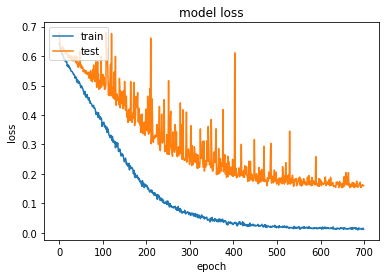

In [64]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [65]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [70]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("C://Users//pranav//Desktop//SER//Emotion_Voice_Detection_CNNModel.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 75.21%


# X. Predicting emotions on the test data

In [71]:
len(data3_df)

160

In [72]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data3_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [00:30<00:00,  5.31it/s]


In [73]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

160/160 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 20ms/step


In [74]:
preds

array([[4.04060371e-02, 9.59593952e-01],
       [5.42703457e-02, 9.45729673e-01],
       [3.77489775e-01, 6.22510254e-01],
       [7.09618628e-03, 9.92903769e-01],
       [5.07596493e-01, 4.92403537e-01],
       [3.10853403e-03, 9.96891439e-01],
       [1.18919031e-03, 9.98810768e-01],
       [2.75274063e-03, 9.97247279e-01],
       [6.36962950e-02, 9.36303735e-01],
       [1.07676268e-01, 8.92323732e-01],
       [7.76831508e-01, 2.23168522e-01],
       [1.02844983e-01, 8.97155046e-01],
       [3.51285040e-01, 6.48714900e-01],
       [2.53522824e-02, 9.74647760e-01],
       [8.77780259e-01, 1.22219764e-01],
       [5.54001808e-01, 4.45998162e-01],
       [1.13658719e-02, 9.88634109e-01],
       [8.69896114e-02, 9.13010418e-01],
       [6.40829501e-04, 9.99359190e-01],
       [1.93699834e-05, 9.99980688e-01],
       [7.19594285e-02, 9.28040564e-01],
       [5.22732874e-03, 9.94772732e-01],
       [2.40910216e-03, 9.97590899e-01],
       [2.45080399e-03, 9.97549236e-01],
       [4.438601

In [75]:
preds1=preds.argmax(axis=1)

In [76]:
preds1

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1], dtype=int64)

In [77]:
abc = preds1.astype(int).flatten()

In [78]:
predictions = (lb.inverse_transform((abc)))

In [79]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

predictedvalues
0   male_positive
1   male_positive
2   male_positive
3   male_positive
4   male_negative
5   male_positive
6   male_positive
7   male_positive
8   male_positive
9   male_positive

In [80]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [81]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

actualvalues
0  male_positive
1  male_positive
2  male_positive
3  male_positive
4  male_positive
5  male_positive
6  male_positive
7  male_positive
8  male_positive
9  male_positive

In [82]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [83]:
finaldf[20:40]

actualvalues predictedvalues
20  male_negative   male_positive
21  male_negative   male_positive
22  male_negative   male_positive
23  male_negative   male_positive
24  male_negative   male_positive
25  male_negative   male_negative
26  male_negative   male_negative
27  male_negative   male_negative
28  male_negative   male_positive
29  male_negative   male_negative
30  male_negative   male_negative
31  male_negative   male_negative
32  male_negative   male_negative
33  male_negative   male_positive
34  male_negative   male_positive
35  male_negative   male_positive
36  male_negative   male_positive
37  male_negative   male_positive
38  male_negative   male_negative
39  male_negative   male_negative

In [84]:
finaldf.groupby('actualvalues').count()

predictedvalues
actualvalues                  
male_negative               96
male_positive               64

In [85]:
finaldf.groupby('predictedvalues').count()

actualvalues
predictedvalues              
male_negative              60
male_positive             100

In [86]:
finaldf.to_csv('Predictions.csv', index=False)

In [87]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [88]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

61.25000000000001

In [89]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

61.225766103814884

In [90]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[47, 49],
       [13, 51]], dtype=int64)

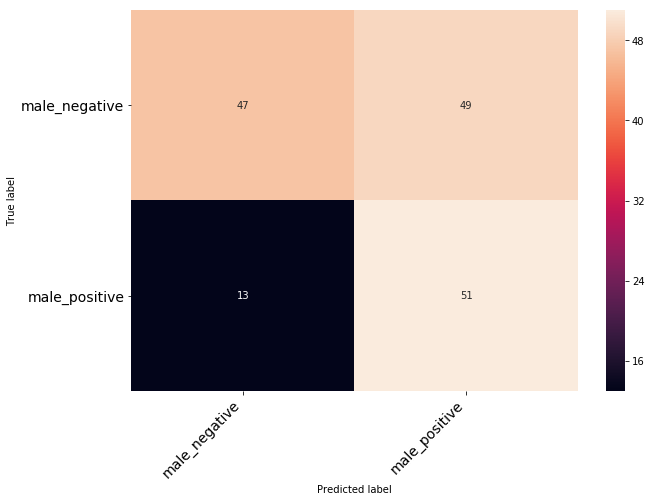

In [91]:
# Visualize Confusion Matrix 

# class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
# class_names = ['male_negative', 'male_neutral', 'male_positive']
class_names = ['male_negative', 'male_positive']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)